In [1]:
import MySQLdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency, chi2
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## CONNECTING  SQL WITH PYTHON

In [2]:
myvars = {}
with open("rgedela-mysql-password") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        myvars[name.strip()] = var.strip()

In [3]:
myvars.keys()

dict_keys(['DB username', 'DB databasename', 'DB password'])

## CONNECTING WITH THE DATABASE

In [4]:
import MySQLdb
conn = MySQLdb.connect(host="localhost", user=myvars['DB username'], passwd=myvars['DB password'], db='I501saptpurkSpring23grp_05_db')
cursor = conn.cursor()

## CREATING THE DATAFRAME

In [5]:
import pandas as pd
cursor.execute('select *  from Patients_pcos');
rows = cursor.fetchall()
df_old = pd.read_sql('select *  from Patients_pcos', conn)

/tmp/ipykernel_128831/3309155551.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_old = pd.read_sql('select *  from Patients_pcos', conn)


In [6]:
df_old

S.NO  Pt.F.NO  PCOS(Y/N)  Age(yrs)  Weight(kg)  Height(cm)      BMI  \
0       1    10001          0        28        44.6     152.000  19.3000   
1       2    10002          0        36        65.0     161.500  24.9212   
2       3    10003          1        33        68.8     165.000  25.2709   
3       4    10004          0        37        65.0     148.000  29.6749   
4       5    10005          0        25        52.0     161.000  20.0610   
..    ...      ...        ...       ...         ...         ...      ...   
536   537    10537          0        35        50.0     164.592  18.5000   
537   538    10538          0        30        63.2     158.000  25.3000   
538   539    10539          0        36        54.0     152.000  23.4000   
539   540    10540          0        27        50.0     150.000  22.2000   
540   541    10541          1        23        82.0     165.000  30.1000   

     Blood_group  PR(bpm)  RR(bpm)  ...  Fast_food(Y/N)  Reg_exercise(Y/N)  \
0             15       78       22  ...               1                  0   
1             15       74       20  ...               0                  0   
2             11       72       18  ...               1                  0   
3             13       72       20  ...               0                  0   
4             11       72       18  ...               0                  0   
..           ...      ...      ...  ...             ...                ...   
536           17       72       16  ...               0                  0   
537           15       72       18  ...               0                  0   
538           13       74       20  ...               0                  0   
539           15       74       20  ...               0                  0   
540           13       80       20  ...               1                  0   

     BP_systolic BP_diastolic  Follicle.no(L)  Follicle.no(R)  \
0            110           80               3               3   
1            120           70               3               5   
2            120           80              13              15   
3            120           70               2               2   
4            120           80               3               4   
..           ...          ...             ...             ...   
536          110           70               1               0   
537          110           70               9               7   
538          110           80               1               0   
539          110           70               7               6   
540          120           70               9              10   

     Avg_F_size(L)(mm)  Avg_F_size(R)(mm)  Insulin_levels  Endometrium(mm)  
0                   18                 18             7.0                8  
1                   15                 14            10.0                4  
2                   18                 20            23.0               10  
3                   15                 14            10.0                8  
4                   16                 14            14.0                7  
..                 ...                ...             ...              ...  
536                 18                 10             8.0                7  
537                 19                 18             7.0                8  
538                 18                  9             9.0                7  
539                 18                 16             8.0               12  
540                 19                 18            22.0                7  

[541 rows x 43 columns]

## DROPPING THE UNWANTED COLUMNS AND ASSIGNING  A NEW DATAFRAME 


In [7]:
# create a new DataFrame with dropped columns
df = df_old.drop(['S.NO', 'Pt.F.NO'], axis=1)

we removed Serial number, Patient file number attributes which are not essential for research study and named the data frame as df

In [8]:
# the dataframe after removing the unwanted columns
df

PCOS(Y/N)  Age(yrs)  Weight(kg)  Height(cm)      BMI  Blood_group  \
0            0        28        44.6     152.000  19.3000           15   
1            0        36        65.0     161.500  24.9212           15   
2            1        33        68.8     165.000  25.2709           11   
3            0        37        65.0     148.000  29.6749           13   
4            0        25        52.0     161.000  20.0610           11   
..         ...       ...         ...         ...      ...          ...   
536          0        35        50.0     164.592  18.5000           17   
537          0        30        63.2     158.000  25.3000           15   
538          0        36        54.0     152.000  23.4000           13   
539          0        27        50.0     150.000  22.2000           15   
540          1        23        82.0     165.000  30.1000           13   

     PR(bpm)  RR(bpm)  Hb(g/dl)  Cycle(R/I)  ...  Fast_food(Y/N)  \
0         78       22     10.48           2  ...               1   
1         74       20     11.70           2  ...               0   
2         72       18     11.80           2  ...               1   
3         72       20     12.00           2  ...               0   
4         72       18     10.00           2  ...               0   
..       ...      ...       ...         ...  ...             ...   
536       72       16     11.00           2  ...               0   
537       72       18     10.80           2  ...               0   
538       74       20     10.80           2  ...               0   
539       74       20     12.00           4  ...               0   
540       80       20     10.20           4  ...               1   

    Reg_exercise(Y/N)  BP_systolic  BP_diastolic  Follicle.no(L)  \
0                   0          110            80               3   
1                   0          120            70               3   
2                   0          120            80              13   
3                   0          120            70               2   
4                   0          120            80               3   
..                ...          ...           ...             ...   
536                 0          110            70               1   
537                 0          110            70               9   
538                 0          110            80               1   
539                 0          110            70               7   
540                 0          120            70               9   

     Follicle.no(R)  Avg_F_size(L)(mm)  Avg_F_size(R)(mm)  Insulin_levels  \
0                 3                 18                 18             7.0   
1                 5                 15                 14            10.0   
2                15                 18                 20            23.0   
3                 2                 15                 14            10.0   
4                 4                 16                 14            14.0   
..              ...                ...                ...             ...   
536               0                 18                 10             8.0   
537               7                 19                 18             7.0   
538               0                 18                  9             9.0   
539               6                 18                 16             8.0   
540              10                 19                 18            22.0   

     Endometrium(mm)  
0                  8  
1                  4  
2                 10  
3                  8  
4                  7  
..               ...  
536                7  
537                8  
538                7  
539               12  
540                7  

[541 rows x 41 columns]

In [9]:
import pandas as pd
# Get the number of rows and columns
num_rows, num_cols = df.shape 
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 541
Number of columns: 41


In [10]:
df.shape

(541, 41)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PCOS(Y/N)             541 non-null    int64  
 1   Age(yrs)              541 non-null    int64  
 2   Weight(kg)            541 non-null    float64
 3   Height(cm)            541 non-null    float64
 4   BMI                   541 non-null    float64
 5   Blood_group           541 non-null    int64  
 6   PR(bpm)               541 non-null    int64  
 7   RR(bpm)               541 non-null    int64  
 8   Hb(g/dl)              541 non-null    float64
 9   Cycle(R/I)            541 non-null    int64  
 10  Cycle_length(days)    541 non-null    int64  
 11  Marr_status(yrs)      540 non-null    object 
 12  Pregnant_status(Y/N)  541 non-null    int64  
 13  No_of_abortions       541 non-null    int64  
 14  FSH                   541 non-null    float64
 15  LH                    5

In [12]:
df.columns

Index(['PCOS(Y/N)', 'Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI',
       'Blood_group', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle(R/I)',
       'Cycle_length(days)', 'Marr_status(yrs)', 'Pregnant_status(Y/N)',
       'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)',
       'Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS',
       'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)',
       'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)',
       'BP_systolic', 'BP_diastolic', 'Follicle.no(L)', 'Follicle.no(R)',
       'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels',
       'Endometrium(mm)'],
      dtype='object')

In [13]:
# checkin g for no of unique values in that columns
for i in df.columns:
     print(i,len(df[i].unique()))

PCOS(Y/N) 2
Age(yrs) 29
Weight(kg) 117
Height(cm) 50
BMI 355
Blood_group 8
PR(bpm) 11
RR(bpm) 8
Hb(g/dl) 46
Cycle(R/I) 3
Cycle_length(days) 12
Marr_status(yrs) 35
Pregnant_status(Y/N) 2
No_of_abortions 6
FSH 371
LH 342
FSH/LH 512
Hip(inch) 19
Waist(inch) 23
Waist:Hip 96
TSH 308
AMH 301
PRL 481
Vit_D3 331
PRG 89
RBS 55
Wt_gain(Y/N) 2
Hair_growth(Y/N) 2
Skin_darkening(Y/N) 2
Hair_loss(Y/N) 2
Pimples(Y/N) 2
Fast_food(Y/N) 3
Reg_exercise(Y/N) 2
BP_systolic 6
BP_diastolic 5
Follicle.no(L) 21
Follicle.no(R) 20
Avg_F_size(L)(mm) 21
Avg_F_size(R)(mm) 22
Insulin_levels 27
Endometrium(mm) 17


In [14]:
cat_cols = ['PCOS(Y/N)', 'Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)']
num_cols = ['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)','Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic','Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels','Endometrium(mm)']

print(f'Categorical Variable: {cat_cols}')
print(f'Numerical Variable: {num_cols}')

Categorical Variable: ['PCOS(Y/N)', 'Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)']
Numerical Variable: ['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic', 'Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels', 'Endometrium(mm)']


In [15]:
df["PCOS(Y/N)"].value_counts()

0    364
1    177
Name: PCOS(Y/N), dtype: int64

## DATA CLEANING

## CHECKING FOR NULL AND MISSING VALUES 

In [16]:
# Check for null values in the dataset
print(df.isnull().sum())

PCOS(Y/N)               0
Age(yrs)                0
Weight(kg)              0
Height(cm)              0
BMI                     0
Blood_group             0
PR(bpm)                 0
RR(bpm)                 0
Hb(g/dl)                0
Cycle(R/I)              0
Cycle_length(days)      0
Marr_status(yrs)        1
Pregnant_status(Y/N)    0
No_of_abortions         0
FSH                     0
LH                      0
FSH/LH                  0
Hip(inch)               0
Waist(inch)             0
Waist:Hip               0
TSH                     0
AMH                     1
PRL                     0
Vit_D3                  0
PRG                     0
RBS                     0
Wt_gain(Y/N)            0
Hair_growth(Y/N)        0
Skin_darkening(Y/N)     0
Hair_loss(Y/N)          0
Pimples(Y/N)            0
Fast_food(Y/N)          1
Reg_exercise(Y/N)       0
BP_systolic             0
BP_diastolic            0
Follicle.no(L)          0
Follicle.no(R)          0
Avg_F_size(L)(mm)       0
Avg_F_size(R

In [17]:
print(df.isnull().any())

PCOS(Y/N)               False
Age(yrs)                False
Weight(kg)              False
Height(cm)              False
BMI                     False
Blood_group             False
PR(bpm)                 False
RR(bpm)                 False
Hb(g/dl)                False
Cycle(R/I)              False
Cycle_length(days)      False
Marr_status(yrs)         True
Pregnant_status(Y/N)    False
No_of_abortions         False
FSH                     False
LH                      False
FSH/LH                  False
Hip(inch)               False
Waist(inch)             False
Waist:Hip               False
TSH                     False
AMH                      True
PRL                     False
Vit_D3                  False
PRG                     False
RBS                     False
Wt_gain(Y/N)            False
Hair_growth(Y/N)        False
Skin_darkening(Y/N)     False
Hair_loss(Y/N)          False
Pimples(Y/N)            False
Fast_food(Y/N)           True
Reg_exercise(Y/N)       False
BP_systoli

## REPLACING THE NULL VALUES WITH MODE FOR CATEGORRICAL VARIABLES


In [18]:
df['Fast_food(Y/N)'].fillna(df['Fast_food(Y/N)'].mode()[0], inplace=True)

In [19]:
mode_value = df['Fast_food(Y/N)'].mode()
print(mode_value)

0    1
Name: Fast_food(Y/N), dtype: object


## REPLACING THE NULL VALUES WITH MEDIAN FOR CONTINUOUS VARIABLES


In [20]:
df['Marr_status(yrs)'].fillna(df['Marr_status(yrs)'].mode()[0], inplace=True)

In [21]:
median_value = df['Marr_status(yrs)'].median()
print(median_value)

7.0


In [22]:
df['AMH'].fillna(df['AMH'].median(), inplace=True)

In [23]:
median_value = df['AMH'].median()
print(median_value)

3.7


## AGAIN CHECKING THE NULL VALUES IF STILL EXISTS


In [24]:
# Check if any null values still exist in the entire DataFrame
if df.isnull().any().any():
    print("Null values exist in the dataset")
else:
    print("No null values exist in the dataset")

No null values exist in the dataset


In [25]:
print(df.isnull().any())

PCOS(Y/N)               False
Age(yrs)                False
Weight(kg)              False
Height(cm)              False
BMI                     False
Blood_group             False
PR(bpm)                 False
RR(bpm)                 False
Hb(g/dl)                False
Cycle(R/I)              False
Cycle_length(days)      False
Marr_status(yrs)        False
Pregnant_status(Y/N)    False
No_of_abortions         False
FSH                     False
LH                      False
FSH/LH                  False
Hip(inch)               False
Waist(inch)             False
Waist:Hip               False
TSH                     False
AMH                     False
PRL                     False
Vit_D3                  False
PRG                     False
RBS                     False
Wt_gain(Y/N)            False
Hair_growth(Y/N)        False
Skin_darkening(Y/N)     False
Hair_loss(Y/N)          False
Pimples(Y/N)            False
Fast_food(Y/N)          False
Reg_exercise(Y/N)       False
BP_systoli

## CHECKING IF THERE WERE ANY DUPLICATED ROWS EXISTS

In [26]:
df[df.duplicated()]

Empty DataFrame
Columns: [PCOS(Y/N), Age(yrs), Weight(kg), Height(cm), BMI, Blood_group, PR(bpm), RR(bpm), Hb(g/dl), Cycle(R/I), Cycle_length(days), Marr_status(yrs), Pregnant_status(Y/N), No_of_abortions, FSH, LH, FSH/LH, Hip(inch), Waist(inch), Waist:Hip, TSH, AMH, PRL, Vit_D3, PRG, RBS, Wt_gain(Y/N), Hair_growth(Y/N), Skin_darkening(Y/N), Hair_loss(Y/N), Pimples(Y/N), Fast_food(Y/N), Reg_exercise(Y/N), BP_systolic, BP_diastolic, Follicle.no(L), Follicle.no(R), Avg_F_size(L)(mm), Avg_F_size(R)(mm), Insulin_levels, Endometrium(mm)]
Index: []

[0 rows x 41 columns]

## CHANGING THE DATATYPES OF THE COLUMNS 

In [27]:
df['Marr_status(yrs)'] = df['Marr_status(yrs)'].astype(float)
print(df['Marr_status(yrs)'].dtype)

float64


In [28]:
# Convert the column to float
df['AMH'] = df['AMH'].astype(float)
# Print the current data type of the column
print(df['AMH'].dtype)

float64


In [29]:
# Convert the column to int
df['Fast_food(Y/N)'] = df['Fast_food(Y/N)'].astype(int)
# Print the current data type of the column
print(df['Fast_food(Y/N)'].dtype)

int64


In [30]:
# Check the data types of all columns
print(df.dtypes)

PCOS(Y/N)                 int64
Age(yrs)                  int64
Weight(kg)              float64
Height(cm)              float64
BMI                     float64
Blood_group               int64
PR(bpm)                   int64
RR(bpm)                   int64
Hb(g/dl)                float64
Cycle(R/I)                int64
Cycle_length(days)        int64
Marr_status(yrs)        float64
Pregnant_status(Y/N)      int64
No_of_abortions           int64
FSH                     float64
LH                      float64
FSH/LH                  float64
Hip(inch)                 int64
Waist(inch)               int64
Waist:Hip               float64
TSH                     float64
AMH                     float64
PRL                     float64
Vit_D3                  float64
PRG                     float64
RBS                     float64
Wt_gain(Y/N)              int64
Hair_growth(Y/N)          int64
Skin_darkening(Y/N)       int64
Hair_loss(Y/N)            int64
Pimples(Y/N)              int64
Fast_foo

## VISUALISING THE DATA BEFORE REMOVING OUTLIERS

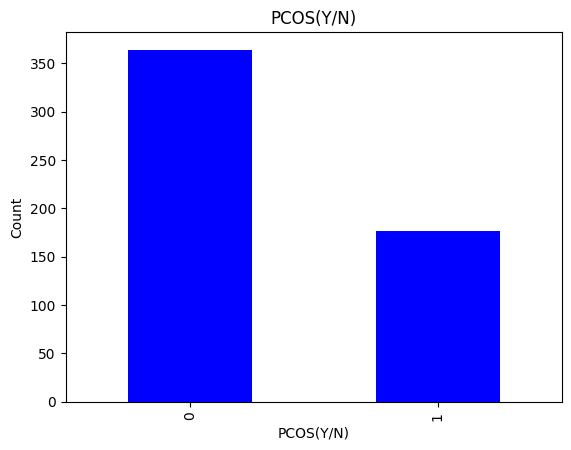

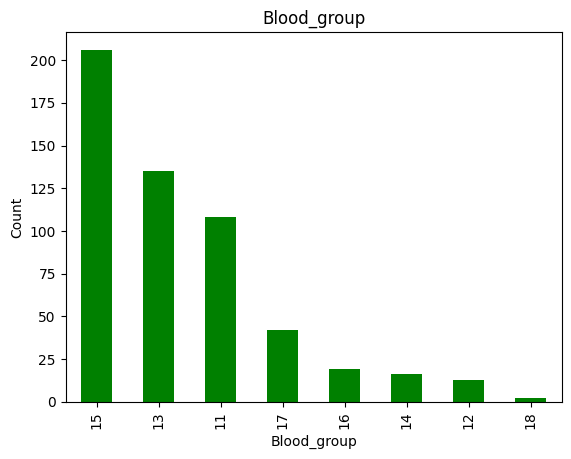

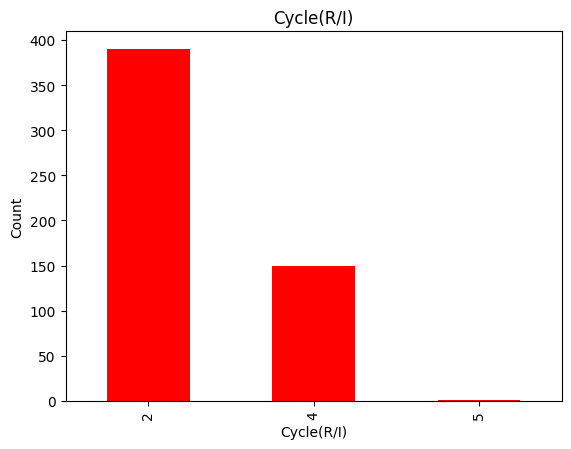

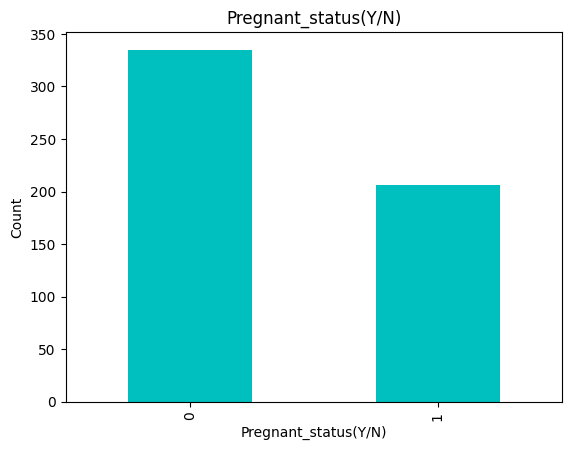

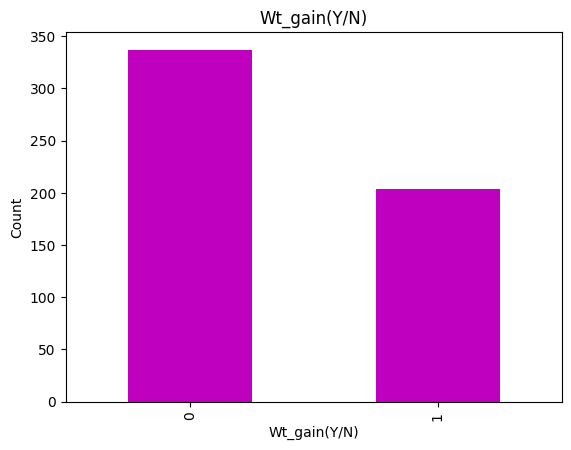

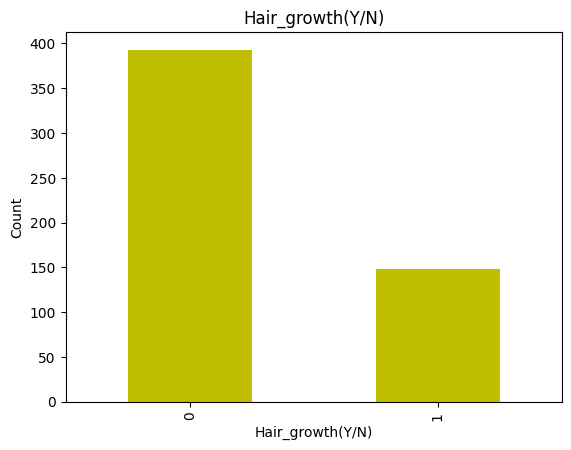

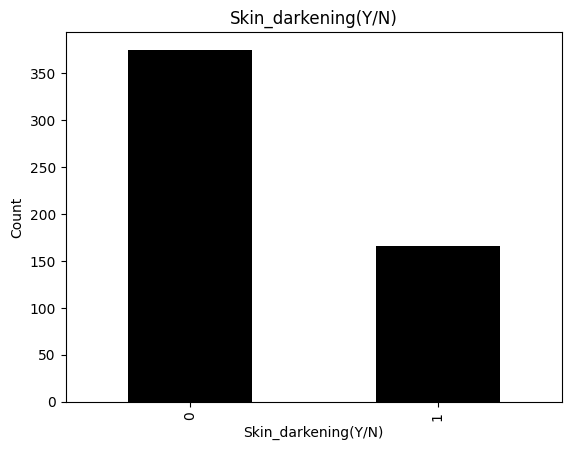

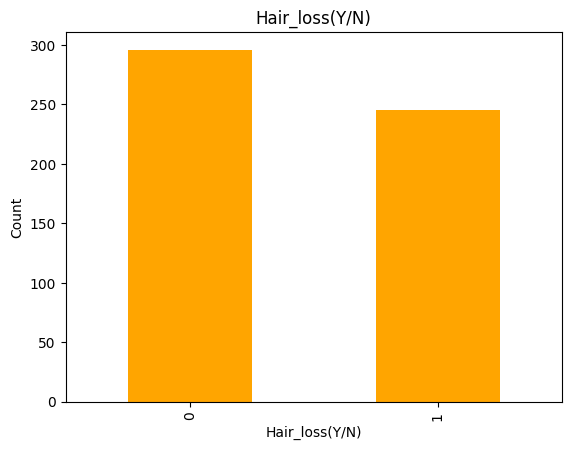

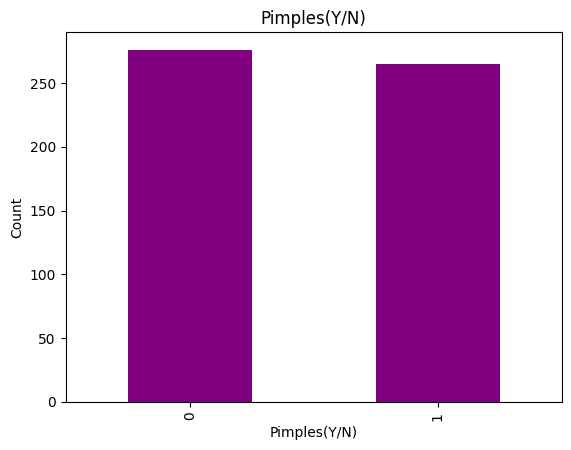

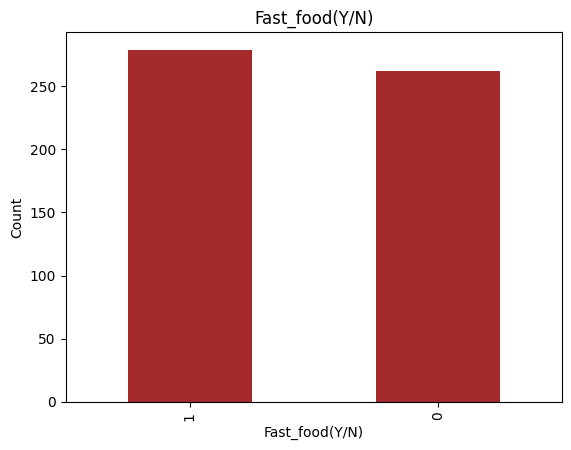

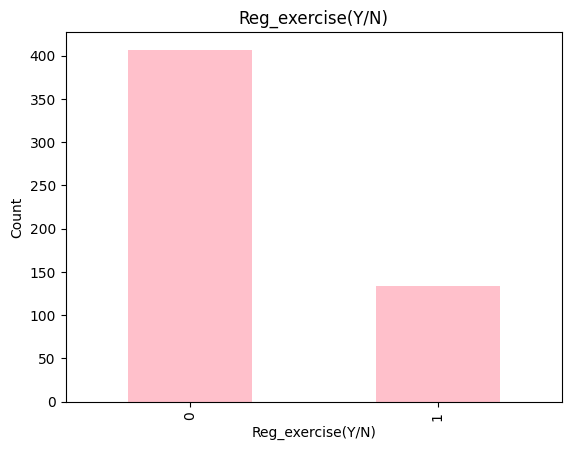

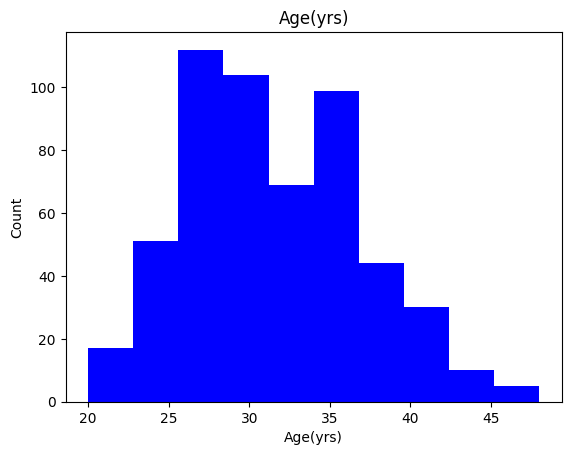

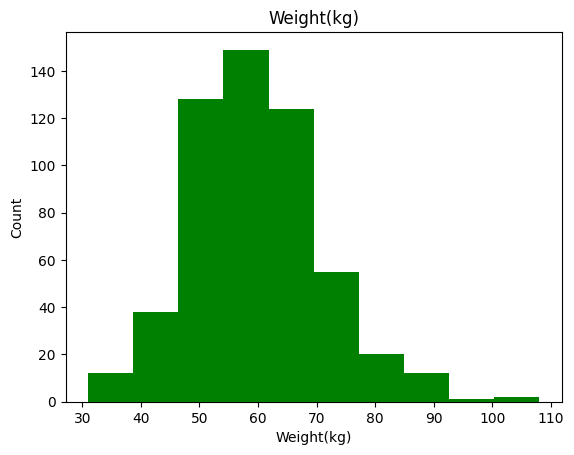

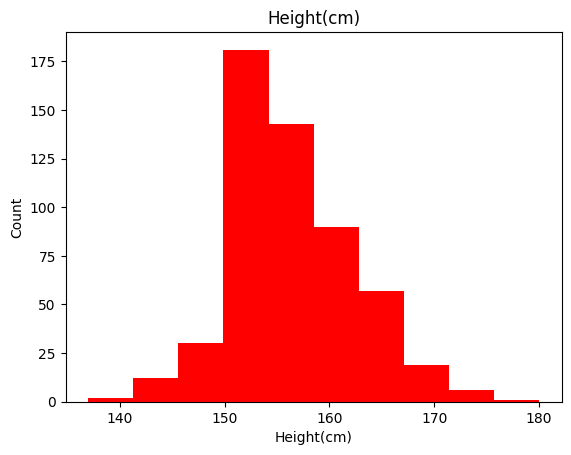

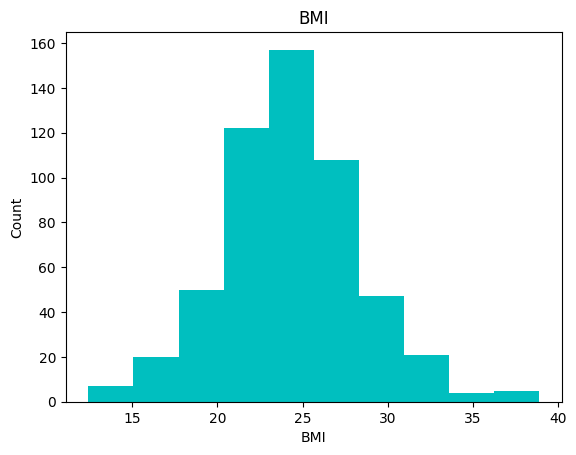

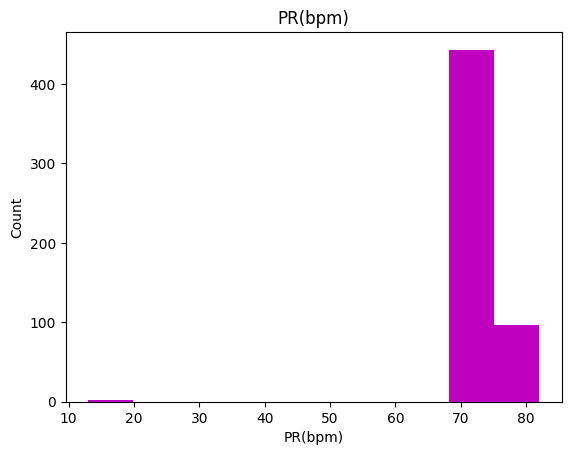

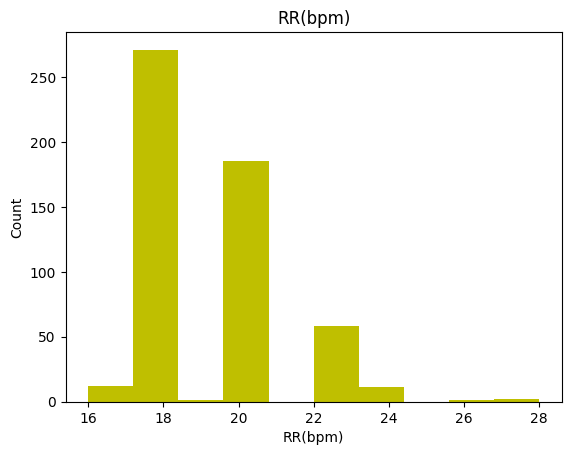

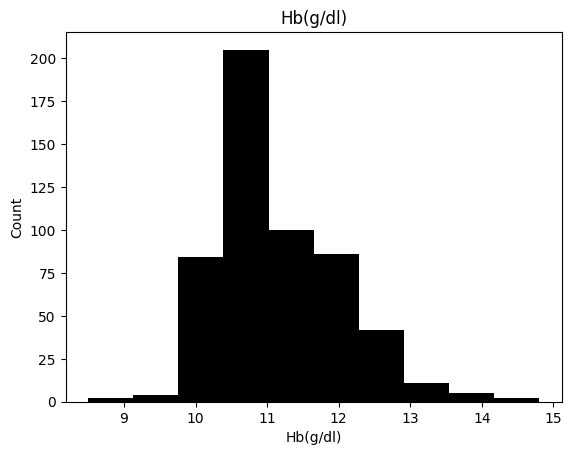

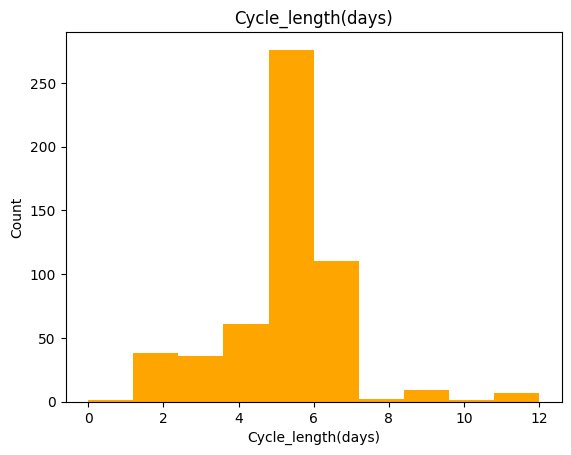

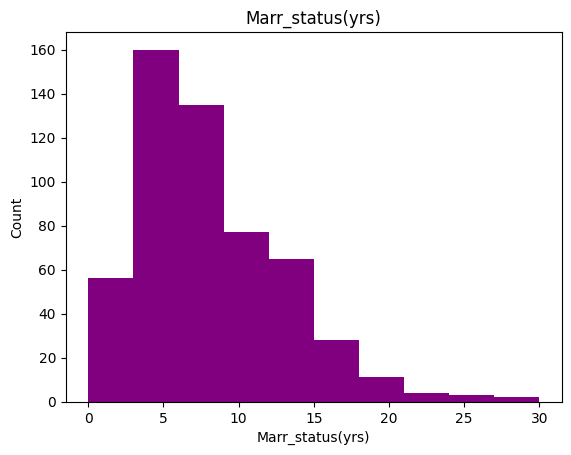

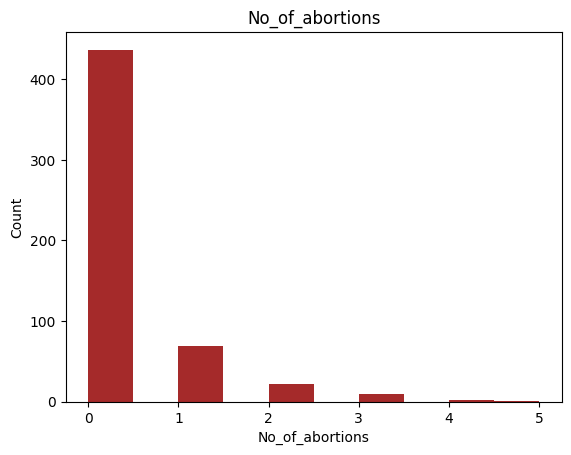

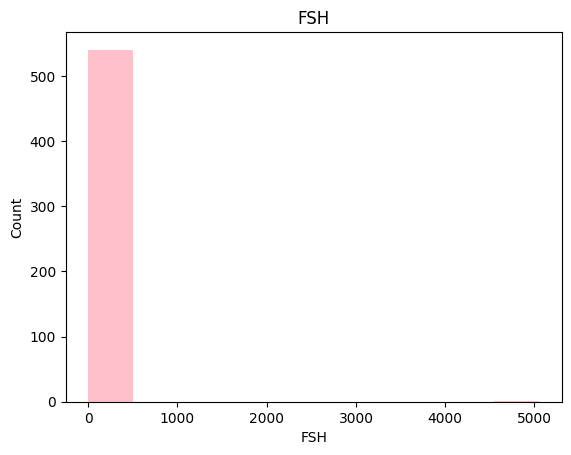

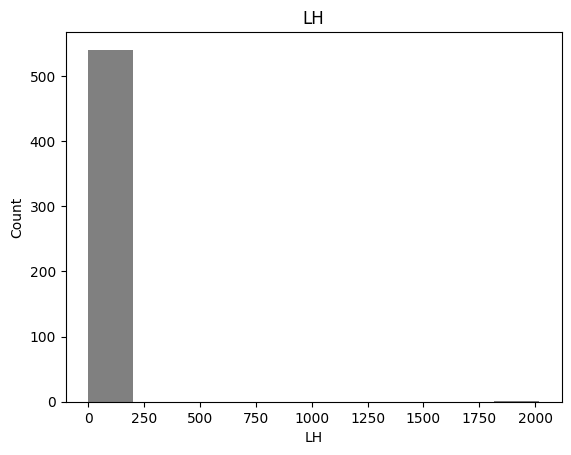

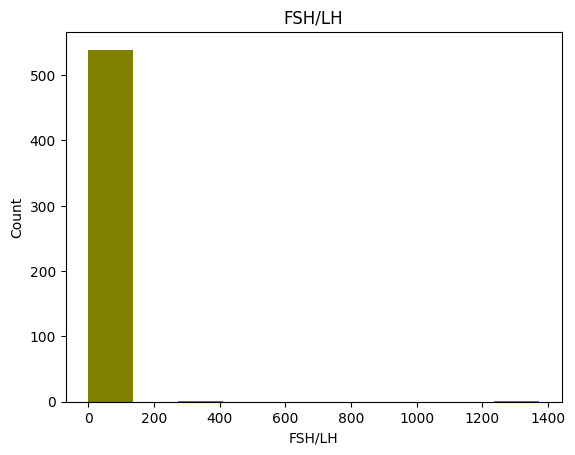

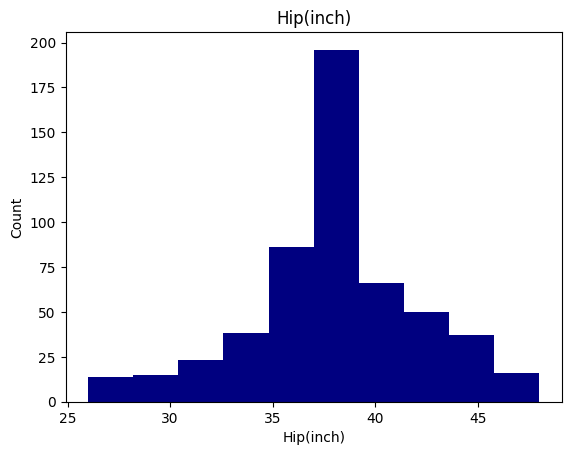

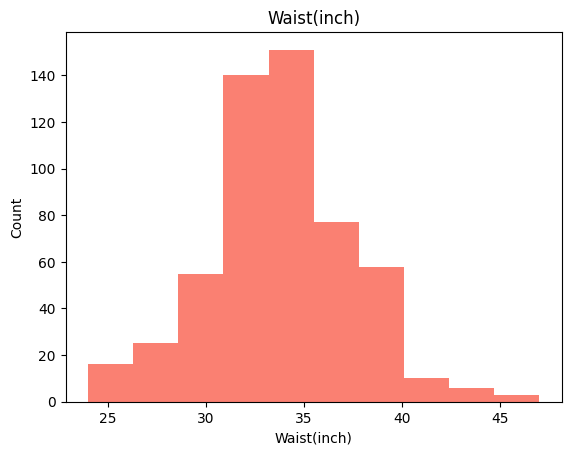

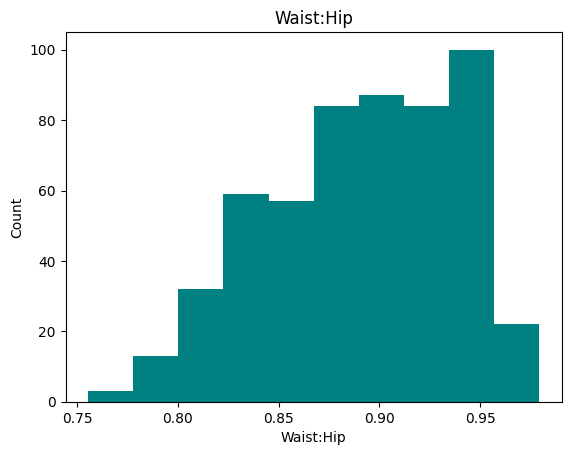

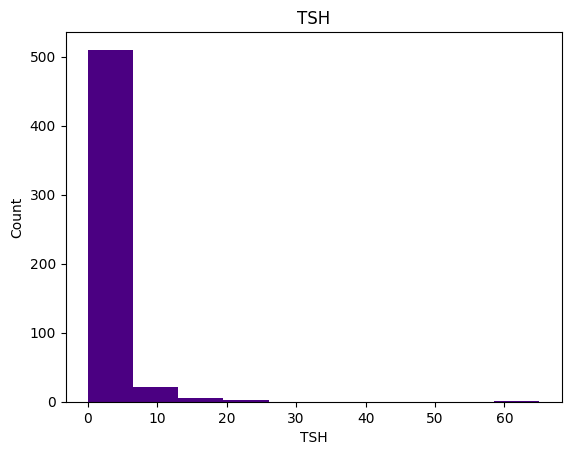

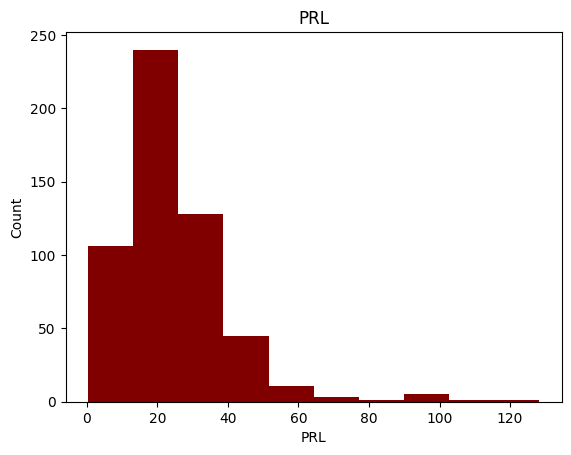

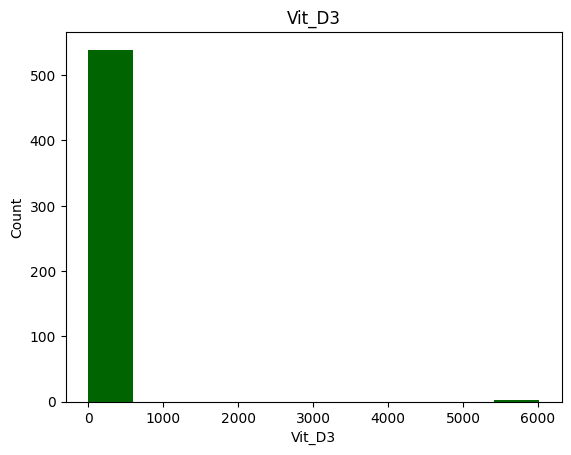

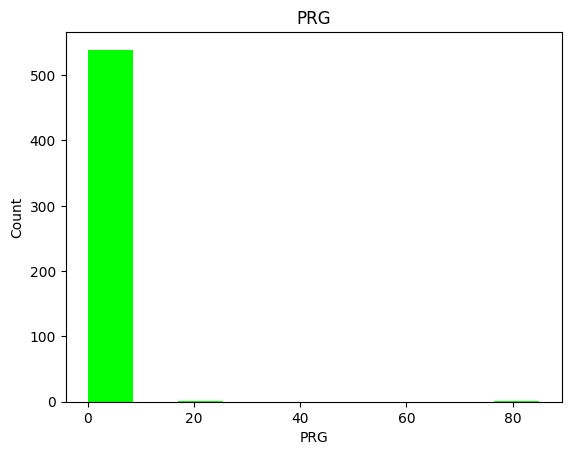

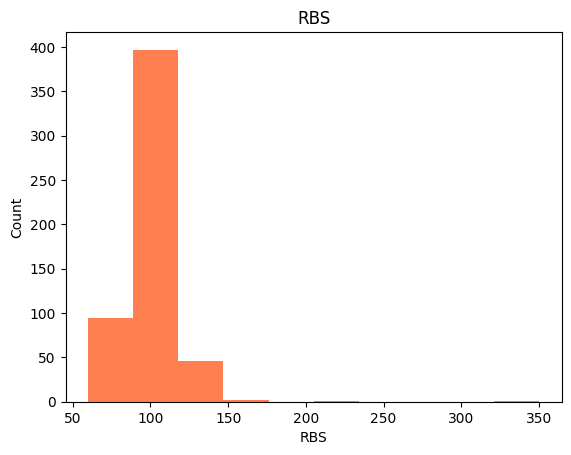

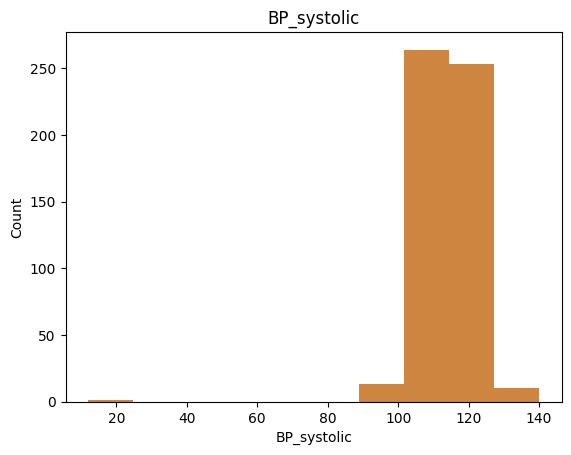

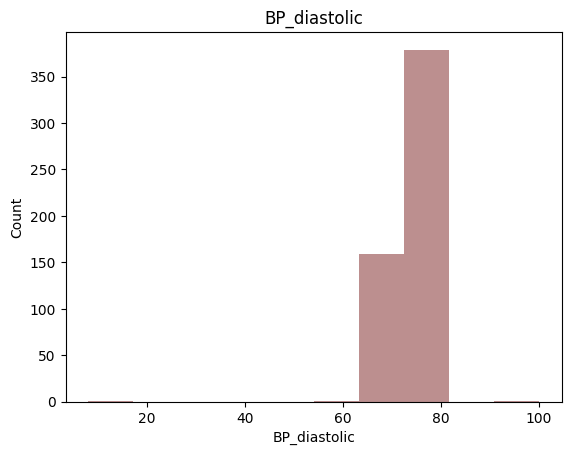

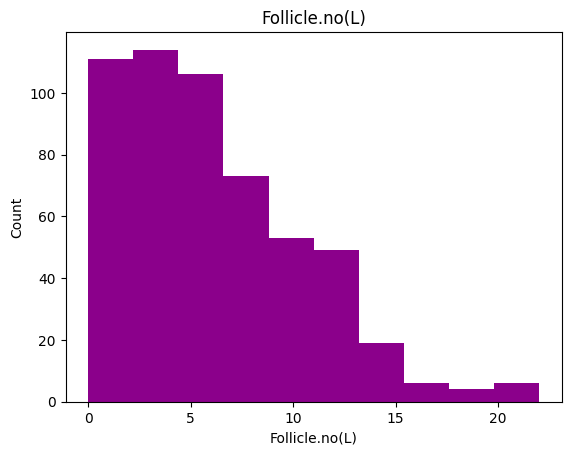

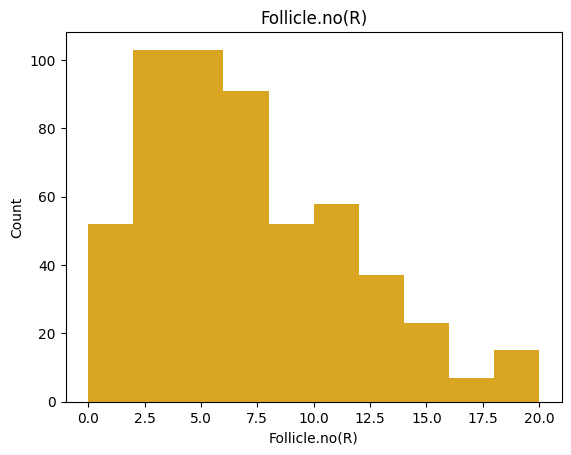

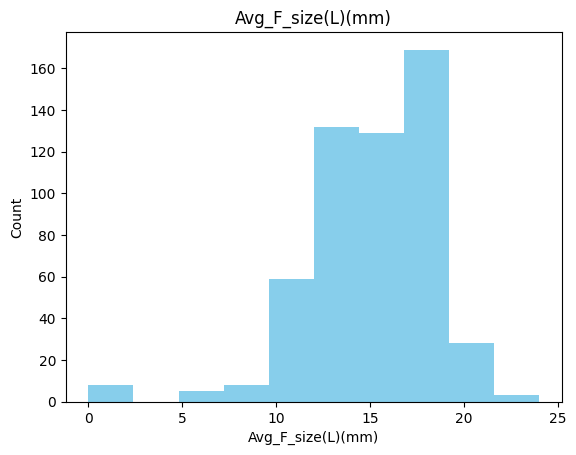

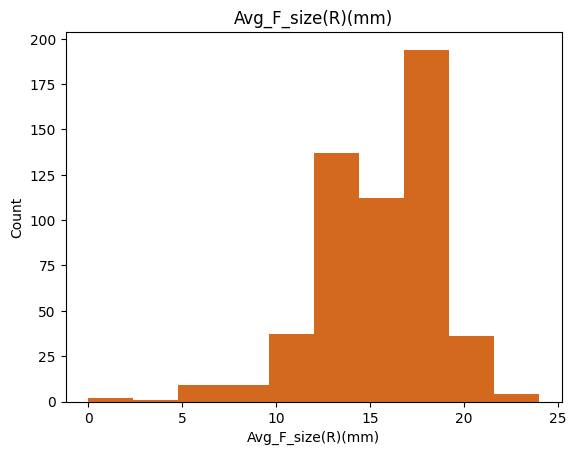

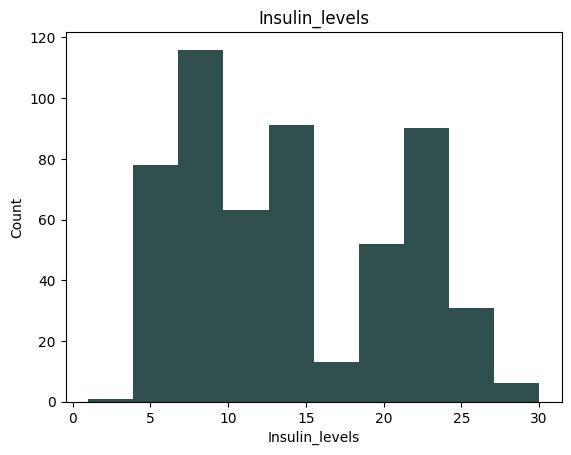

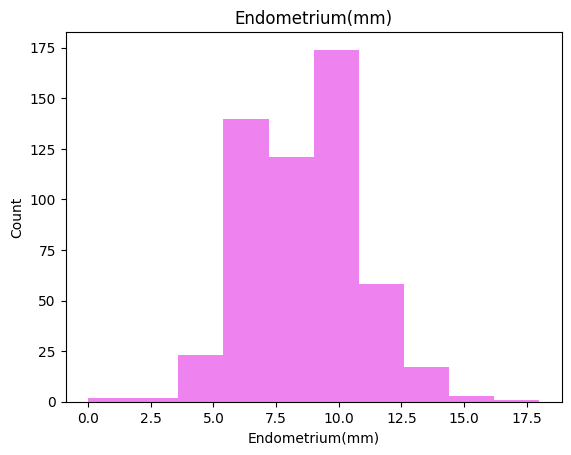

In [31]:
import matplotlib.pyplot as plt
# Separate categorical and numerical columns
cat_cols = ['PCOS(Y/N)', 'Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)']

num_cols = ['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)','Waist:Hip', 'TSH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic','Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels','Endometrium(mm)']

# Separate categorical and numerical data frames
cat_data = df[cat_cols]
num_data = df[num_cols]

# Set colors for numerical columns
num_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy','salmon', 'teal', 'indigo', 'maroon', 'darkgreen', 'lime', 'coral', 'peru', 'rosybrown','darkmagenta', 'goldenrod', 'skyblue', 'chocolate', 'darkslategray', 'violet']

# Set colors for categorical columns
cat_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink']

# Visualize categorical columns in bar chart
for i, col in enumerate(cat_cols):
    plt.figure()
    cat_data[col].value_counts().plot(kind='bar', color=cat_colors[i % len(cat_colors)])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Visualize numerical columns in histogram
for i, col in enumerate(num_cols):
    plt.figure()
    plt.hist(num_data[col], color=num_colors[i % len(num_colors)])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## DEALING WITH OUTLIERS 

Chceking which columns has the outliers 

For our own assumption to make sure that the outliers are capped we have checked the minimum and maxium values before and after capping the outliers  

In [32]:
# Checking outliers for numerical columns
num_columns = ['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)','Waist:Hip', 'TSH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic','Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels','Endometrium(mm)']
num_data = df[num_columns]
# Detect and count outliers in numerical columns only
Q1 = num_data.quantile(0.25)
Q3 = num_data.quantile(0.75)
IQR = Q3 - Q1
outliers = (num_data < (Q1 - 1.5 * IQR)) | (num_data > (Q3 + 1.5 * IQR))
outliers_count = outliers.sum()
print(outliers_count)

Age(yrs)               5
Weight(kg)            18
Height(cm)             6
BMI                   12
PR(bpm)               94
RR(bpm)               14
Hb(g/dl)               8
Cycle_length(days)    77
Marr_status(yrs)      11
FSH                   12
LH                    24
FSH/LH                48
Hip(inch)             21
Waist(inch)           17
Waist:Hip              0
TSH                   27
PRL                   21
Vit_D3                31
PRG                   39
RBS                   30
BP_systolic            3
BP_diastolic           2
Follicle.no(L)         6
Follicle.no(R)         0
Avg_F_size(L)(mm)      9
Avg_F_size(R)(mm)      5
Insulin_levels         0
Endometrium(mm)        7
dtype: int64


In [33]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Age(yrs)'].max()
min_value = df['Age(yrs)'].min()

# print the results
print("Maximum value in 'Age(yrs)':", max_value)
print("Minimum value in 'Age(yrs)':", min_value)

Maximum value in 'Age(yrs)': 48
Minimum value in 'Age(yrs)': 20


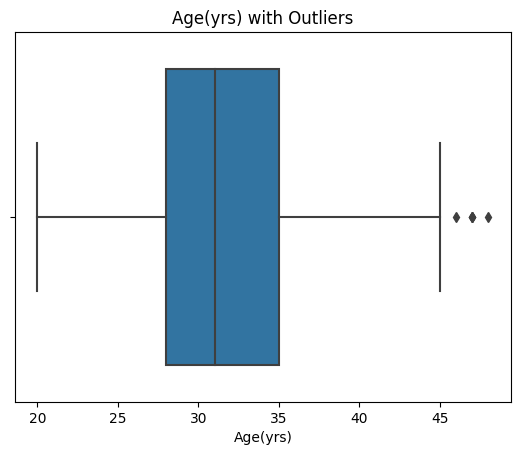

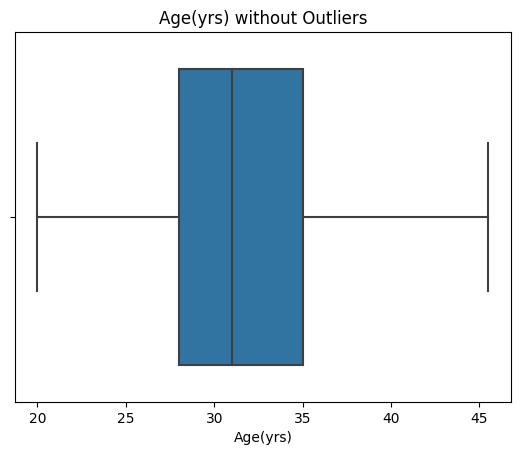

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Detect and count outliers
Q1 = df['Age(yrs)'].quantile(0.25)
Q3 = df['Age(yrs)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Age(yrs)'] < lower_cap) | (df['Age(yrs)'] > upper_cap)
outliers_count = outliers.sum()

# Create box plot with outliers
sns.boxplot(x='Age(yrs)', data=df)
plt.title('Age(yrs) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Age(yrs)'] = df['Age(yrs)'].clip(lower=lower_cap, upper=upper_cap)

# Create box plot without outliers
sns.boxplot(x='Age(yrs)', data=df)
plt.title('Age(yrs) without Outliers')
plt.show()


In [35]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Age(yrs)'].max()
min_value = df['Age(yrs)'].min()

# print the results
print("Maximum value in 'Age(yrs)':", max_value)
print("Minimum value in 'Age(yrs)':", min_value)

Maximum value in 'Age(yrs)': 45.5
Minimum value in 'Age(yrs)': 20.0


In [36]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Weight(kg)'].max()
min_value = df['Weight(kg)'].min()

# print the results
print("Maximum value in 'Weight(kg)':", max_value)
print("Minimum value in 'Weight(kg)':", min_value)

Maximum value in 'Weight(kg)': 108.0
Minimum value in 'Weight(kg)': 31.0


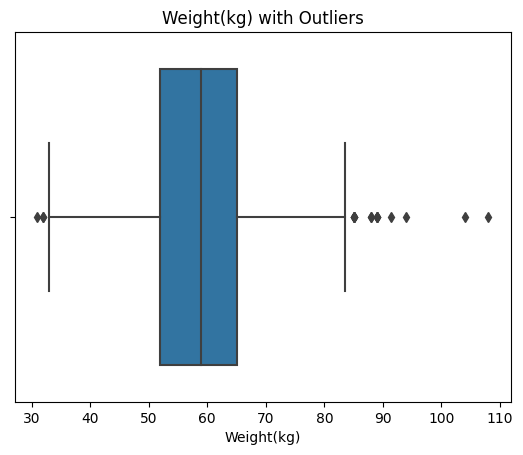

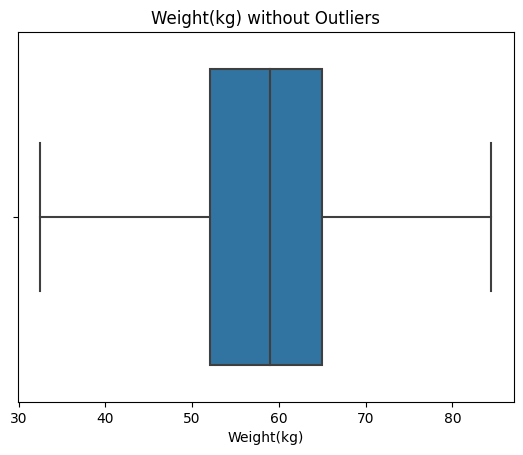

In [37]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Weight(kg)'].quantile(0.25)
Q3 = df['Weight(kg)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Weight(kg)'] < lower_cap) | (df['Weight(kg)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Weight(kg)', data=df)
plt.title('Weight(kg) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Weight(kg)'] = df['Weight(kg)'].clip(lower=lower_cap, upper=upper_cap)



# Create box plot without outliers
sns.boxplot(x='Weight(kg)', data=df)
plt.title('Weight(kg) without Outliers')
plt.show()


In [38]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Weight(kg)'].max()
min_value = df['Weight(kg)'].min()

# print the results
print("Maximum value in 'Weight(kg)':", max_value)
print("Minimum value in 'Weight(kg)':", min_value)

Maximum value in 'Weight(kg)': 84.5
Minimum value in 'Weight(kg)': 32.5


In [39]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Height(cm)'].max()
min_value = df['Height(cm)'].min()

# print the results
print("Maximum value in 'Height(cm)':", max_value)
print("Minimum value in 'Height(cm)':", min_value)

Maximum value in 'Height(cm)': 180.0
Minimum value in 'Height(cm)': 137.0


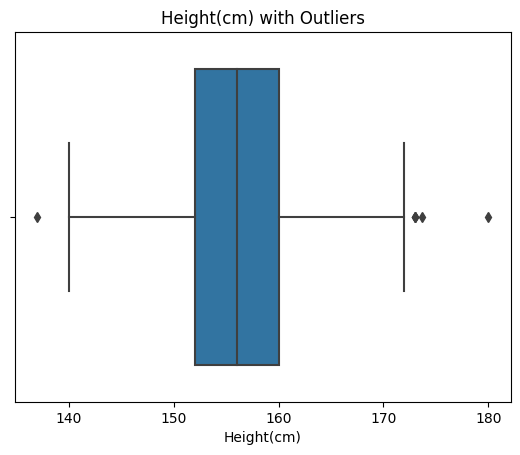

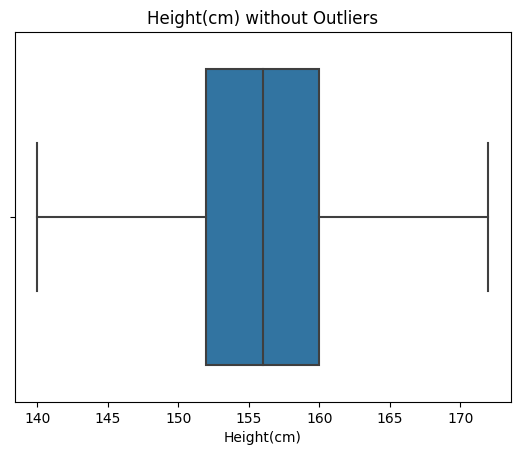

In [40]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Height(cm)'].quantile(0.25)
Q3 = df['Height(cm)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Height(cm)'] < lower_cap) | (df['Height(cm)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Height(cm)', data=df)
plt.title('Height(cm) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Height(cm)'] = df['Height(cm)'].clip(lower=lower_cap, upper=upper_cap)



# Create box plot without outliers
sns.boxplot(x='Height(cm)', data=df)
plt.title('Height(cm) without Outliers')
plt.show()


In [41]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Height(cm)'].max()
min_value = df['Height(cm)'].min()

# print the results
print("Maximum value in 'Height(cm)':", max_value)
print("Minimum value in 'Height(cm)':", min_value)

Maximum value in 'Height(cm)': 172.0
Minimum value in 'Height(cm)': 140.0


In [42]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['BMI'].max()
min_value = df['BMI'].min()

# print the results
print("Maximum value in 'BMI':", max_value)
print("Minimum value in 'BMI':", min_value)

Maximum value in 'BMI': 38.9
Minimum value in 'BMI': 12.4179


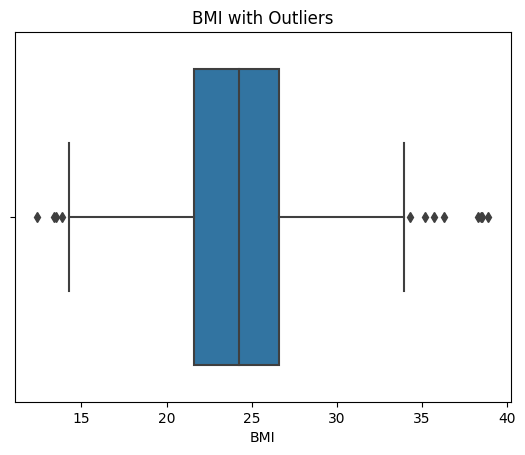

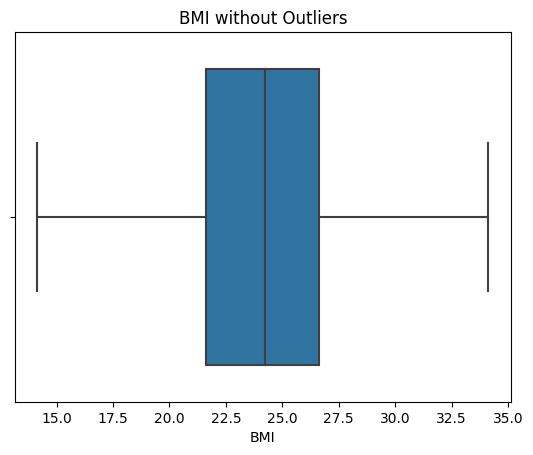

In [43]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['BMI'] < lower_cap) | (df['BMI'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='BMI', data=df)
plt.title('BMI with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['BMI'] = df['BMI'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='BMI', data=df)
plt.title('BMI without Outliers')
plt.show()


In [44]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['BMI'].max()
min_value = df['BMI'].min()

# print the results
print("Maximum value in 'BMI':", max_value)
print("Minimum value in 'BMI':", min_value)

Maximum value in 'BMI': 34.125550000000004
Minimum value in 'BMI': 14.15075


In [45]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['PR(bpm)'].max()
min_value = df['PR(bpm)'].min()

# print the results
print("Maximum value in 'PR(bpm)':", max_value)
print("Minimum value in 'PR(bpm)':", min_value)

Maximum value in 'PR(bpm)': 82
Minimum value in 'PR(bpm)': 13


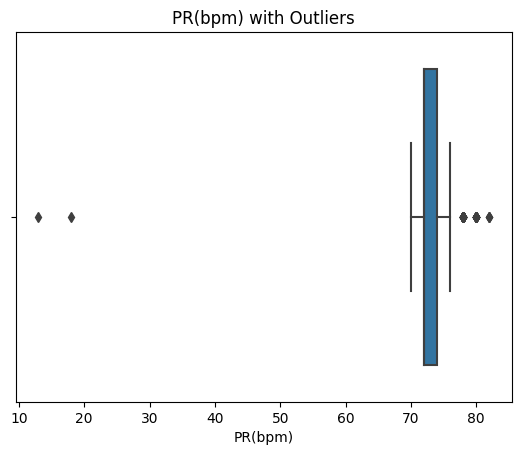

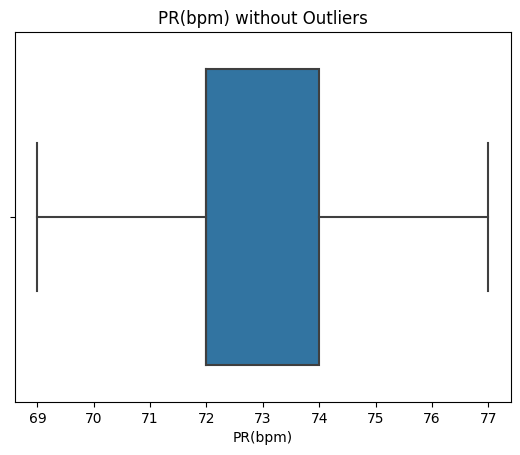

In [46]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['PR(bpm)'].quantile(0.25)
Q3 = df['PR(bpm)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['PR(bpm)'] < lower_cap) | (df['PR(bpm)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='PR(bpm)', data=df)
plt.title('PR(bpm) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['PR(bpm)'] = df['PR(bpm)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='PR(bpm)', data=df)
plt.title('PR(bpm) without Outliers')
plt.show()


In [47]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['PR(bpm)'].max()
min_value = df['PR(bpm)'].min()

# print the results
print("Maximum value in 'PR(bpm)':", max_value)
print("Minimum value in 'PR(bpm)':", min_value)

Maximum value in 'PR(bpm)': 77
Minimum value in 'PR(bpm)': 69


In [48]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['RR(bpm)'].max()
min_value = df['RR(bpm)'].min()

# print the results
print("Maximum value in 'RR(bpm)':", max_value)
print("Minimum value in 'RR(bpm)':", min_value)

Maximum value in 'RR(bpm)': 28
Minimum value in 'RR(bpm)': 16


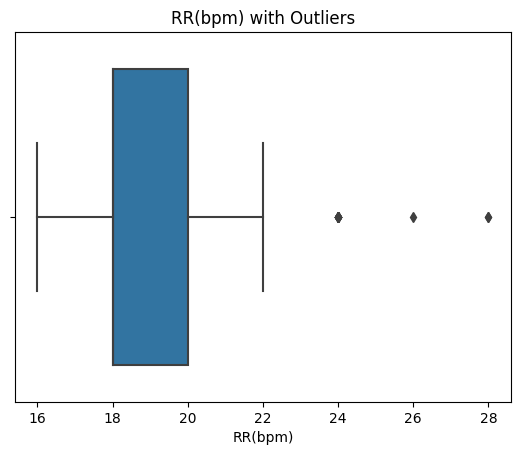

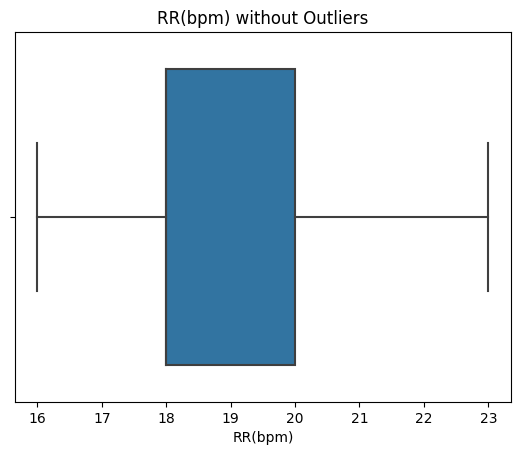

In [49]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['RR(bpm)'].quantile(0.25)
Q3 = df['RR(bpm)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['RR(bpm)'] < lower_cap) | (df['RR(bpm)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='RR(bpm)', data=df)
plt.title('RR(bpm) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['RR(bpm)'] = df['RR(bpm)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='RR(bpm)', data=df)
plt.title('RR(bpm) without Outliers')
plt.show()


In [50]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['RR(bpm)'].max()
min_value = df['RR(bpm)'].min()

# print the results
print("Maximum value in 'RR(bpm)':", max_value)
print("Minimum value in 'RR(bpm)':", min_value)

Maximum value in 'RR(bpm)': 23
Minimum value in 'RR(bpm)': 16


In [51]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Hb(g/dl)'].max()
min_value = df['Hb(g/dl)'].min()

# print the results
print("Maximum value in 'Hb(g/dl)':", max_value)
print("Minimum value in 'Hb(g/dl)':", min_value)

Maximum value in 'Hb(g/dl)': 14.8
Minimum value in 'Hb(g/dl)': 8.5


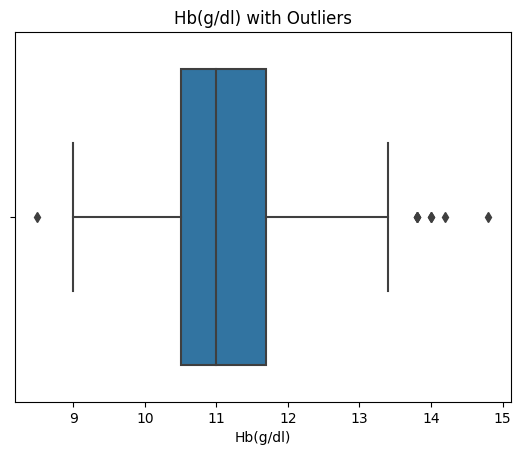

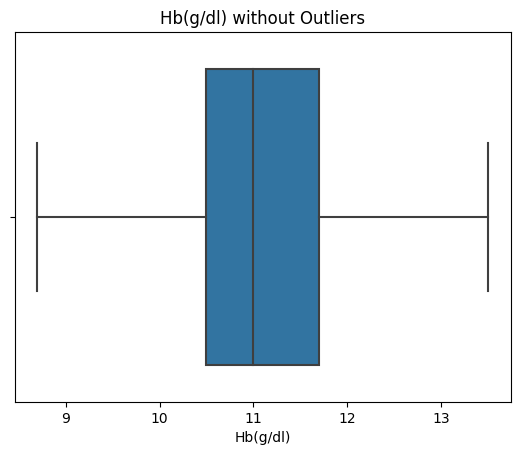

In [52]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['Hb(g/dl)'].quantile(0.25)
Q3 = df['Hb(g/dl)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Hb(g/dl)'] < lower_cap) | (df['Hb(g/dl)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Hb(g/dl)', data=df)
plt.title('Hb(g/dl) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Hb(g/dl)'] = df['Hb(g/dl)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Hb(g/dl)', data=df)
plt.title('Hb(g/dl) without Outliers')
plt.show()


In [53]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Hb(g/dl)'].max()
min_value = df['Hb(g/dl)'].min()

# print the results
print("Maximum value in 'Hb(g/dl)':", max_value)
print("Minimum value in 'Hb(g/dl)':", min_value)

Maximum value in 'Hb(g/dl)': 13.499999999999998
Minimum value in 'Hb(g/dl)': 8.700000000000001


In [54]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Cycle_length(days)'].max()
min_value = df['Cycle_length(days)'].min()

# print the results
print("Maximum value in 'Cycle_length(days)':", max_value)
print("Minimum value in 'Cycle_length(days)':", min_value)

Maximum value in 'Cycle_length(days)': 12
Minimum value in 'Cycle_length(days)': 0


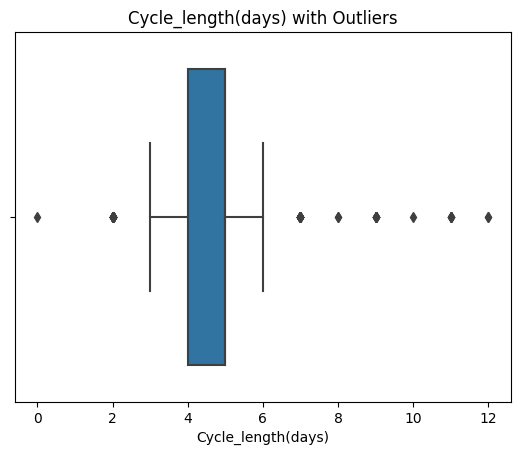

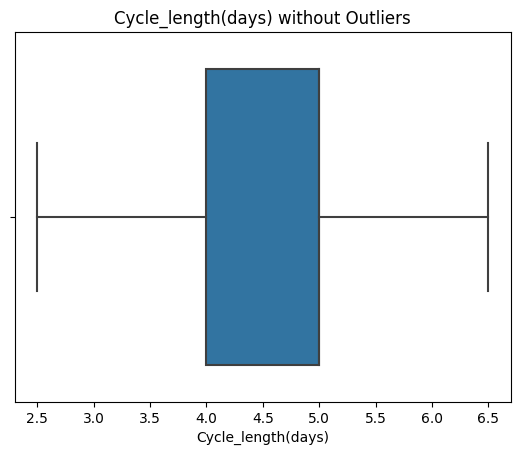

In [55]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Cycle_length(days)'].quantile(0.25)
Q3 = df['Cycle_length(days)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Cycle_length(days)'] < lower_cap) | (df['Cycle_length(days)'] > upper_cap)
outliers_count = outliers.sum()



# Create box plot with outliers
sns.boxplot(x='Cycle_length(days)', data=df)
plt.title('Cycle_length(days) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Cycle_length(days)'] = df['Cycle_length(days)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Cycle_length(days)', data=df)
plt.title('Cycle_length(days) without Outliers')
plt.show()


In [56]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Cycle_length(days)'].max()
min_value = df['Cycle_length(days)'].min()

# print the results
print("Maximum value in 'Cycle_length(days)':", max_value)
print("Minimum value in 'Cycle_length(days)':", min_value)

Maximum value in 'Cycle_length(days)': 6.5
Minimum value in 'Cycle_length(days)': 2.5


In [57]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Marr_status(yrs)'].max()
min_value = df['Marr_status(yrs)'].min()

# print the results
print("Maximum value in 'Marr_status(yrs)':", max_value)
print("Minimum value in 'Marr_status(yrs)':", min_value)

Maximum value in 'Marr_status(yrs)': 30.0
Minimum value in 'Marr_status(yrs)': 0.0


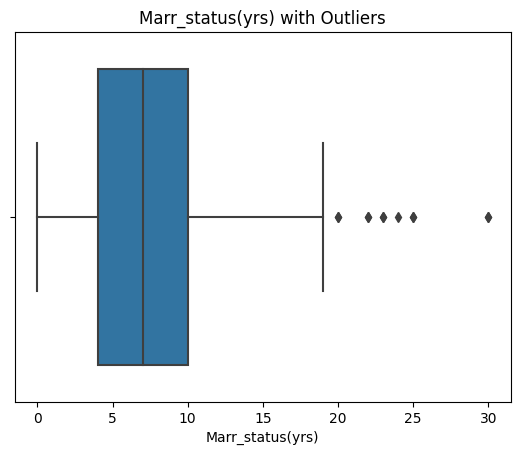

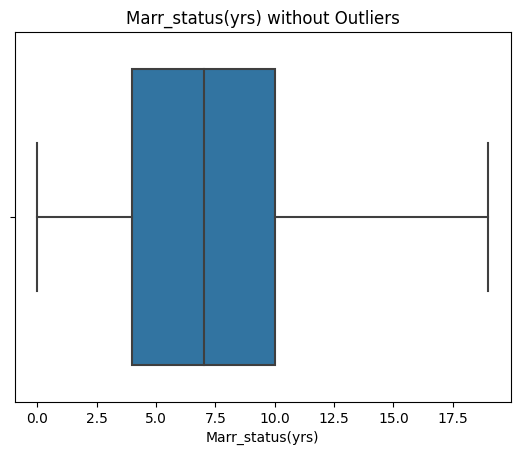

In [58]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Marr_status(yrs)'].quantile(0.25)
Q3 = df['Marr_status(yrs)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Marr_status(yrs)'] < lower_cap) | (df['Marr_status(yrs)'] > upper_cap)
outliers_count = outliers.sum()



# Create box plot with outliers
sns.boxplot(x='Marr_status(yrs)', data=df)
plt.title('Marr_status(yrs) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Marr_status(yrs)'] = df['Marr_status(yrs)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Marr_status(yrs)', data=df)
plt.title('Marr_status(yrs) without Outliers')
plt.show()


In [59]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Marr_status(yrs)'].max()
min_value = df['Marr_status(yrs)'].min()

# print the results
print("Maximum value in 'Marr_status(yrs)':", max_value)
print("Minimum value in 'Marr_status(yrs)':", min_value)

Maximum value in 'Marr_status(yrs)': 19.0
Minimum value in 'Marr_status(yrs)': 0.0


In [60]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['FSH'].max()
min_value = df['FSH'].min()

# print the results
print("Maximum value in 'FSH':", max_value)
print("Minimum value in 'FSH':", min_value)

Maximum value in 'FSH': 5052.0
Minimum value in 'FSH': 0.21


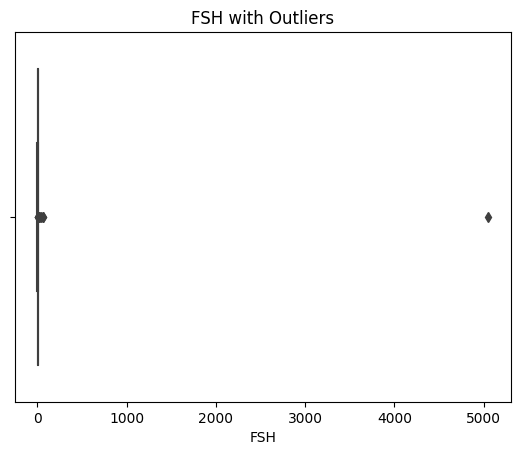

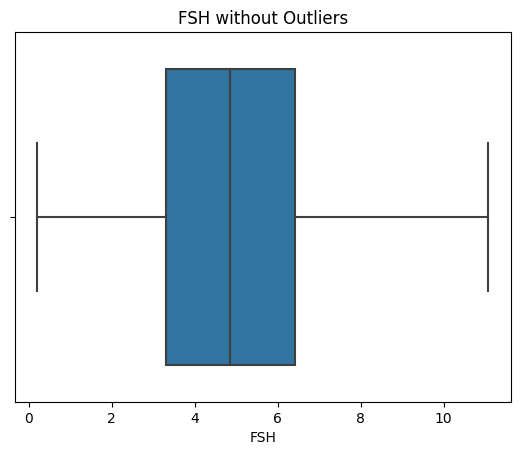

In [61]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['FSH'].quantile(0.25)
Q3 = df['FSH'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['FSH'] < lower_cap) | (df['FSH'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='FSH', data=df)
plt.title('FSH with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['FSH'] = df['FSH'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='FSH', data=df)
plt.title('FSH without Outliers')
plt.show()


In [62]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['FSH'].max()
min_value = df['FSH'].min()

# print the results
print("Maximum value in 'FSH':", max_value)
print("Minimum value in 'FSH':", min_value)

Maximum value in 'FSH': 11.075000000000001
Minimum value in 'FSH': 0.21


In [63]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['LH'].max()
min_value = df['LH'].min()

# print the results
print("Maximum value in 'LH':", max_value)
print("Minimum value in 'LH':", min_value)

Maximum value in 'LH': 2018.0
Minimum value in 'LH': 0.02


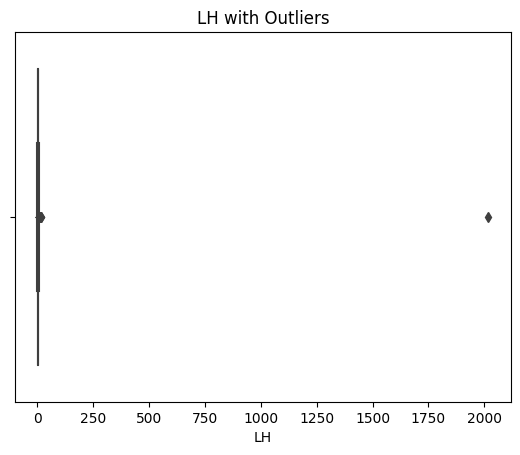

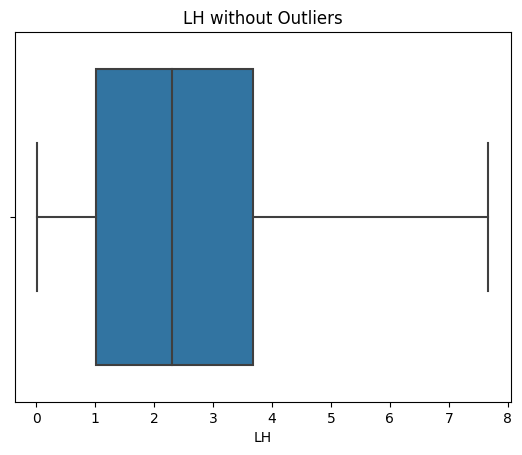

In [64]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['LH'].quantile(0.25)
Q3 = df['LH'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['LH'] < lower_cap) | (df['LH'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='LH', data=df)
plt.title('LH with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['LH'] = df['LH'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='LH', data=df)
plt.title('LH without Outliers')
plt.show()

In [65]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['LH'].max()
min_value = df['LH'].min()

# print the results
print("Maximum value in 'LH':", max_value)
print("Minimum value in 'LH':", min_value)

Maximum value in 'LH': 7.67
Minimum value in 'LH': 0.02


In [66]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['FSH/LH'].max()
min_value = df['FSH/LH'].min()

# print the results
print("Maximum value in 'FSH/LH':", max_value)
print("Minimum value in 'FSH/LH':", min_value)

Maximum value in 'FSH/LH': 1372.83
Minimum value in 'FSH/LH': 0.00214569


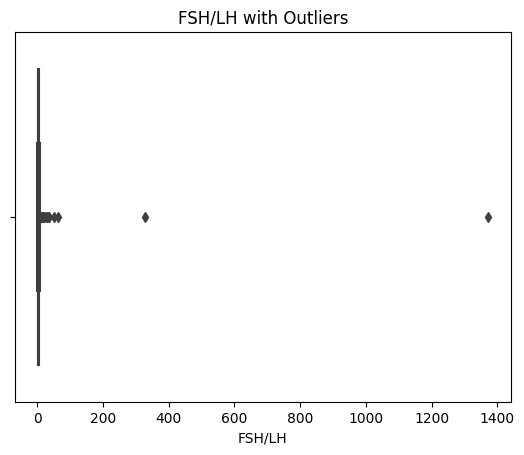

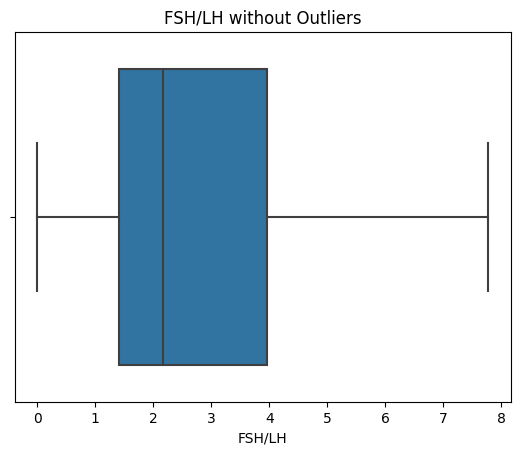

In [67]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['FSH/LH'].quantile(0.25)
Q3 = df['FSH/LH'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['FSH/LH'] < lower_cap) | (df['FSH/LH'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='FSH/LH', data=df)
plt.title('FSH/LH with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['FSH/LH'] = df['FSH/LH'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='FSH/LH', data=df)
plt.title('FSH/LH without Outliers')
plt.show()


In [68]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['FSH/LH'].max()
min_value = df['FSH/LH'].min()

# print the results
print("Maximum value in 'FSH/LH':", max_value)
print("Minimum value in 'FSH/LH':", min_value)

Maximum value in 'FSH/LH': 7.7735899999999996
Minimum value in 'FSH/LH': 0.00214569


In [69]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Hip(inch)'].max()
min_value = df['Hip(inch)'].min()

# print the results
print("Maximum value in 'Hip(inch)':", max_value)
print("Minimum value in 'Hip(inch)':", min_value)

Maximum value in 'Hip(inch)': 48
Minimum value in 'Hip(inch)': 26


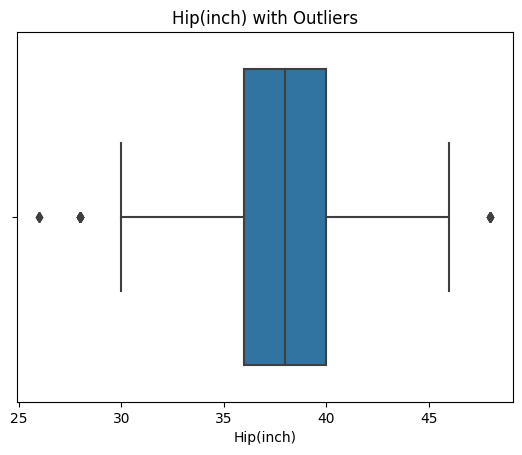

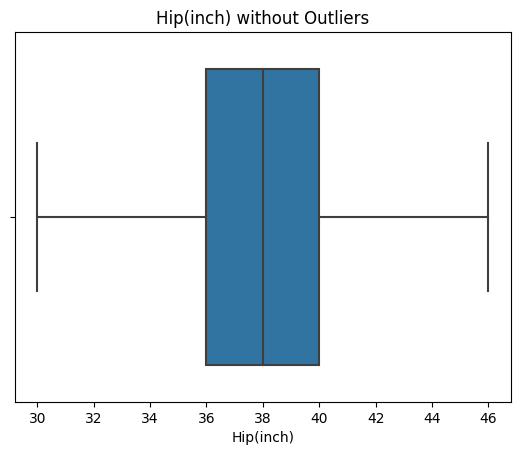

In [70]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Hip(inch)'].quantile(0.25)
Q3 = df['Hip(inch)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Hip(inch)'] < lower_cap) | (df['Hip(inch)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Hip(inch)', data=df)
plt.title('Hip(inch) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Hip(inch)'] = df['Hip(inch)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Hip(inch)', data=df)
plt.title('Hip(inch) without Outliers')
plt.show()


In [71]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Hip(inch)'].max()
min_value = df['Hip(inch)'].min()

# print the results
print("Maximum value in 'Hip(inch)':", max_value)
print("Minimum value in 'Hip(inch)':", min_value)

Maximum value in 'Hip(inch)': 46
Minimum value in 'Hip(inch)': 30


In [72]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Waist(inch)'].max()
min_value = df['Waist(inch)'].min()

# print the results
print("Maximum value in 'Waist(inch)':", max_value)
print("Minimum value in 'Waist(inch)':", min_value)

Maximum value in 'Waist(inch)': 47
Minimum value in 'Waist(inch)': 24


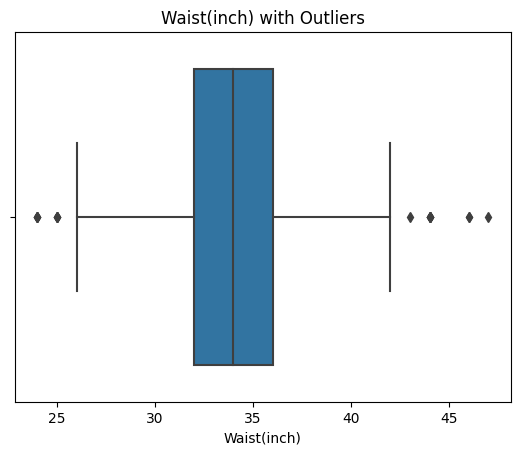

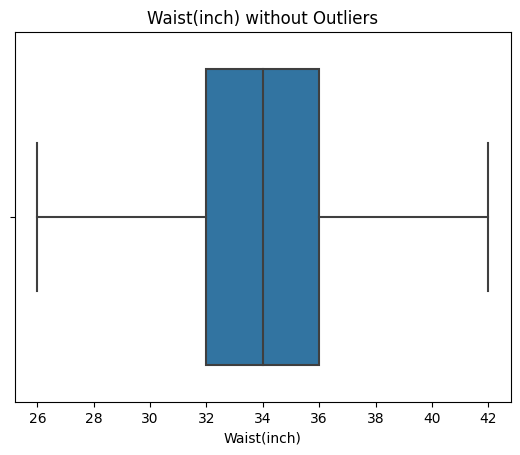

In [73]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Waist(inch)'].quantile(0.25)
Q3 = df['Waist(inch)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Waist(inch)'] < lower_cap) | (df['Waist(inch)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Waist(inch)', data=df)
plt.title('Waist(inch) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Waist(inch)'] = df['Waist(inch)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Waist(inch)', data=df)
plt.title('Waist(inch) without Outliers')
plt.show()

In [74]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Waist(inch)'].max()
min_value = df['Waist(inch)'].min()

# print the results
print("Maximum value in 'Waist(inch)':", max_value)
print("Minimum value in 'Waist(inch)':", min_value)

Maximum value in 'Waist(inch)': 42
Minimum value in 'Waist(inch)': 26


In [75]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['TSH'].max()
min_value = df['TSH'].min()

# print the results
print("Maximum value in 'TSH':", max_value)
print("Minimum value in 'TSH':", min_value)

Maximum value in 'TSH': 65.0
Minimum value in 'TSH': 0.04


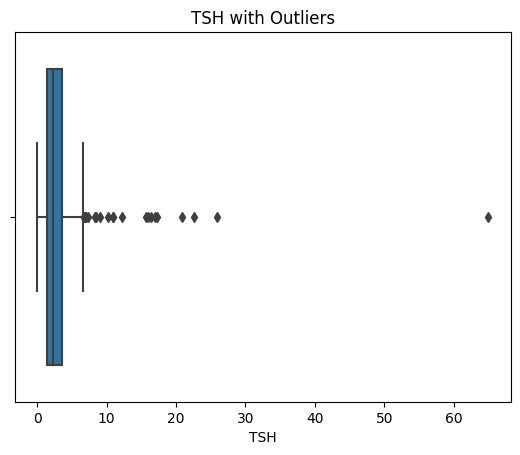

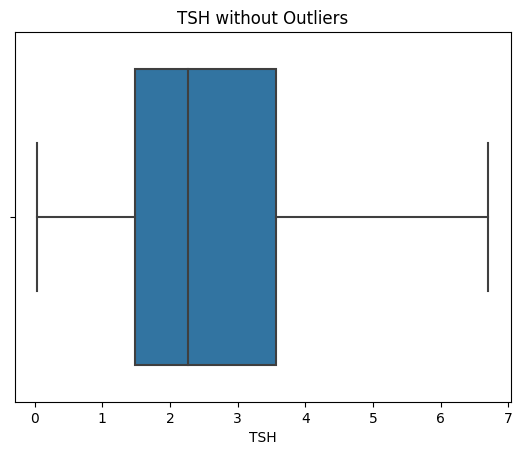

In [76]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['TSH'].quantile(0.25)
Q3 = df['TSH'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['TSH'] < lower_cap) | (df['TSH'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='TSH', data=df)
plt.title('TSH with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['TSH'] = df['TSH'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='TSH', data=df)
plt.title('TSH without Outliers')
plt.show()


In [77]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['TSH'].max()
min_value = df['TSH'].min()

# print the results
print("Maximum value in 'TSH':", max_value)
print("Minimum value in 'TSH':", min_value)

Maximum value in 'TSH': 6.705
Minimum value in 'TSH': 0.04


In [78]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['PRL'].max()
min_value = df['PRL'].min()

# print the results
print("Maximum value in 'PRL':", max_value)
print("Minimum value in 'PRL':", min_value)

Maximum value in 'PRL': 128.24
Minimum value in 'PRL': 0.4


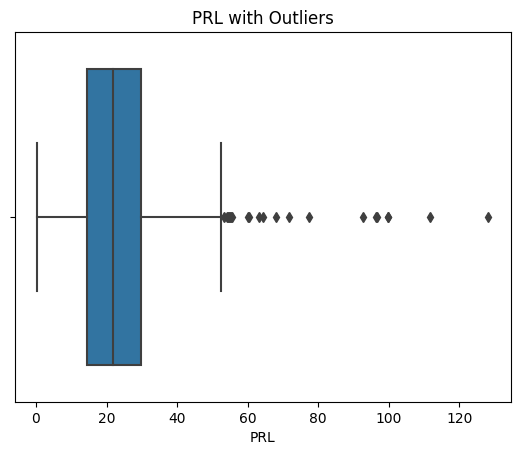

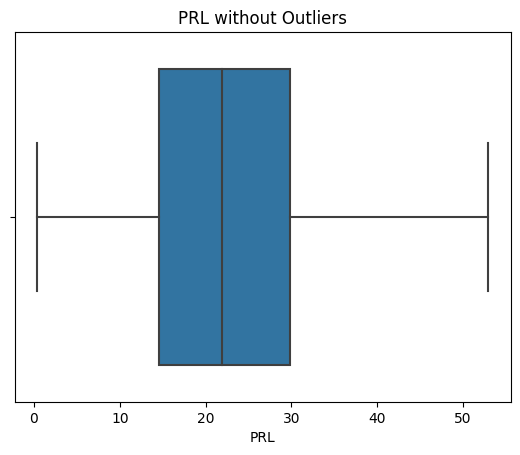

In [79]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['PRL'].quantile(0.25)
Q3 = df['PRL'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['PRL'] < lower_cap) | (df['PRL'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='PRL', data=df)
plt.title('PRL with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['PRL'] = df['PRL'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='PRL', data=df)
plt.title('PRL without Outliers')
plt.show()


In [80]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['PRL'].max()
min_value = df['PRL'].min()

# print the results
print("Maximum value in 'PRL':", max_value)
print("Minimum value in 'PRL':", min_value)

Maximum value in 'PRL': 52.945
Minimum value in 'PRL': 0.4


In [81]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Vit_D3'].max()
min_value = df['Vit_D3'].min()

# print the results
print("Maximum value in 'Vit_D3':", max_value)
print("Minimum value in 'Vit_D3':", min_value)

Maximum value in 'Vit_D3': 6014.66
Minimum value in 'Vit_D3': 0.0


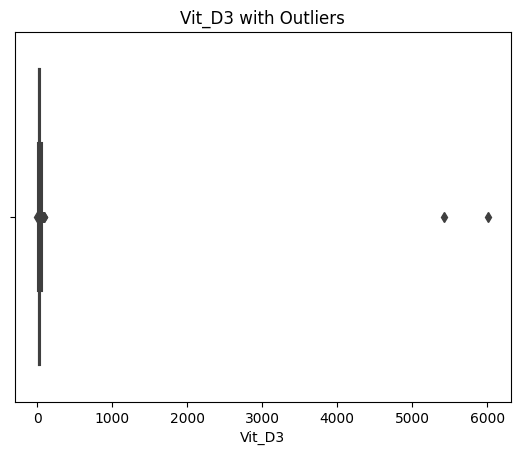

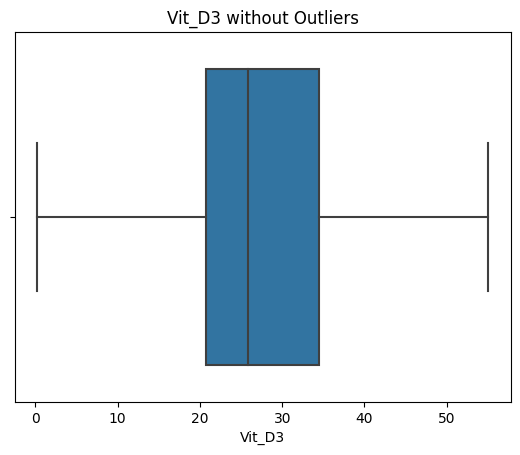

In [82]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['Vit_D3'].quantile(0.25)
Q3 = df['Vit_D3'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Vit_D3'] < lower_cap) | (df['Vit_D3'] > upper_cap)
outliers_count = outliers.sum()

# Create box plot with outliers
sns.boxplot(x='Vit_D3', data=df)
plt.title('Vit_D3 with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Vit_D3'] = df['Vit_D3'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Vit_D3', data=df)
plt.title('Vit_D3 without Outliers')
plt.show()

In [83]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Vit_D3'].max()
min_value = df['Vit_D3'].min()

# print the results
print("Maximum value in 'Vit_D3':", max_value)
print("Minimum value in 'Vit_D3':", min_value)

Maximum value in 'Vit_D3': 55.05
Minimum value in 'Vit_D3': 0.25000000000000355


In [84]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['PRG'].max()
min_value = df['PRG'].min()

# print the results
print("Maximum value in 'PRG':", max_value)
print("Minimum value in 'PRG':", min_value)

Maximum value in 'PRG': 85.0
Minimum value in 'PRG': 0.047


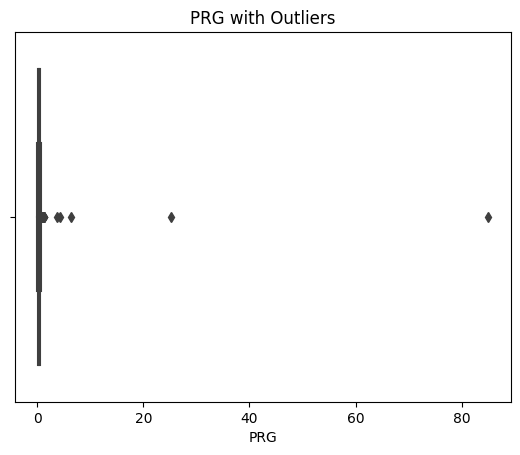

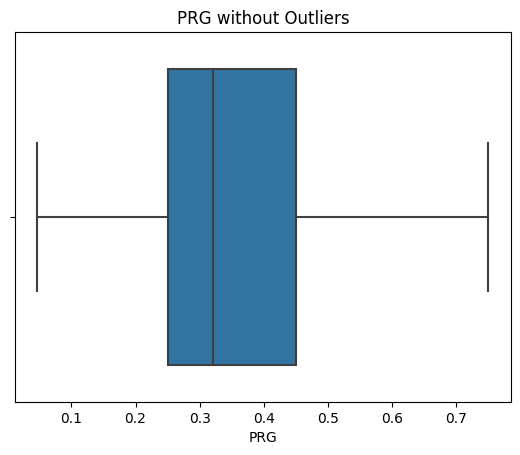

In [85]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['PRG'].quantile(0.25)
Q3 = df['PRG'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['PRG'] < lower_cap) | (df['PRG'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='PRG', data=df)
plt.title('PRG with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['PRG'] = df['PRG'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='PRG', data=df)
plt.title('PRG without Outliers')
plt.show()

In [86]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['PRG'].max()
min_value = df['PRG'].min()

# print the results
print("Maximum value in 'PRG':", max_value)
print("Minimum value in 'PRG':", min_value)

Maximum value in 'PRG': 0.75
Minimum value in 'PRG': 0.047


In [87]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['RBS'].max()
min_value = df['RBS'].min()

# print the results
print("Maximum value in 'RBS':", max_value)
print("Minimum value in 'RBS':", min_value)

Maximum value in 'RBS': 350.0
Minimum value in 'RBS': 60.0


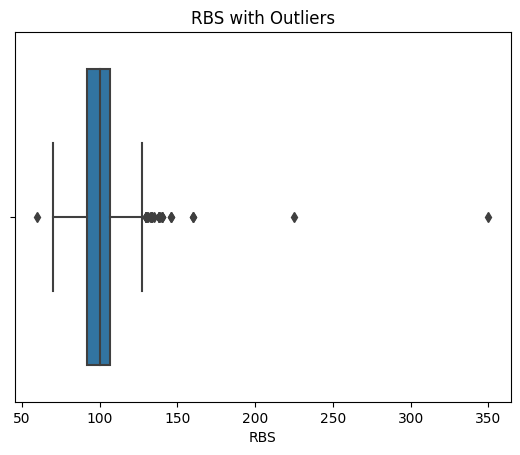

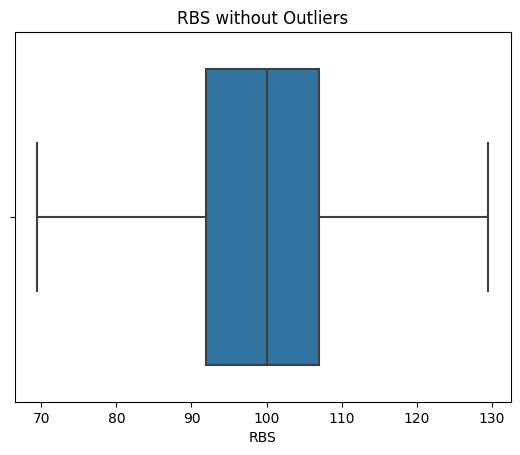

In [88]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['RBS'].quantile(0.25)
Q3 = df['RBS'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['RBS'] < lower_cap) | (df['RBS'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='RBS', data=df)
plt.title('RBS with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['RBS'] = df['RBS'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='RBS', data=df)
plt.title('RBS without Outliers')
plt.show()


In [89]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['RBS'].max()
min_value = df['RBS'].min()

# print the results
print("Maximum value in 'RBS':", max_value)
print("Minimum value in 'RBS':", min_value)

Maximum value in 'RBS': 129.5
Minimum value in 'RBS': 69.5


In [90]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['BP_systolic'].max()
min_value = df['BP_systolic'].min()

# print the results
print("Maximum value in 'BP_systolic':", max_value)
print("Minimum value in 'BP_systolic':", min_value)

Maximum value in 'BP_systolic': 140
Minimum value in 'BP_systolic': 12


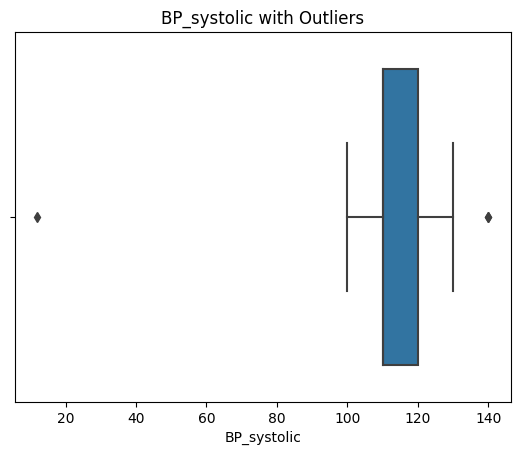

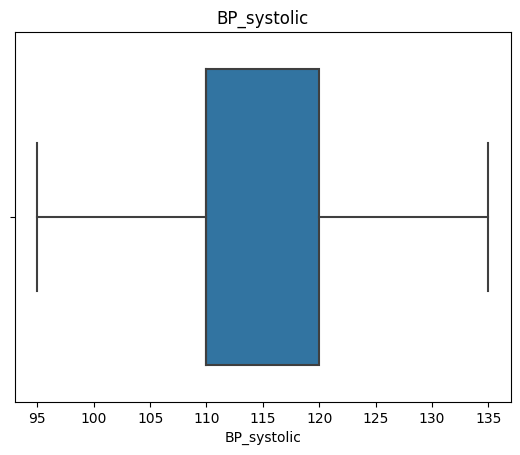

In [91]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['BP_systolic'].quantile(0.25)
Q3 = df['BP_systolic'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['BP_systolic'] < lower_cap) | (df['BP_systolic'] > upper_cap)
outliers_count = outliers.sum()



# Create box plot with outliers
sns.boxplot(x='BP_systolic', data=df)
plt.title('BP_systolic with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['BP_systolic'] = df['BP_systolic'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='BP_systolic', data=df)
plt.title('BP_systolic')
plt.show()


In [92]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['BP_systolic'].max()
min_value = df['BP_systolic'].min()

# print the results
print("Maximum value in 'BP_systolic':", max_value)
print("Minimum value in 'BP_systolic':", min_value)

Maximum value in 'BP_systolic': 135
Minimum value in 'BP_systolic': 95


In [93]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['BP_diastolic'].max()
min_value = df['BP_diastolic'].min()

# print the results
print("Maximum value in 'BP_diastolic':", max_value)
print("Minimum value in 'BP_diastolic':", min_value)

Maximum value in 'BP_diastolic': 100
Minimum value in 'BP_diastolic': 8


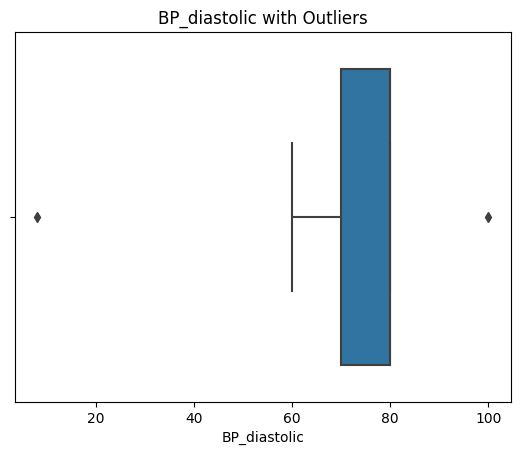

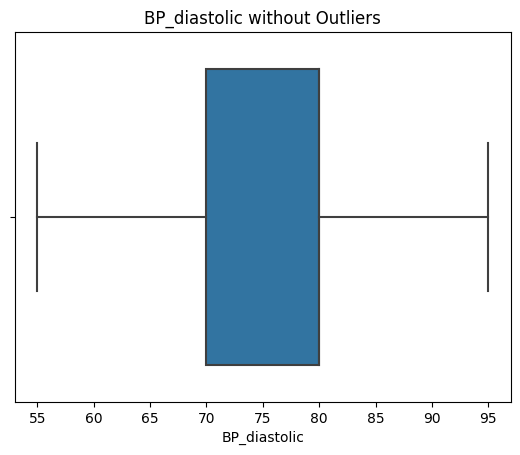

In [94]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['BP_diastolic'].quantile(0.25)
Q3 = df['BP_diastolic'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['BP_diastolic'] < lower_cap) | (df['BP_diastolic'] > upper_cap)
outliers_count = outliers.sum()



# Create box plot with outliers
sns.boxplot(x='BP_diastolic', data=df)
plt.title('BP_diastolic with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['BP_diastolic'] = df['BP_diastolic'].clip(lower=lower_cap, upper=upper_cap)



# Create box plot without outliers
sns.boxplot(x='BP_diastolic', data=df)
plt.title('BP_diastolic without Outliers')
plt.show()


In [95]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['BP_diastolic'].max()
min_value = df['BP_diastolic'].min()

# print the results
print("Maximum value in 'BP_diastolic':", max_value)
print("Minimum value in 'BP_diastolic':", min_value)

Maximum value in 'BP_diastolic': 95
Minimum value in 'BP_diastolic': 55


In [96]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Follicle.no(L)'].max()
min_value = df['Follicle.no(L)'].min()

# print the results
print("Maximum value in 'Follicle.no(L)':", max_value)
print("Minimum value in 'Follicle.no(L)':", min_value)

Maximum value in 'Follicle.no(L)': 22
Minimum value in 'Follicle.no(L)': 0


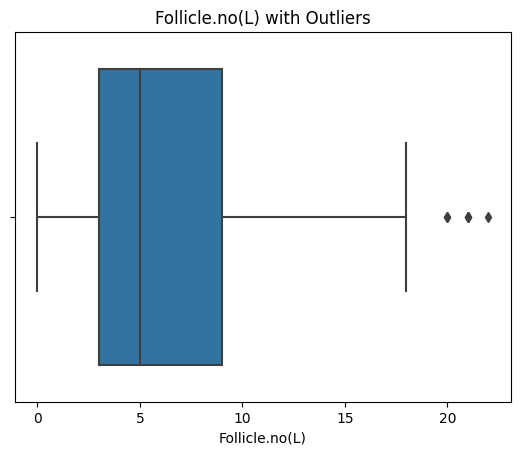

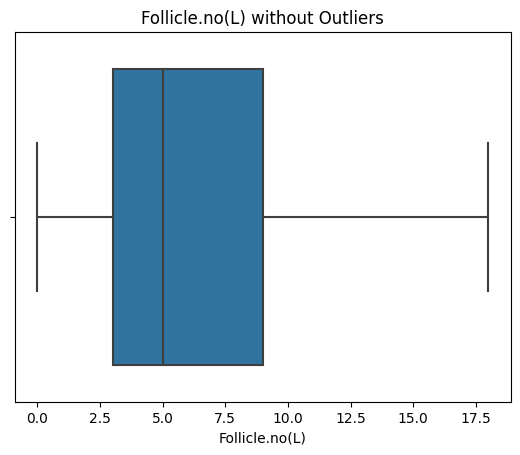

In [97]:
import pandas as pd
import seaborn as sns

# Detect and count outliers
Q1 = df['Follicle.no(L)'].quantile(0.25)
Q3 = df['Follicle.no(L)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Follicle.no(L)'] < lower_cap) | (df['Follicle.no(L)'] > upper_cap)
outliers_count = outliers.sum()

# Create box plot with outliers
sns.boxplot(x='Follicle.no(L)', data=df)
plt.title('Follicle.no(L) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Follicle.no(L)'] = df['Follicle.no(L)'].clip(lower=lower_cap, upper=upper_cap)


# Create box plot without outliers
sns.boxplot(x='Follicle.no(L)', data=df)
plt.title('Follicle.no(L) without Outliers')
plt.show()

In [98]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Follicle.no(L)'].max()
min_value = df['Follicle.no(L)'].min()

# print the results
print("Maximum value in 'Follicle.no(L)':", max_value)
print("Minimum value in 'Follicle.no(L)':", min_value)

Maximum value in 'Follicle.no(L)': 18
Minimum value in 'Follicle.no(L)': 0


In [99]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Avg_F_size(L)(mm)'].max()
min_value = df['Avg_F_size(L)(mm)'].min()

# print the results
print("Maximum value in 'Avg_F_size(L)(mm)':", max_value)
print("Minimum value in 'Avg_F_size(L)(mm)':", min_value)

Maximum value in 'Avg_F_size(L)(mm)': 24
Minimum value in 'Avg_F_size(L)(mm)': 0


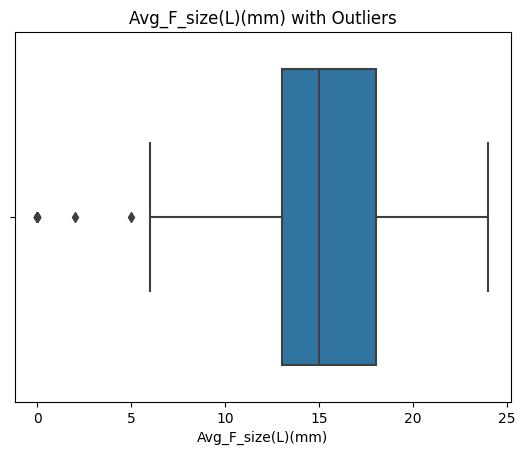

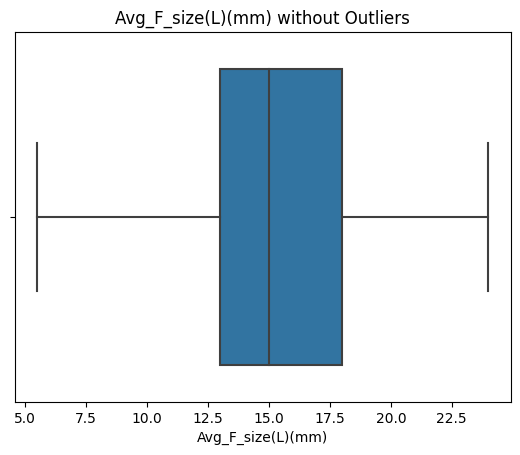

In [100]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Avg_F_size(L)(mm)'].quantile(0.25)
Q3 = df['Avg_F_size(L)(mm)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Avg_F_size(L)(mm)'] < lower_cap) | (df['Avg_F_size(L)(mm)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Avg_F_size(L)(mm)', data=df)
plt.title('Avg_F_size(L)(mm) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Avg_F_size(L)(mm)'] = df['Avg_F_size(L)(mm)'].clip(lower=lower_cap, upper=upper_cap)



# Create box plot without outliers
sns.boxplot(x='Avg_F_size(L)(mm)', data=df)
plt.title('Avg_F_size(L)(mm) without Outliers')
plt.show()


In [101]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Avg_F_size(L)(mm)'].max()
min_value = df['Avg_F_size(L)(mm)'].min()

# print the results
print("Maximum value in 'Avg_F_size(L)(mm)':", max_value)
print("Minimum value in 'Avg_F_size(L)(mm)':", min_value)

Maximum value in 'Avg_F_size(L)(mm)': 24.0
Minimum value in 'Avg_F_size(L)(mm)': 5.5


In [102]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Avg_F_size(R)(mm)'].max()
min_value = df['Avg_F_size(R)(mm)'].min()

# print the results
print("Maximum value in 'Avg_F_size(R)(mm)':", max_value)
print("Minimum value in 'Avg_F_size(R)(mm)':", min_value)

Maximum value in 'Avg_F_size(R)(mm)': 24
Minimum value in 'Avg_F_size(R)(mm)': 0


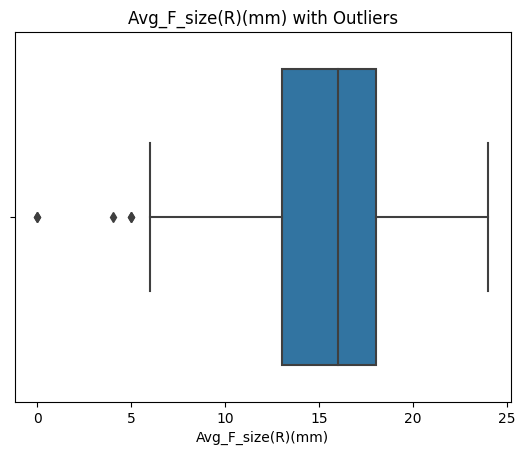

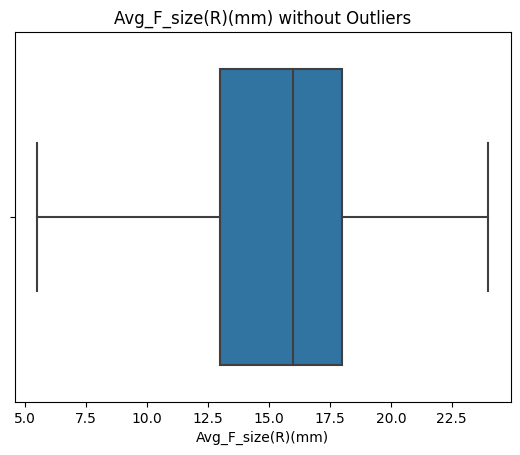

In [103]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Avg_F_size(R)(mm)'].quantile(0.25)
Q3 = df['Avg_F_size(R)(mm)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Avg_F_size(R)(mm)'] < lower_cap) | (df['Avg_F_size(R)(mm)'] > upper_cap)
outliers_count = outliers.sum()


# Create box plot with outliers
sns.boxplot(x='Avg_F_size(R)(mm)', data=df)
plt.title('Avg_F_size(R)(mm) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Avg_F_size(R)(mm)'] = df['Avg_F_size(R)(mm)'].clip(lower=lower_cap, upper=upper_cap)



# Create box plot without outliers
sns.boxplot(x='Avg_F_size(R)(mm)', data=df)
plt.title('Avg_F_size(R)(mm) without Outliers')
plt.show()


In [104]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Avg_F_size(R)(mm)'].max()
min_value = df['Avg_F_size(R)(mm)'].min()

# print the results
print("Maximum value in 'Avg_F_size(R)(mm)':", max_value)
print("Minimum value in 'Avg_F_size(R)(mm)':", min_value)

Maximum value in 'Avg_F_size(R)(mm)': 24.0
Minimum value in 'Avg_F_size(R)(mm)': 5.5


In [105]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Endometrium(mm)'].max()
min_value = df['Endometrium(mm)'].min()

# print the results
print("Maximum value in 'Endometrium(mm)':", max_value)
print("Minimum value in 'Endometrium(mm)':", min_value)

Maximum value in 'Endometrium(mm)': 18
Minimum value in 'Endometrium(mm)': 0


Number of outliers in Endometrium(mm) column: 7


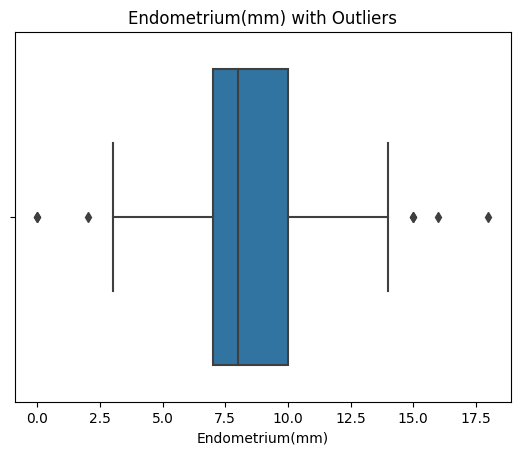

Number of outliers in Endometrium(mm) column after replacing them: 7


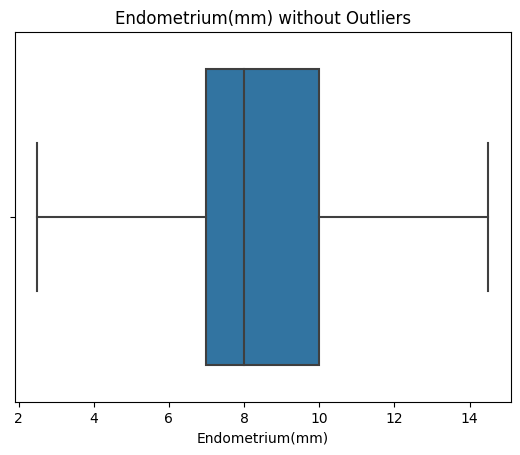

In [106]:
import pandas as pd
import seaborn as sns


# Detect and count outliers
Q1 = df['Endometrium(mm)'].quantile(0.25)
Q3 = df['Endometrium(mm)'].quantile(0.75)
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR
outliers = (df['Endometrium(mm)'] < lower_cap) | (df['Endometrium(mm)'] > upper_cap)
outliers_count = outliers.sum()

print(f"Number of outliers in Endometrium(mm) column: {outliers_count}")

# Create box plot with outliers
sns.boxplot(x='Endometrium(mm)', data=df)
plt.title('Endometrium(mm) with Outliers')
plt.show()

# Replace outliers with upper and lower caps
df['Endometrium(mm)'] = df['Endometrium(mm)'].clip(lower=lower_cap, upper=upper_cap)

print(f"Number of outliers in Endometrium(mm) column after replacing them: {outliers_count}")

# Create box plot without outliers
sns.boxplot(x='Endometrium(mm)', data=df)
plt.title('Endometrium(mm) without Outliers')
plt.show()


In [107]:
import pandas as pd

# check for the minimum and maxium values 
max_value = df['Endometrium(mm)'].max()
min_value = df['Endometrium(mm)'].min()

# print the results
print("Maximum value in 'Endometrium(mm)':", max_value)
print("Minimum value in 'Endometrium(mm)':", min_value)

Maximum value in 'Endometrium(mm)': 14.5
Minimum value in 'Endometrium(mm)': 2.5


## STATISTICAL ANALYSIS


## DESCRIPTIVE STATISTICS

In [108]:
num_cols = ['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)','Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic','Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels','Endometrium(mm)']

In [109]:
df[num_cols].describe()

Age(yrs)  Weight(kg)  Height(cm)         BMI     PR(bpm)     RR(bpm)  \
count  541.000000  541.000000  541.000000  541.000000  541.000000  541.000000   
mean    31.416821   59.481331  156.466906   24.275733   73.146026   19.199630   
std      5.372470   10.543763    5.945107    3.915366    2.079647    1.544668   
min     20.000000   32.500000  140.000000   14.150750   69.000000   16.000000   
25%     28.000000   52.000000  152.000000   21.641300   72.000000   18.000000   
50%     31.000000   59.000000  156.000000   24.238200   72.000000   18.000000   
75%     35.000000   65.000000  160.000000   26.635000   74.000000   20.000000   
max     45.500000   84.500000  172.000000   34.125550   77.000000   23.000000   

         Hb(g/dl)  Cycle_length(days)  Marr_status(yrs)  No_of_abortions  ...  \
count  541.000000          541.000000        541.000000       541.000000  ...   
mean    11.153198            4.847505          7.572458         0.288355  ...   
std      0.842803            1.065163          4.474102         0.692575  ...   
min      8.700000            2.500000          0.000000         0.000000  ...   
25%     10.500000            4.000000          4.000000         0.000000  ...   
50%     11.000000            5.000000          7.000000         0.000000  ...   
75%     11.700000            5.000000         10.000000         0.000000  ...   
max     13.500000            6.500000         19.000000         5.000000  ...   

              PRG         RBS  BP_systolic  BP_diastolic  Follicle.no(L)  \
count  541.000000  541.000000   541.000000    541.000000      541.000000   
mean     0.375935   98.898706   114.796673     77.005545        6.097967   
std      0.158948   13.141931     5.904743      4.772410        4.128449   
min      0.047000   69.500000    95.000000     55.000000        0.000000   
25%      0.250000   92.000000   110.000000     70.000000        3.000000   
50%      0.320000  100.000000   110.000000     80.000000        5.000000   
75%      0.450000  107.000000   120.000000     80.000000        9.000000   
max      0.750000  129.500000   135.000000     95.000000       18.000000   

       Follicle.no(R)  Avg_F_size(L)(mm)  Avg_F_size(R)(mm)  Insulin_levels  \
count      541.000000         541.000000         541.000000      541.000000   
mean         6.641405          15.098891          15.475970       14.105360   
std          4.436889           3.285197           3.232843        6.753736   
min          0.000000           5.500000           5.500000        1.000000   
25%          3.000000          13.000000          13.000000        8.000000   
50%          6.000000          15.000000          16.000000       13.000000   
75%         10.000000          18.000000          18.000000       21.000000   
max         20.000000          24.000000          24.000000       30.000000   

       Endometrium(mm)  
count       541.000000  
mean          8.472274  
std           2.098979  
min           2.500000  
25%           7.000000  
50%           8.000000  
75%          10.000000  
max          14.500000  

[8 rows x 30 columns]

## INFERENTIAL STATISTICS


## NORMALITY TESTING

## CHECKING IF THE CONTINUOUS COLUMNS ARE NORMALLY DISTRIBUTED OR NOT 

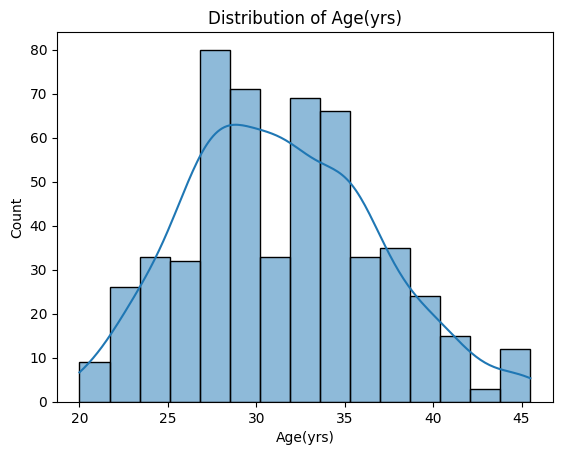

Age(yrs) is not normally distributed (p-value=3.070260208914988e-05)


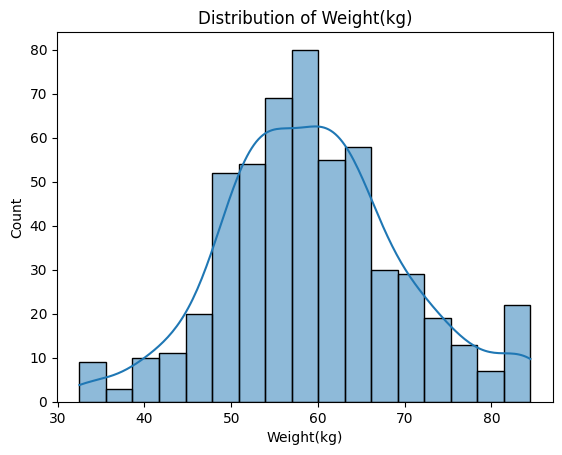

Weight(kg) is not normally distributed (p-value=6.367458263412118e-05)


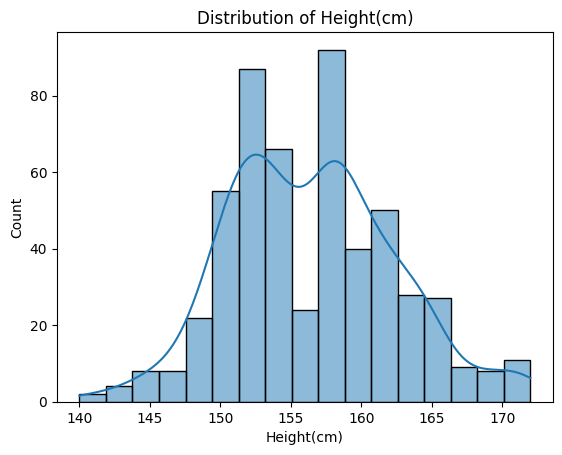

Height(cm) is not normally distributed (p-value=2.288530595251359e-05)


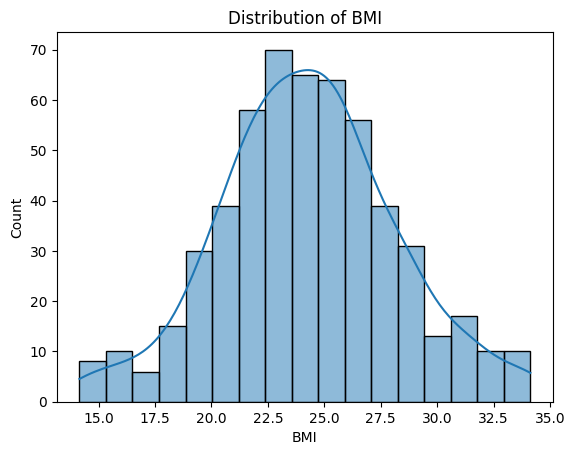

BMI is not normally distributed (p-value=0.022655390202999115)


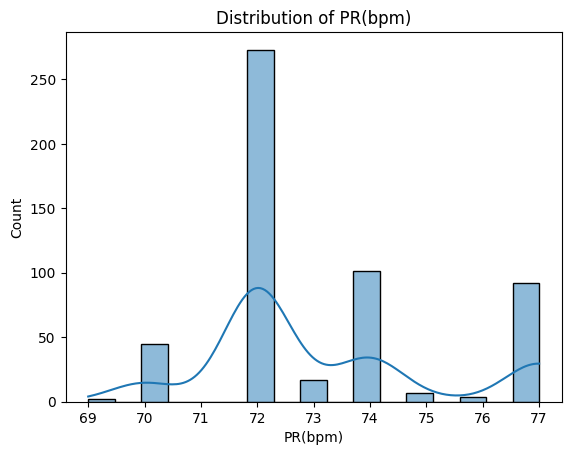

PR(bpm) is not normally distributed (p-value=3.289914231294605e-24)


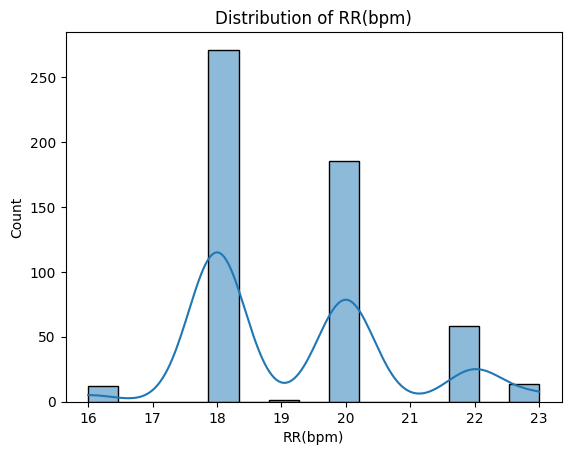

RR(bpm) is not normally distributed (p-value=1.633431561999184e-24)


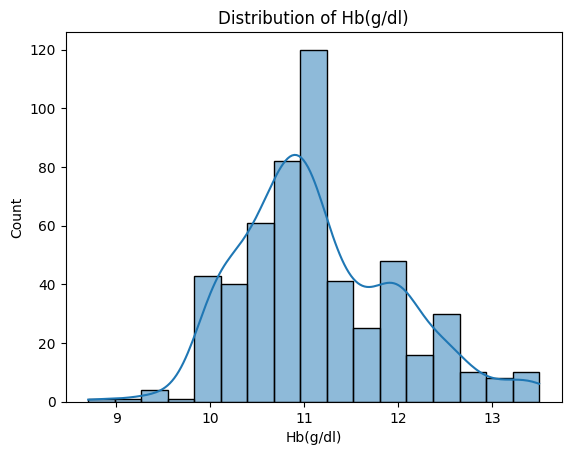

Hb(g/dl) is not normally distributed (p-value=1.5729473279435524e-10)


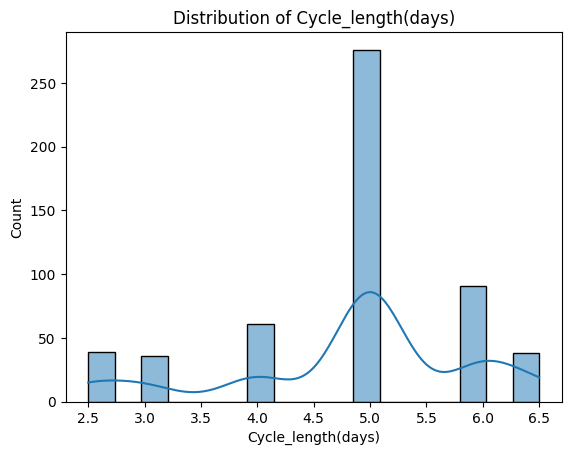

Cycle_length(days) is not normally distributed (p-value=9.698374613467264e-22)


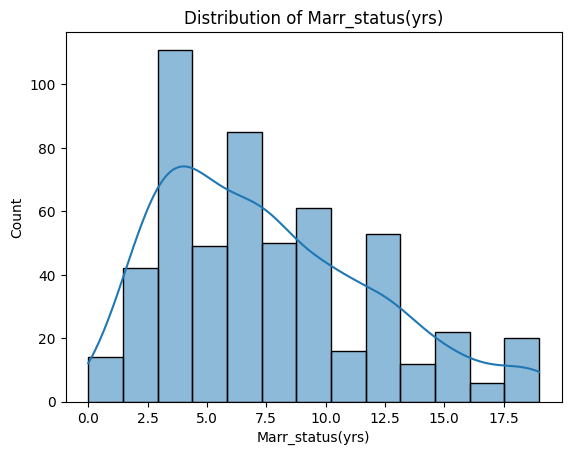

Marr_status(yrs) is not normally distributed (p-value=7.699112072705183e-14)


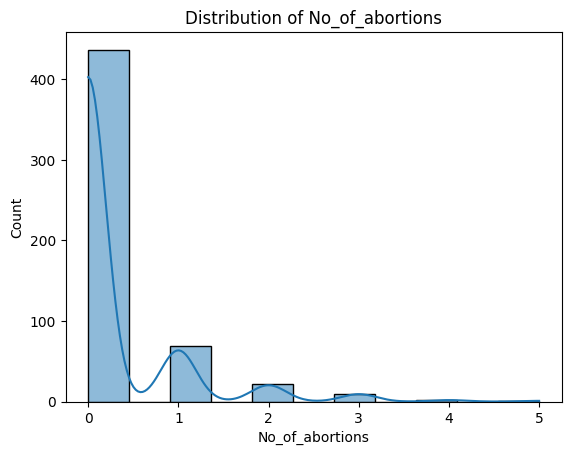

No_of_abortions is not normally distributed (p-value=6.2669524608177e-37)


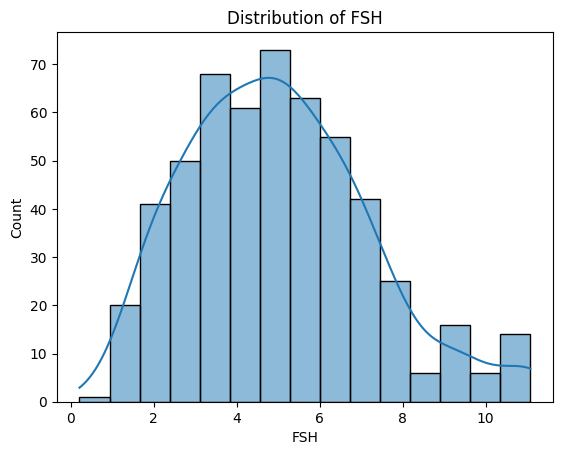

FSH is not normally distributed (p-value=2.349736405449221e-08)


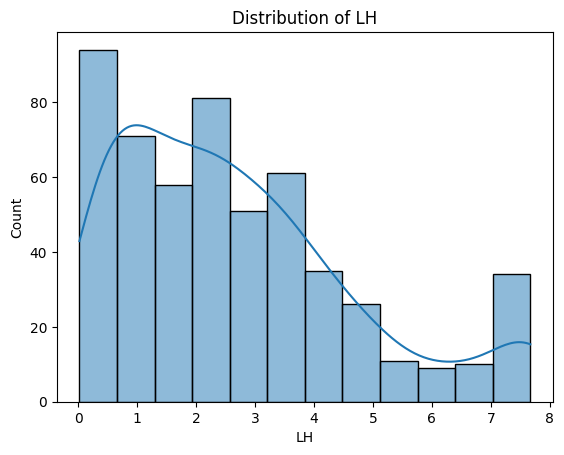

LH is not normally distributed (p-value=2.5650655728310124e-17)


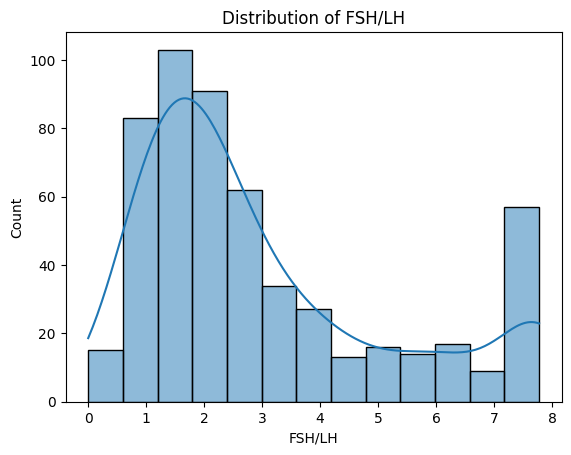

FSH/LH is not normally distributed (p-value=2.0277947247744746e-22)


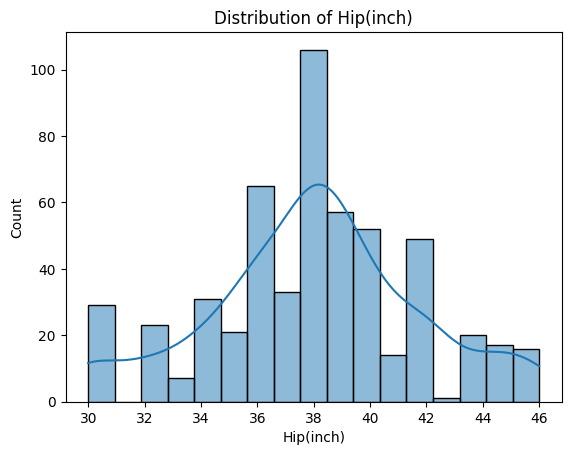

Hip(inch) is not normally distributed (p-value=7.450656092089503e-09)


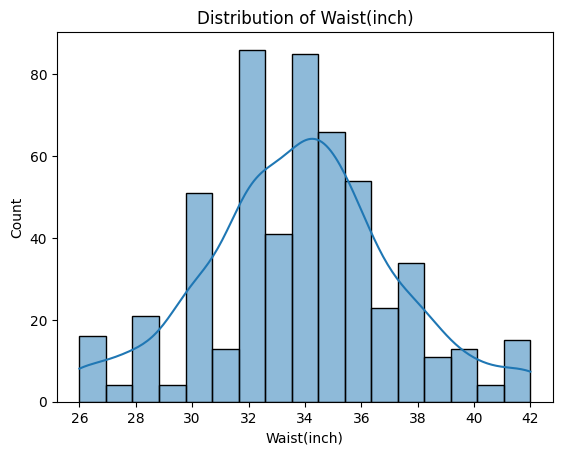

Waist(inch) is not normally distributed (p-value=5.452841946862463e-07)


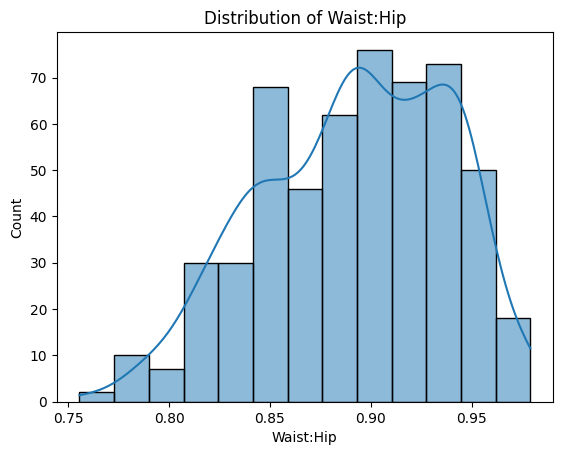

Waist:Hip is not normally distributed (p-value=2.1638982161675813e-08)


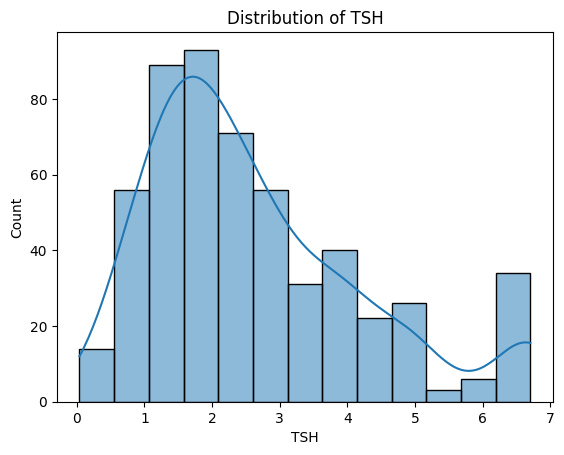

TSH is not normally distributed (p-value=1.985392785113244e-17)


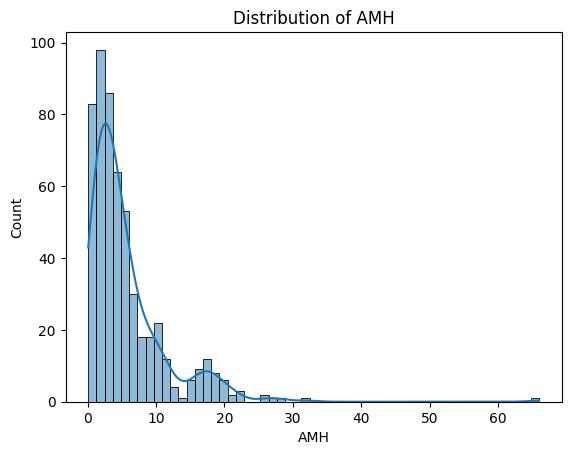

AMH is not normally distributed (p-value=6.381114471630852e-29)


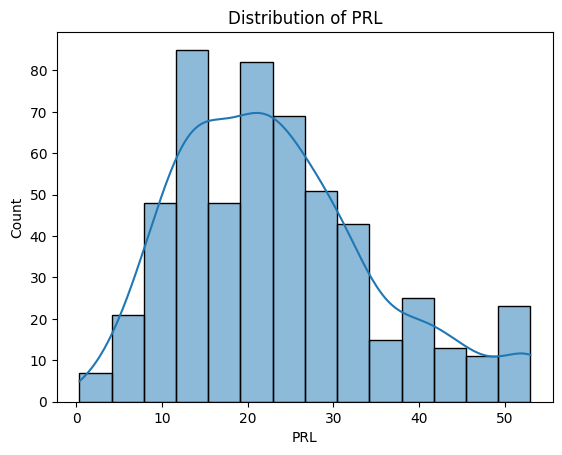

PRL is not normally distributed (p-value=6.403078154498809e-12)


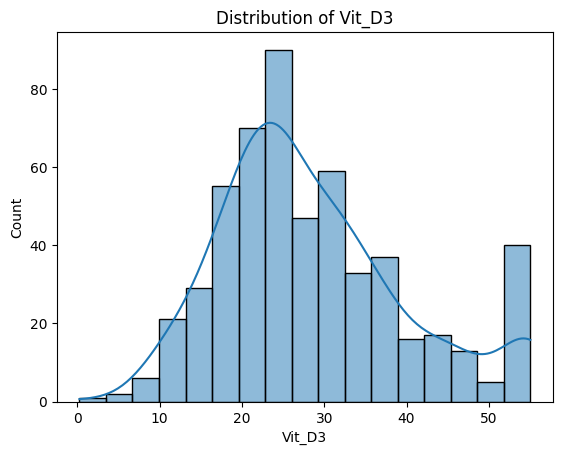

Vit_D3 is not normally distributed (p-value=5.387944322469973e-13)


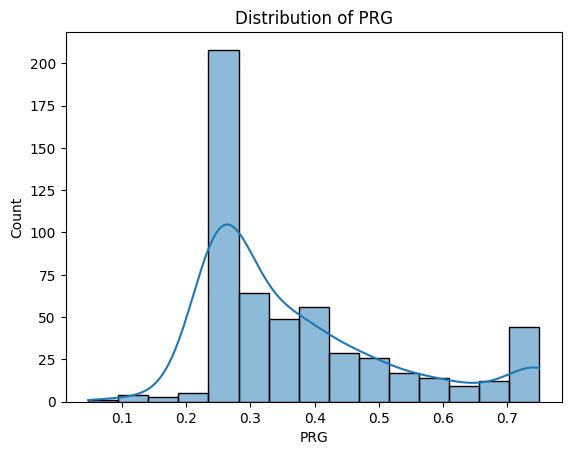

PRG is not normally distributed (p-value=1.4362135746807629e-23)


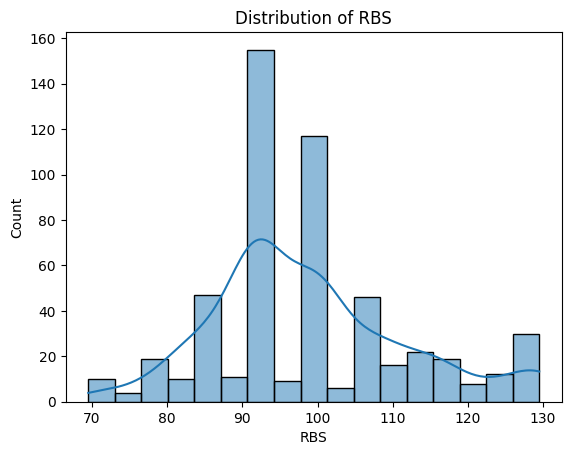

RBS is not normally distributed (p-value=2.6359551477325716e-13)


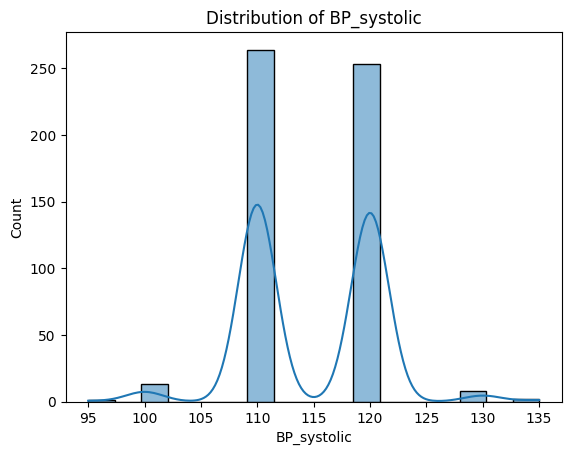

BP_systolic is not normally distributed (p-value=1.5677764045057051e-27)


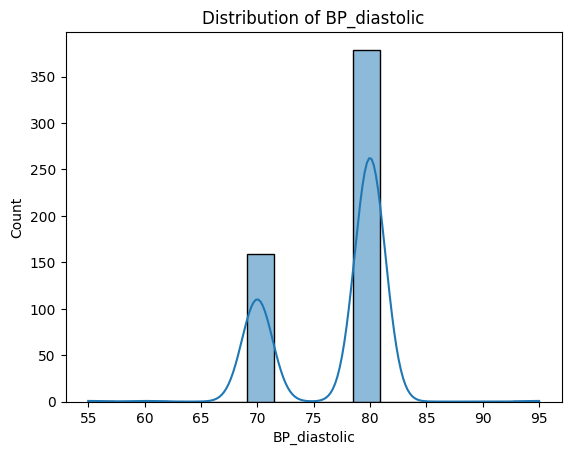

BP_diastolic is not normally distributed (p-value=2.0053393632310816e-33)


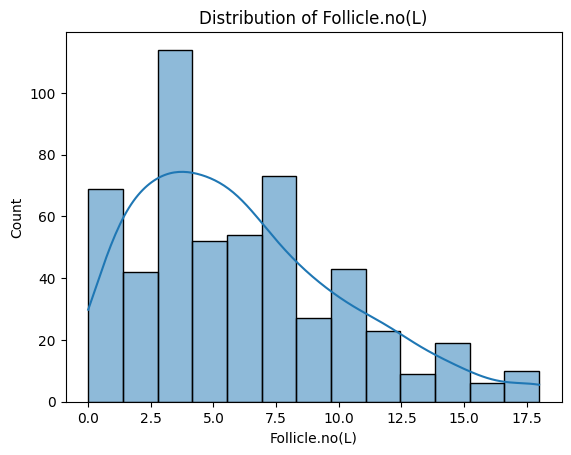

Follicle.no(L) is not normally distributed (p-value=1.9086389912124913e-14)


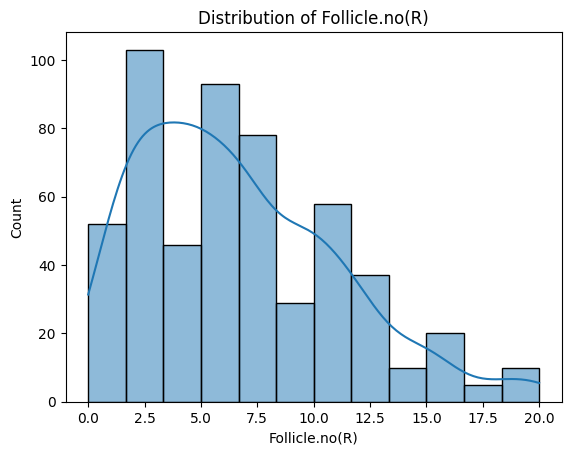

Follicle.no(R) is not normally distributed (p-value=7.425321886219208e-14)


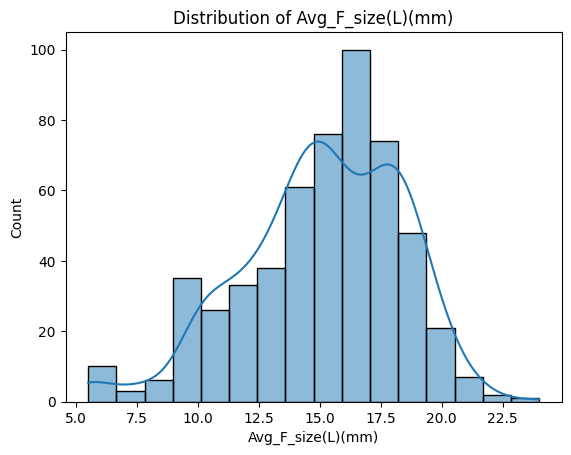

Avg_F_size(L)(mm) is not normally distributed (p-value=1.3562766465469167e-09)


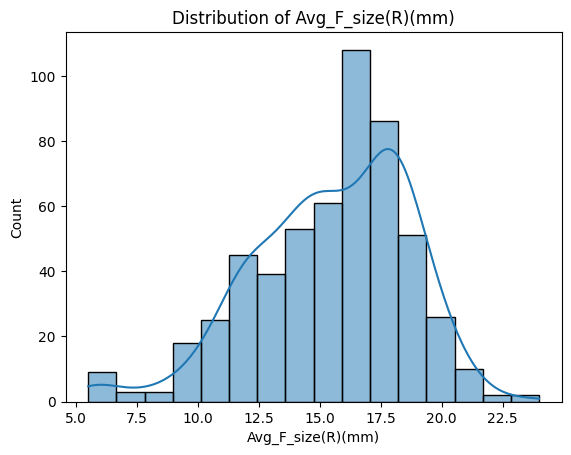

Avg_F_size(R)(mm) is not normally distributed (p-value=4.824391441893283e-10)


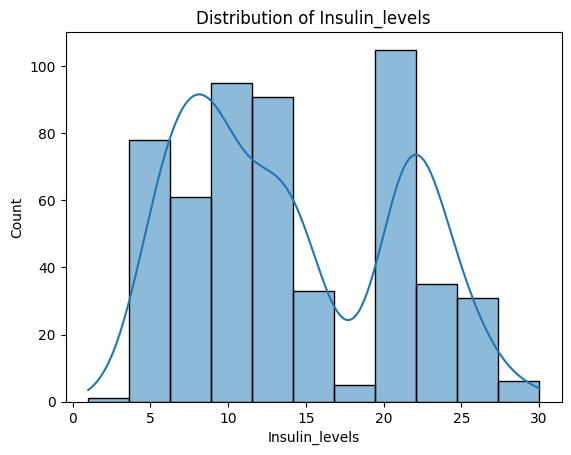

Insulin_levels is not normally distributed (p-value=5.247513699411465e-17)


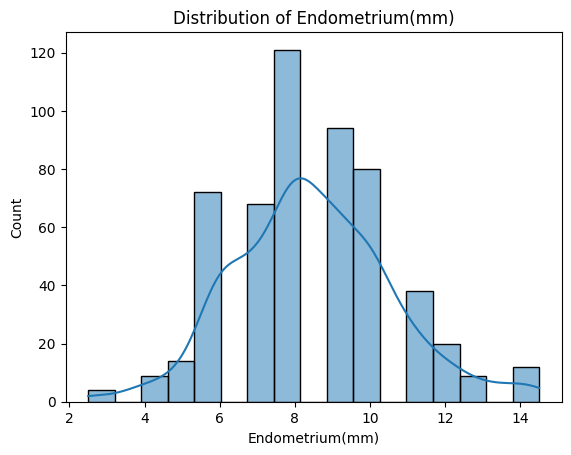

Endometrium(mm) is not normally distributed (p-value=6.339898384055687e-09)
Normally distributed columns: []
Not normally distributed columns: ['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic', 'Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels', 'Endometrium(mm)']


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

norm_cols = []
not_norm_cols = []

# Select the columns of interest
num_cols = df[['Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)','Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic','Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels','Endometrium(mm)']]

# Loop over columns and visualize the distribution using a histogram
for col in num_cols.columns:
    # Visualize the distribution using a histogram
    sns.histplot(num_cols[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    
    # Test for normality using Shapiro-Wilk test
    stats, p_value = str(shapiro(num_cols[col])).split()

    # Print the results
    alpha = 0.05
    if float(p_value[7:-1]) < alpha:
        not_norm_cols.append(col)
        print(f"{col} is not normally distributed (p-value={float(p_value[7:-1])})")
    else:
        norm_cols.append(col)
        print(f"{col} is normally distributed (p-value={float(p_value[7:-1])})")
    
print("Normally distributed columns:", norm_cols)
print("Not normally distributed columns:", not_norm_cols)


## HYPOTHESIS TESTING

## LINEAR REGRESSION


Performed linear regression to get to know the relationship between the outcome variable PCOS(Y/N) and continuous variables.


In [111]:
import pandas as pd
import statsmodels.api as sm

# Select numerical columns and target variable
cont_cols = [ 'Weight(kg)', 'Height(cm)', 'BMI', 'Hb(g/dl)', 'FSH', 'LH', 'FSH/LH', 'Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 
            'RBS',  'Insulin_levels']
target_col = 'PCOS(Y/N)'

# Split data into features (X) and target (y)
X = df[cont_cols]
y = df[target_col]

# Add intercept to X
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())


# Loop through the coefficients and corresponding p-values
rejected_features = []
accepted_features = []
for i, p_value in enumerate(model.pvalues[1:]): # excluding intercept
    if p_value >= 0.05:
        rejected_features.append(cont_cols[i])
    else:
        accepted_features.append(cont_cols[i])

# Print the rejected and accepted features
print("Rejected features:", rejected_features)
print("Accepted features:", accepted_features)

                            OLS Regression Results                            
Dep. Variable:              PCOS(Y/N)   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     148.6
Date:                Fri, 05 May 2023   Prob (F-statistic):          9.39e-178
Time:                        22:43:49   Log-Likelihood:                 90.038
No. Observations:                 541   AIC:                            -148.1
Df Residuals:                     525   BIC:                            -79.38
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4046      1.268     -0.

## MANNWHITNEY U TEST

#This is used to compare the outcome variable PCOS(Y/N) with independant groups to know the level of  significance. 

In [112]:
from scipy.stats import mannwhitneyu

pcos = df["PCOS(Y/N)"]
cols = [ 'Age(yrs)','PR(bpm)', 'RR(bpm)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'Hip(inch)', 'Waist(inch)', 'BP_systolic', 'BP_diastolic', 'Follicle.no(L)', 'Follicle.no(R)', 
            'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)',  'Endometrium(mm)']

for col in cols:
    data = df[col]
    statistic, p_value = mannwhitneyu(data[pcos == 0], data[pcos == 1])      

    if p_value < 0.05:
        print(f"Mann-Whitney U test comparing PCOS(Y/N) and {col}: \nStatistic = {statistic:.4f}, p-value = {p_value:.20f}, Reject null hypothesis")
    else:
        print(f"Mann-Whitney U test comparing PCOS(Y/N) and {col}: \nStatistic = {statistic:.4f}, p-value = {p_value:.20f}, Cannot reject null hypothesis")

    if p_value < 0.05:
        print(f"There is a significant difference between PCOS and {col}\n")
    else:
        print(f"There is no significant difference between PCOS and {col}\n")

Mann-Whitney U test comparing PCOS(Y/N) and Age(yrs): 
Statistic = 39545.0000, p-value = 0.00001673530510128288, Reject null hypothesis
There is a significant difference between PCOS and Age(yrs)

Mann-Whitney U test comparing PCOS(Y/N) and PR(bpm): 
Statistic = 27662.5000, p-value = 0.00400591641434245183, Reject null hypothesis
There is a significant difference between PCOS and PR(bpm)

Mann-Whitney U test comparing PCOS(Y/N) and RR(bpm): 
Statistic = 30524.0000, p-value = 0.27787314565049081594, Cannot reject null hypothesis
There is no significant difference between PCOS and RR(bpm)

Mann-Whitney U test comparing PCOS(Y/N) and Cycle_length(days): 
Statistic = 41380.0000, p-value = 0.00000000688460551371, Reject null hypothesis
There is a significant difference between PCOS and Cycle_length(days)

Mann-Whitney U test comparing PCOS(Y/N) and Marr_status(yrs): 
Statistic = 37291.5000, p-value = 0.00284773182608517644, Reject null hypothesis
There is a significant difference between PC

In [113]:
# Null hypothesis: There is no relationship between  AMH, PRG, TSH, Vit D, RBS, Size of endometrium, follicle size, hip: waist ratio, Menstrual cycle length, Weight gain, hair loss, skin darkening, pimples, exercise factors to PCOS.
# We cannot predict PCOS based on the  AMH, PRG, TSH, FSH, LH, Vit D, RBS, Size of endometrium, follicle size, hip: waist ratio, Menstrual cycle length, Weight gain, hair loss, skin darkening, pimples, exercise.

# Alternative hypothesis: There is a relationship between  AMH, PRG, TSH, Vit D, RBS, Size of endometrium, follicle size, hip: waist ratio, Menstrual cycle length, Weight gain, hair loss, skin darkening, pimples, exercise factors to PCOS.
# We can predict PCOS based on the AMH, PRG, TSH, FSH, LH, Vit D, RBS, Size of endometrium, follicle size, hip: waist ratio, Menstrual cycle length, Weight gain, hair loss, skin darkening, pimples, exercise.

## Chi Square TEST

#This is used to compare the outcome variable PCOS(Y/N) with independant categorical columns to know the level of  significance 

In [114]:
import pandas as pd
from scipy.stats import chi2_contingency, chi2
 
# Separate categorical and numerical columns
cat_cols = ['Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)']
cat_data = df[cat_cols]

# Create a dictionary to store the p-values
p_values = {}

# Set the level of significance
alpha = 0.05

# Loop through the categorical columns and perform chi-square test
for col in cat_cols:
    contingency_table = pd.crosstab(cat_data[col], df['PCOS(Y/N)'])
    chi_square_statistic, p_value, ddof, expected = chi2_contingency(contingency_table)
    p_values[col] = p_value
    critical_value = chi2.ppf(q=1-alpha, df=ddof)
    print(f"\nChi-square test for {col}:")
    print(f"chi-square statistic: {chi_square_statistic:.4f}")
    print(f"p-value: {p_value: }")
    print(f"degree of freedom: {ddof}")
    print(f"critical value: {critical_value:.4f}")
    
    if chi_square_statistic >= critical_value:
        print("Reject H0, there is a relationship between PCOS(Y/N) categorical variables",col)
    else:
        print("Fail to reject H0, there is no relationship between PCOS(Y/N) categorical variables", col)
    if p_value <= alpha:
        print("Reject H0 because there is a relationship between PCOS(Y/N) categorical variables", col)
    else:
        print("Fail to reject H0 because there is no relationship between PCOS(Y/N) categorical variables", col)



Chi-square test for Blood_group:
chi-square statistic: 2.0488
p-value:  0.9570901598044939
degree of freedom: 7
critical value: 14.0671
Fail to reject H0, there is no relationship between PCOS(Y/N) categorical variables Blood_group
Fail to reject H0 because there is no relationship between PCOS(Y/N) categorical variables Blood_group

Chi-square test for Cycle(R/I):
chi-square statistic: 87.3948
p-value:  1.0530565295416136e-19
degree of freedom: 2
critical value: 5.9915
Reject H0, there is a relationship between PCOS(Y/N) categorical variables Cycle(R/I)
Reject H0 because there is a relationship between PCOS(Y/N) categorical variables Cycle(R/I)

Chi-square test for Pregnant_status(Y/N):
chi-square statistic: 0.2990
p-value:  0.5845296923733834
degree of freedom: 1
critical value: 3.8415
Fail to reject H0, there is no relationship between PCOS(Y/N) categorical variables Pregnant_status(Y/N)
Fail to reject H0 because there is no relationship between PCOS(Y/N) categorical variables Preg

## CORRELATION

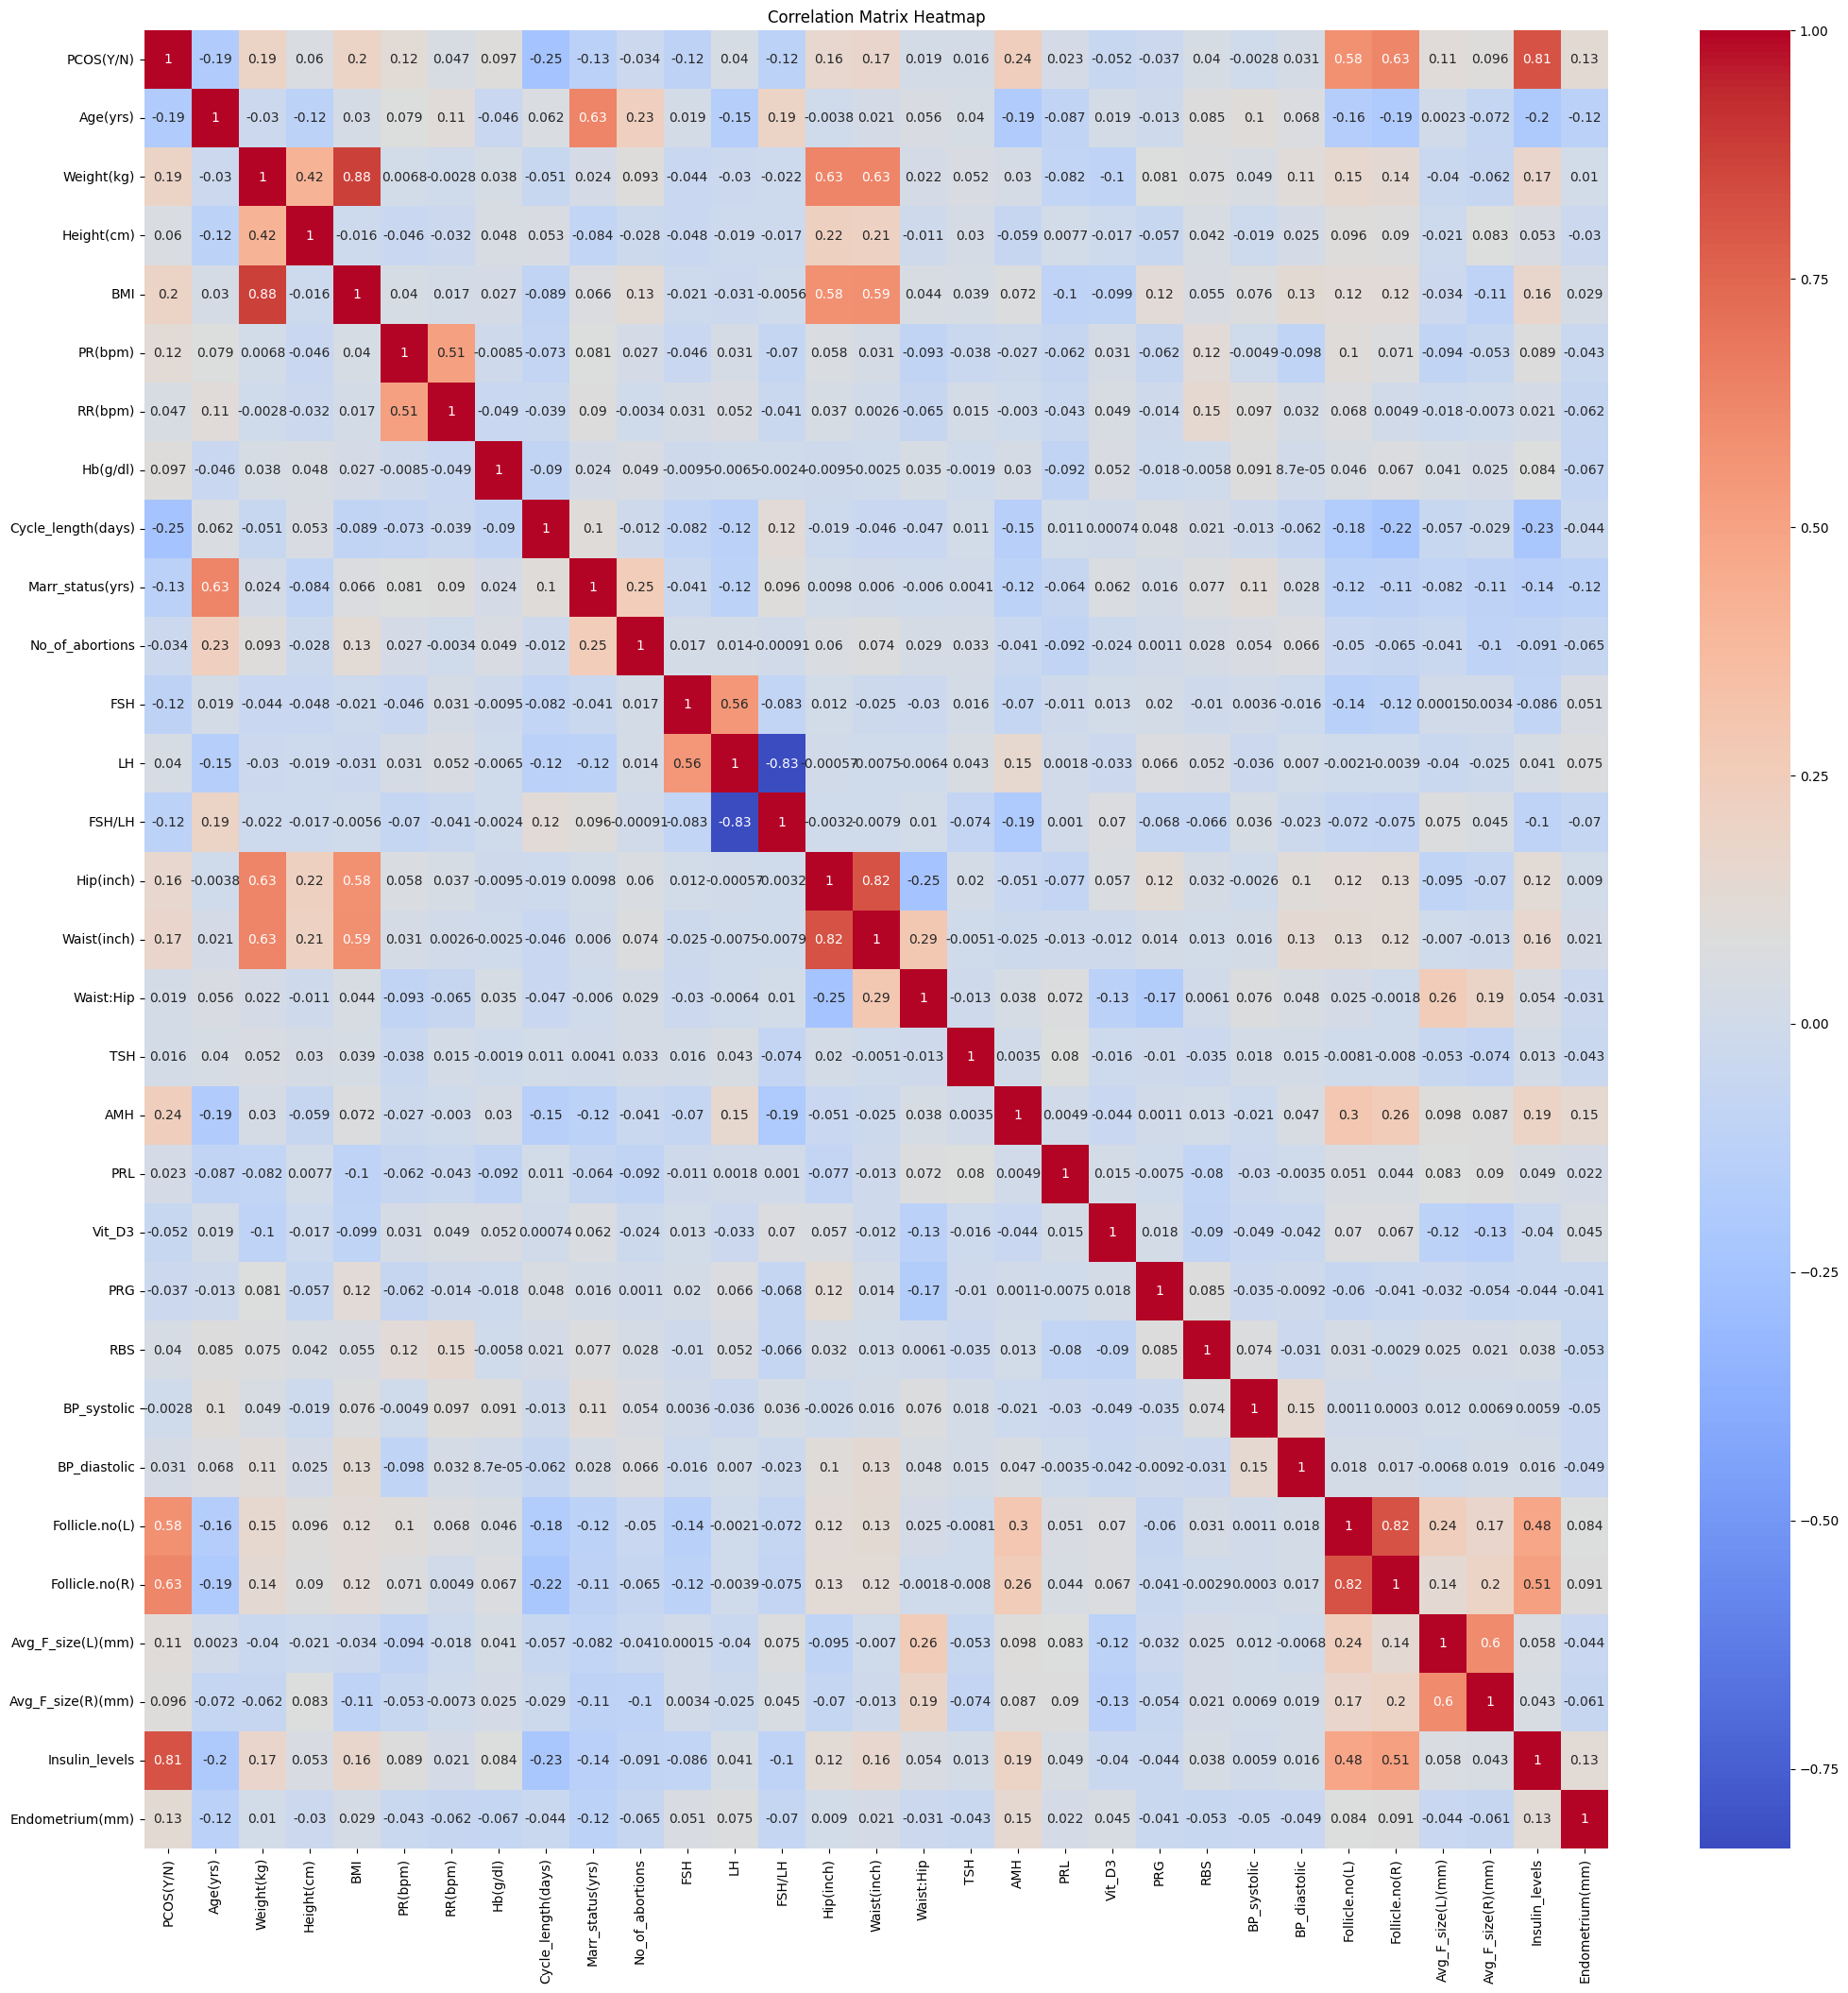

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['PCOS(Y/N)', 'Age(yrs)', 'Weight(kg)', 'Height(cm)', 'BMI', 'PR(bpm)', 'RR(bpm)', 'Hb(g/dl)', 'Cycle_length(days)', 'Marr_status(yrs)', 'No_of_abortions', 'FSH', 'LH', 'FSH/LH', 'Hip(inch)', 'Waist(inch)','Waist:Hip', 'TSH', 'AMH', 'PRL', 'Vit_D3', 'PRG', 'RBS', 'BP_systolic', 'BP_diastolic','Follicle.no(L)', 'Follicle.no(R)', 'Avg_F_size(L)(mm)', 'Avg_F_size(R)(mm)', 'Insulin_levels','Endometrium(mm)']


# Calculate the correlation matrix using Spearman method
correlation_matrix = df[num_cols].corr(method='spearman')

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(25, 25))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)

# Add a title to the plot
ax.set_title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

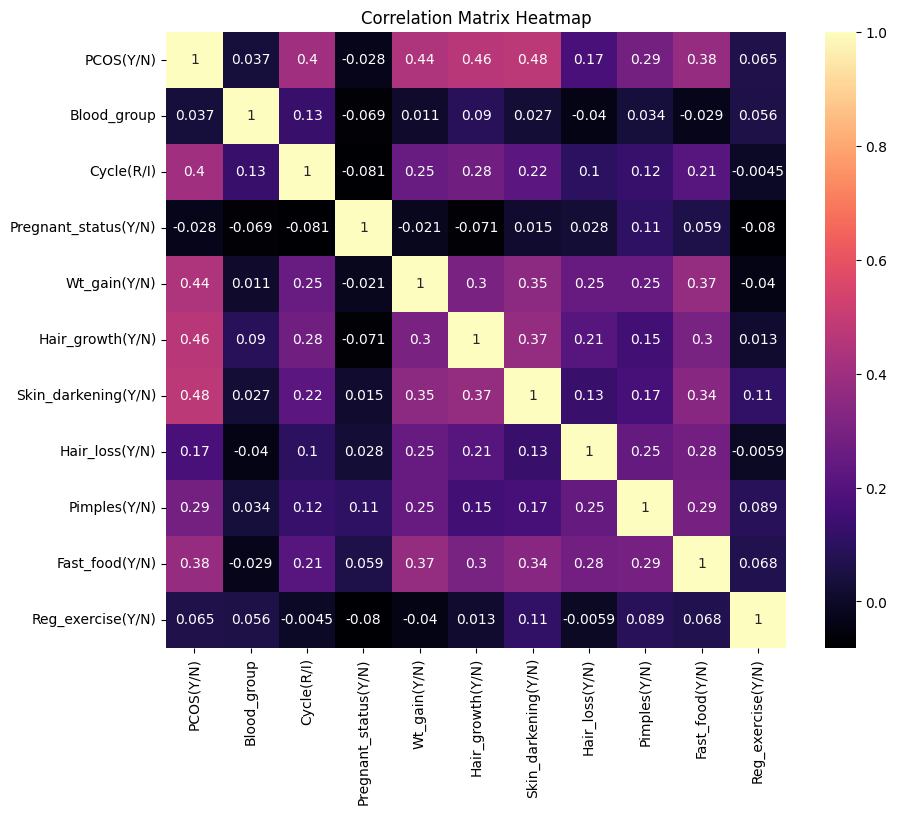

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = ['PCOS(Y/N)', 'Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)']

# Calculate the correlation matrix using Spearman method
correlation_matrix = df[cat_cols].corr(method='spearman')

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(10,8))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='magma', ax=ax)

# Add a title to the plot
ax.set_title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

## DATA VISUALISATION

Bar Charts representing PCOS(Y/N) vs Categorical columns

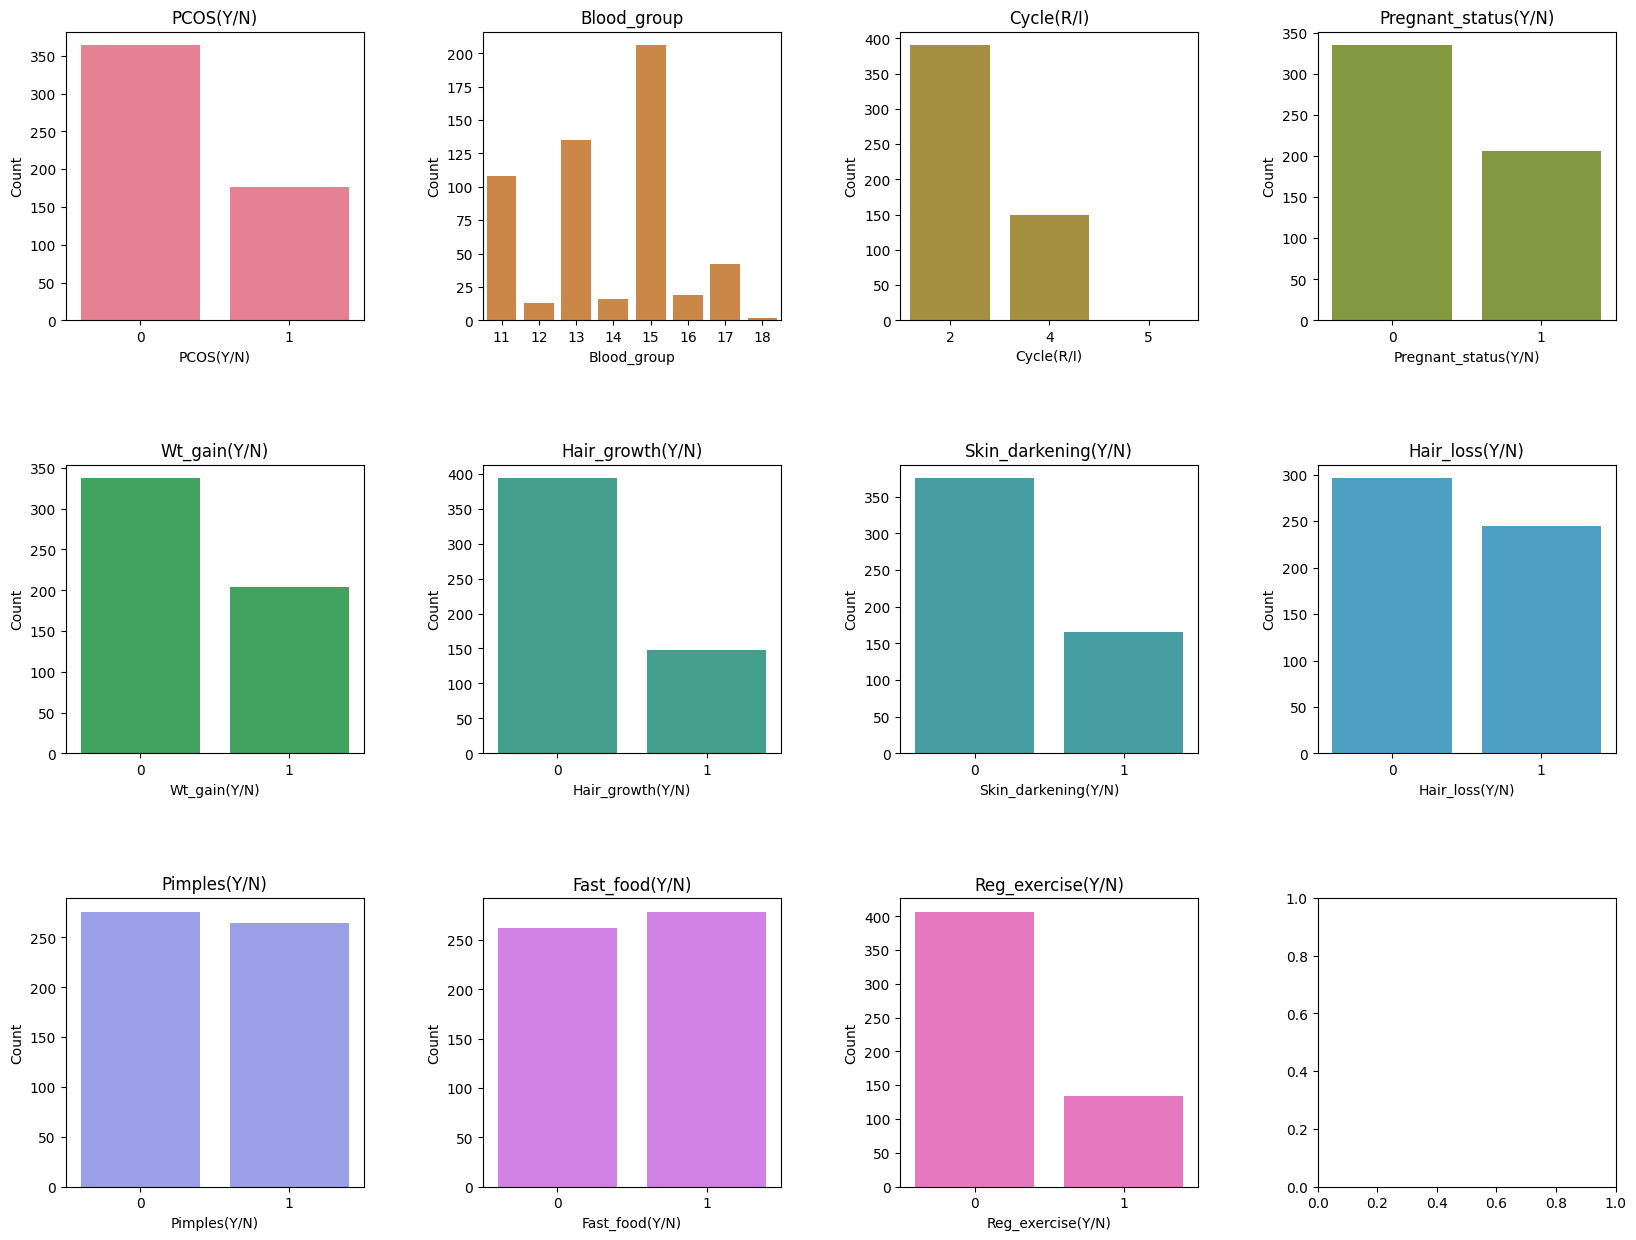

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cat_cols = ['PCOS(Y/N)', 'Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 'Fast_food(Y/N)', 'Reg_exercise(Y/N)']

# set up plot
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# create a color palette with different colors for each subplot
colors = sns.color_palette("husl", n_colors=len(cat_cols))

# create bar plot for each categorical variable with a different color
for i in range(len(cat_cols)):
    row = i // 4
    col = i % 4
    sns.countplot(ax=axes[row, col], x=df[cat_cols[i]], palette=[colors[i]])
    axes[row, col].set_title(cat_cols[i])
    axes[row, col].set_ylabel('Count')

# adjust spacing and show plot
fig.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

Scatter plot depicting the correlation between Age, BMI, and  PCOS(Y/N) status.

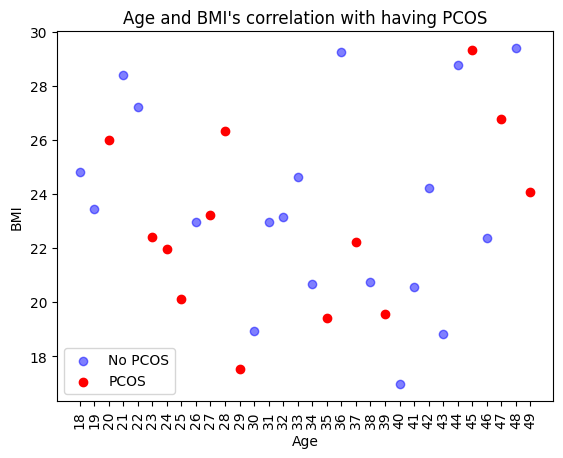

<Figure size 10000x600 with 0 Axes>

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# generate some sample data
ages = np.arange(18, 50)
bmi = np.random.normal(loc=25, scale=4, size=len(ages))
pcos = np.random.randint(0, 2, size=len(ages))

# Ages and BMI for people who don't have PCOS
plt.scatter(ages[pcos==0], 
            bmi[pcos==0],
            c="blue",
            alpha=0.5)

# Ages and BMI for people who have PCOS
plt.scatter(ages[pcos==1], 
            bmi[pcos==1],
            c="red")

# Styling
plt.title("Age and BMI's correlation with having PCOS")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.legend(["No PCOS", "PCOS"])

# set the x-tick labels to consecutive age numbers and rotate them by 45 degrees
plt.xticks(ages, rotation=90)

# set the figure size
plt.figure(figsize=(100, 6))

plt.show()


stacked bar chart comparing the count of PCOS (yes/no) across different blood groups.

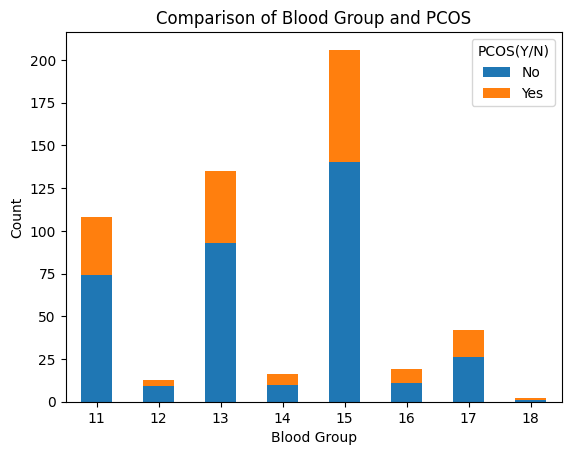

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a crosstab table of 'Blood_group' and 'PCOS(Y/N)' columns
ct = pd.crosstab(df['Blood_group'], df['PCOS(Y/N)'])

# Plot a stacked bar chart to compare the two columns
ct.plot(kind='bar', stacked=True, rot=0)

# Add chart labels and title
plt.xlabel('Blood Group')
plt.ylabel('Count')
plt.title('Comparison of Blood Group and PCOS')

# Add a legend
plt.legend(title='PCOS(Y/N)', labels=['No', 'Yes'])

# Show the plot
plt.show()

Density Plots showing the distribution of "No of Abortions", "AMH" and "PRG" for pregnant and non-pregnant individuals.

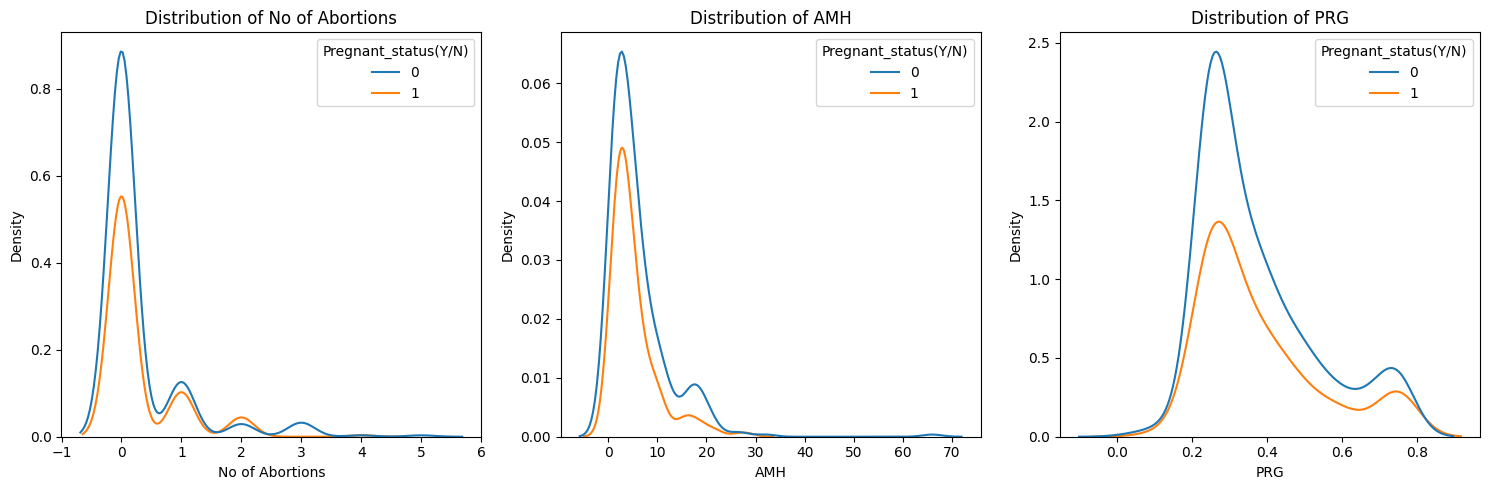

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the data for pregnant and non-pregnant individuals
pregnant = df[df['Pregnant_status(Y/N)']=='Y']
non_pregnant = df[df['Pregnant_status(Y/N)']=='N']

# Create density plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.kdeplot(x='No_of_abortions', hue='Pregnant_status(Y/N)', data=df, ax=axs[0])
sns.kdeplot(x='AMH', hue='Pregnant_status(Y/N)', data=df, ax=axs[1])
sns.kdeplot(x='PRG', hue='Pregnant_status(Y/N)', data=df, ax=axs[2])

# Set axis labels and title
axs[0].set_xlabel('No of Abortions')
axs[0].set_ylabel('Density')
axs[0].set_title('Distribution of No of Abortions')

axs[1].set_xlabel('AMH')
axs[1].set_ylabel('Density')
axs[1].set_title('Distribution of AMH')

axs[2].set_xlabel('PRG')
axs[2].set_ylabel('Density')
axs[2].set_title('Distribution of PRG')

plt.tight_layout()
plt.show()

Bar graphs for each categorical variable against the PCOS(Y/N) variable in a dataset.

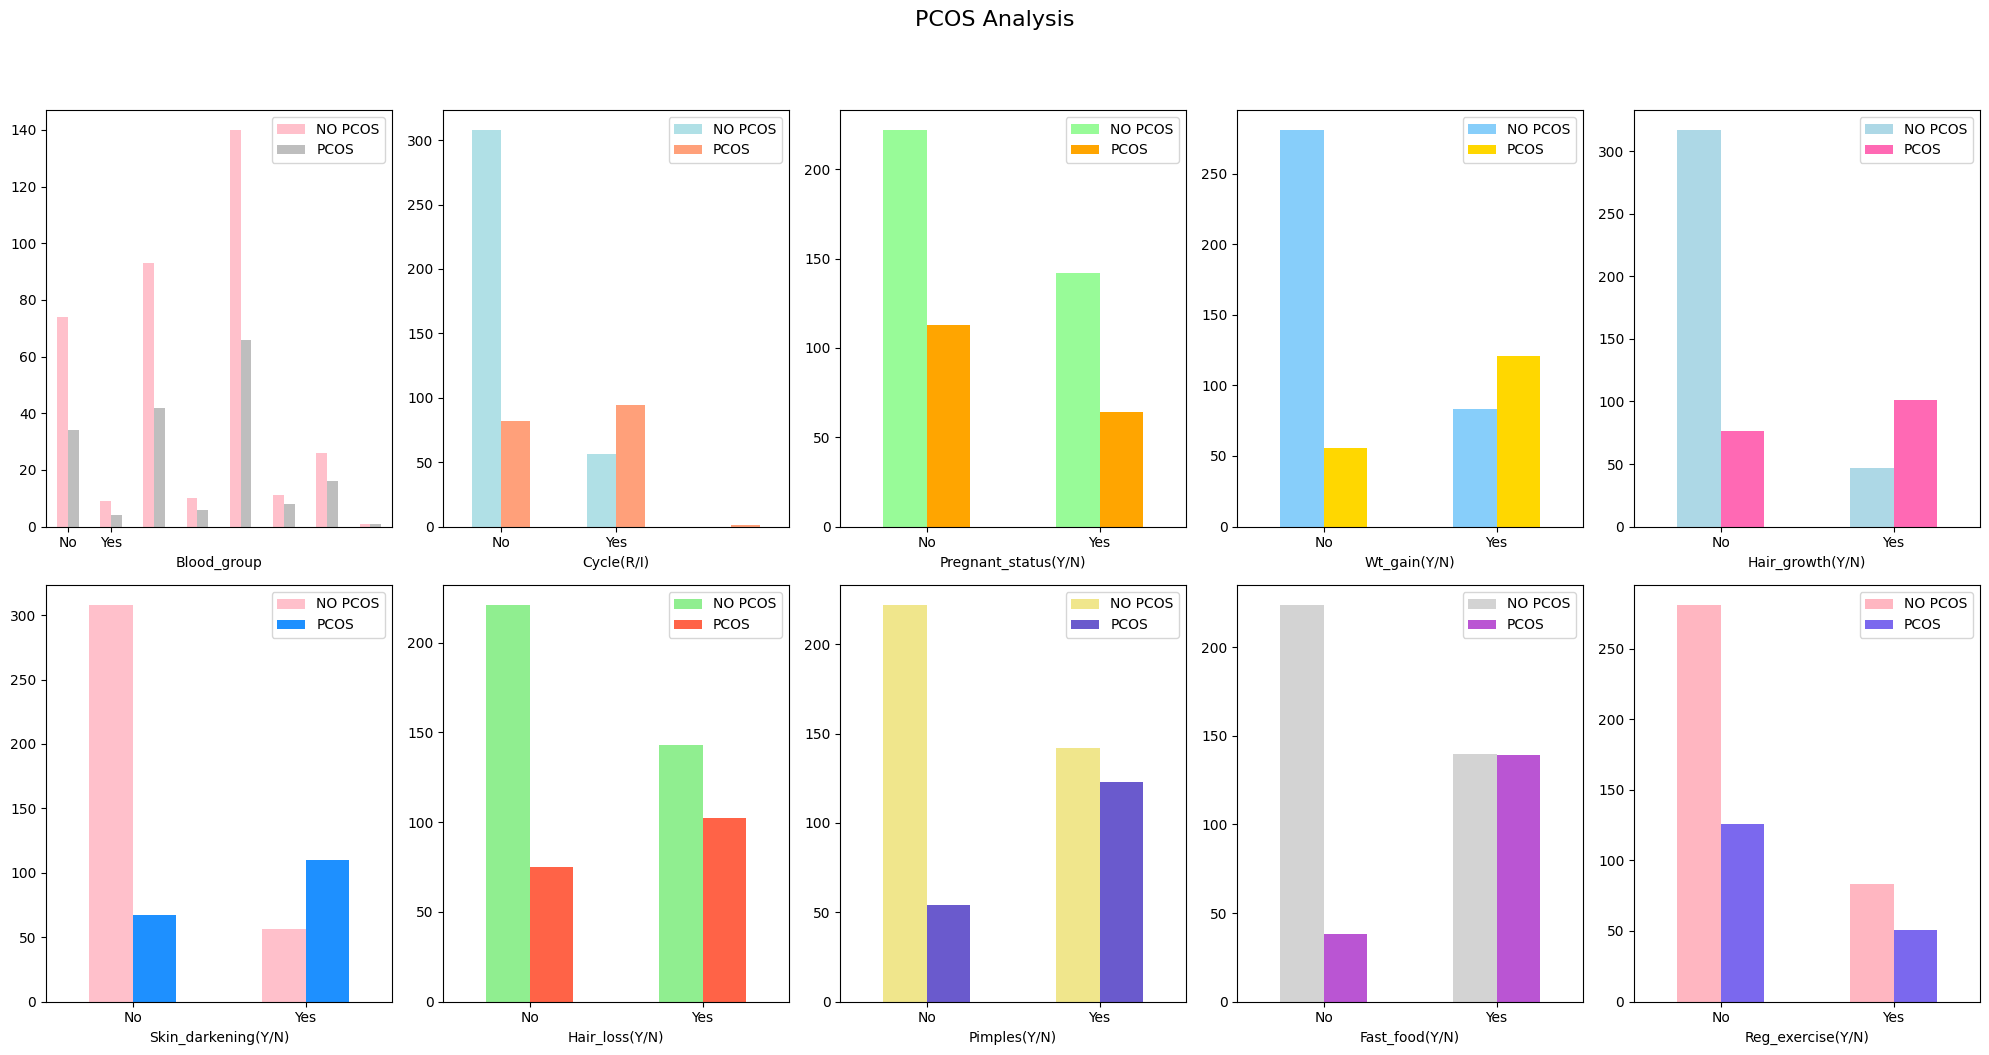

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating a list of columns to analyze
columns = ['Blood_group', 'Cycle(R/I)', 'Pregnant_status(Y/N)', 'Wt_gain(Y/N)', 
           'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)', 'Pimples(Y/N)', 
           'Fast_food(Y/N)', 'Reg_exercise(Y/N)']

# Setting up the figure and different axes on the figure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Define colors for each variable
color_dict = {
    'Blood_group': ['#FFC0CB', '#BEBEBE'],
    'Cycle(R/I)': ['#B0E0E6', '#FFA07A'],
    'Pregnant_status(Y/N)': ['#98FB98', '#FFA500'],
    'Wt_gain(Y/N)': ['#87CEFA', '#FFD700'],
    'Hair_growth(Y/N)': ['#ADD8E6', '#FF69B4'],
    'Skin_darkening(Y/N)': ['pink', '#1E90FF'],
    'Hair_loss(Y/N)': ['#90EE90', '#FF6347'],
    'Pimples(Y/N)': ['#F0E68C', '#6A5ACD'],
    'Fast_food(Y/N)': ['#D3D3D3', '#BA55D3'],
    'Reg_exercise(Y/N)': ['#FFB6C1', '#7B68EE']
}

# Plotting each crosstab on a different axis
for i, col in enumerate(columns):
    ct = pd.crosstab(df[col], df['PCOS(Y/N)'])
    ct.plot(kind='bar', ax=axs[i//5][i%5], color=color_dict[col], rot=0, grid=False)
    axs[i//5][i%5].set_xticks([0,1])
    axs[i//5][i%5].set_xticklabels(["No","Yes"])
    axs[i//5][i%5].legend(labels=['NO PCOS', 'PCOS'])
# Add overall title and save figure
plt.suptitle('PCOS Analysis', fontsize=16, y=1.05)

plt.tight_layout()


Bar graphs comparing the mean LH and FSH levels in regular and irregular menstrual cycles using data from a pandas dataframe.

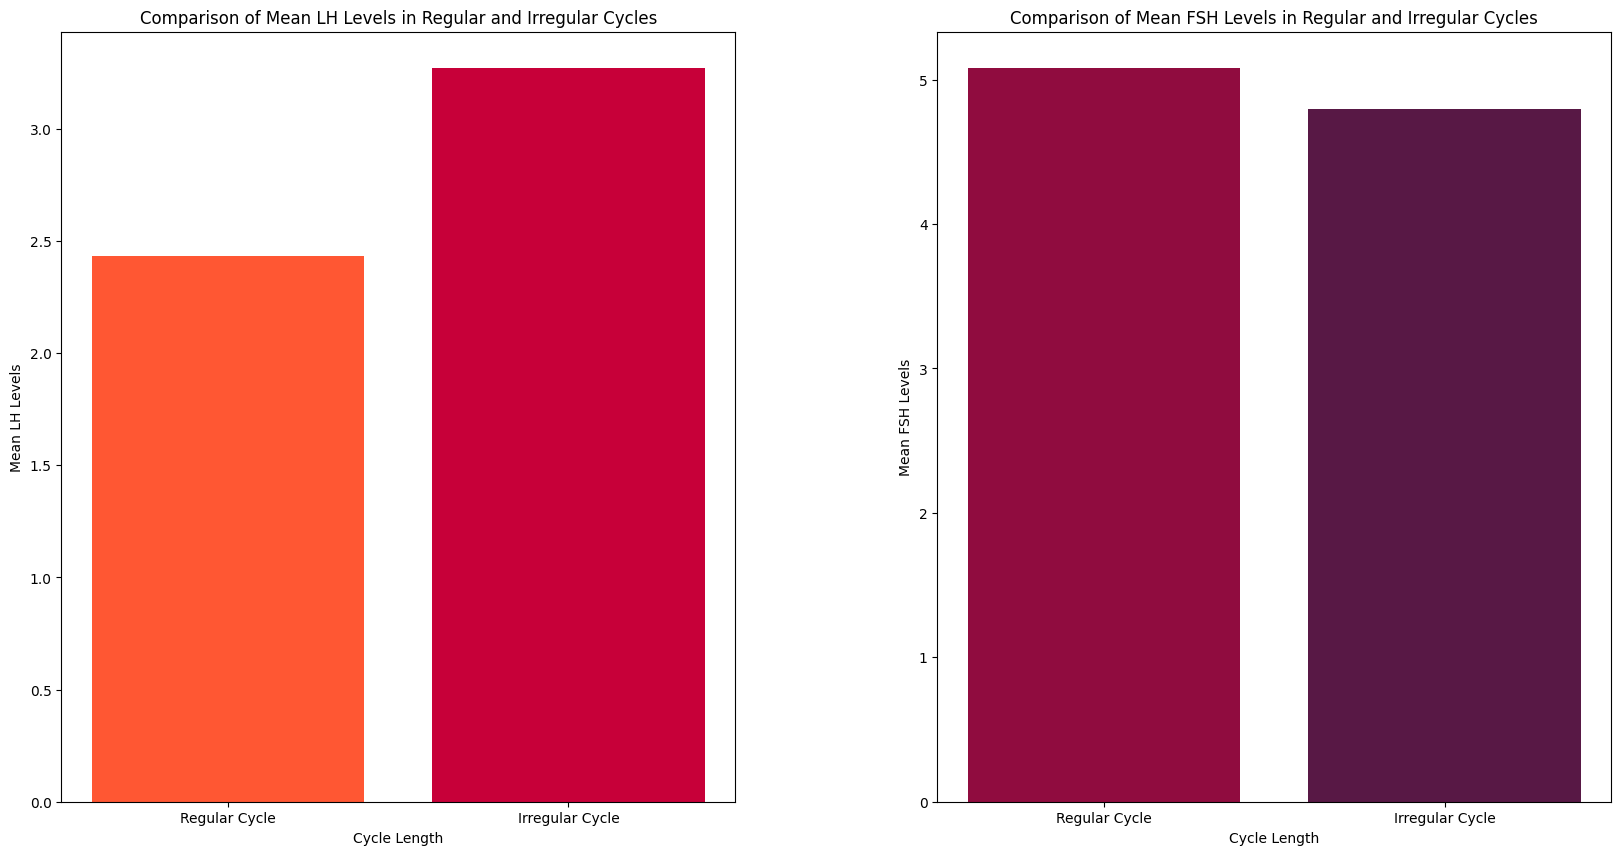

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating two separate dataframes for regular and irregular cycles
df_regular = df[df['Cycle(R/I)'] == 2]
df_irregular = df[df['Cycle(R/I)'] == 4]

# Calculating the mean LH levels for regular and irregular cycles
regular_lh_mean = df_regular['LH'].mean()
irregular_lh_mean = df_irregular['LH'].mean()

# Creating a bar graph for LH levels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].bar(['Regular Cycle', 'Irregular Cycle'], [regular_lh_mean, irregular_lh_mean], width=0.8, color=["#FF5733", "#C70039"])
ax[0].set_xlabel('Cycle Length')
ax[0].set_ylabel('Mean LH Levels')
ax[0].set_title('Comparison of Mean LH Levels in Regular and Irregular Cycles')

# Calculating the mean FSH levels for regular and irregular cycles
regular_fsh_mean = df_regular['FSH'].mean()
irregular_fsh_mean = df_irregular['FSH'].mean()

# Creating a bar graph for FSH levels
ax[1].bar(['Regular Cycle', 'Irregular Cycle'], [regular_fsh_mean, irregular_fsh_mean], width=0.8, color=["#900C3F", "#581845"])
ax[1].set_xlabel('Cycle Length')
ax[1].set_ylabel('Mean FSH Levels')
ax[1].set_title('Comparison of Mean FSH Levels in Regular and Irregular Cycles')

# Adjusting the spacing between the subplots
plt.subplots_adjust(wspace=0.3)

# Displaying the plot
plt.show()


## PREPARING DATA FOR MODELLING

In [123]:
df

PCOS(Y/N)  Age(yrs)  Weight(kg)  Height(cm)      BMI  Blood_group  \
0            0      28.0        44.6     152.000  19.3000           15   
1            0      36.0        65.0     161.500  24.9212           15   
2            1      33.0        68.8     165.000  25.2709           11   
3            0      37.0        65.0     148.000  29.6749           13   
4            0      25.0        52.0     161.000  20.0610           11   
..         ...       ...         ...         ...      ...          ...   
536          0      35.0        50.0     164.592  18.5000           17   
537          0      30.0        63.2     158.000  25.3000           15   
538          0      36.0        54.0     152.000  23.4000           13   
539          0      27.0        50.0     150.000  22.2000           15   
540          1      23.0        82.0     165.000  30.1000           13   

     PR(bpm)  RR(bpm)  Hb(g/dl)  Cycle(R/I)  ...  Fast_food(Y/N)  \
0         77       22     10.48           2  ...               1   
1         74       20     11.70           2  ...               0   
2         72       18     11.80           2  ...               1   
3         72       20     12.00           2  ...               0   
4         72       18     10.00           2  ...               0   
..       ...      ...       ...         ...  ...             ...   
536       72       16     11.00           2  ...               0   
537       72       18     10.80           2  ...               0   
538       74       20     10.80           2  ...               0   
539       74       20     12.00           4  ...               0   
540       77       20     10.20           4  ...               1   

     Reg_exercise(Y/N)  BP_systolic  BP_diastolic  Follicle.no(L)  \
0                    0          110            80               3   
1                    0          120            70               3   
2                    0          120            80              13   
3                    0          120            70               2   
4                    0          120            80               3   
..                 ...          ...           ...             ...   
536                  0          110            70               1   
537                  0          110            70               9   
538                  0          110            80               1   
539                  0          110            70               7   
540                  0          120            70               9   

     Follicle.no(R)  Avg_F_size(L)(mm)  Avg_F_size(R)(mm)  Insulin_levels  \
0                 3               18.0               18.0             7.0   
1                 5               15.0               14.0            10.0   
2                15               18.0               20.0            23.0   
3                 2               15.0               14.0            10.0   
4                 4               16.0               14.0            14.0   
..              ...                ...                ...             ...   
536               0               18.0               10.0             8.0   
537               7               19.0               18.0             7.0   
538               0               18.0                9.0             9.0   
539               6               18.0               16.0             8.0   
540              10               19.0               18.0            22.0   

     Endometrium(mm)  
0                8.0  
1                4.0  
2               10.0  
3                8.0  
4                7.0  
..               ...  
536              7.0  
537              8.0  
538              7.0  
539             12.0  
540              7.0  

[541 rows x 41 columns]

In [124]:
df["PCOS(Y/N)"].value_counts()

0    364
1    177
Name: PCOS(Y/N), dtype: int64

## FEATURE ENGINEERING

The first step in feature enginering which is already done. we handled the null values , missing vales , outliers in the dataset .
For null values or missing values we replaced them with mode for categorical columns and for the numerical columns we choose to replace them with median. 
Handled the outliers by capping them.

## FEATURE SELECTION

In [125]:
df_features = (['PCOS(Y/N)', 'Age(yrs)', 'Weight(kg)', 'FSH/LH','Waist:Hip','AMH', 'Wt_gain(Y/N)', 'Cycle(R/I)','RBS','Pregnant_status(Y/N)',
                'Hair_growth(Y/N)', 'Skin_darkening(Y/N)', 'Hair_loss(Y/N)','Fast_food(Y/N)', 'Avg_F_size(R)(mm)','Endometrium(mm)'])

## DATA SPLITTING

In [126]:
# Separate input features and target
X = df[df_features].drop('PCOS(Y/N)', axis=1)
y = df['PCOS(Y/N)']

## PERFORMING SMOTE

In [127]:
from imblearn.over_sampling import SMOTE

# Perform SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Print the shape of original data
print('Original Data Shape:', X.shape, y.shape)
# Print the shape of data after SMOTE
print('Data Shape after SMOTE:', X_smote.shape, y_smote.shape)

Original Data Shape: (541, 15) (541,)
Data Shape after SMOTE: (728, 15) (728,)


In [128]:
# Convert y_smote to a Pandas Series object and get the value counts
y_smote_series = pd.Series(y_smote)
print(y_smote_series.value_counts())

0    364
1    364
Name: PCOS(Y/N), dtype: int64


## SCALING

In [129]:
from sklearn.preprocessing import MinMaxScaler
# Perform MinMax scaling on X_smote
scaler = MinMaxScaler()
X = scaler.fit_transform(X_smote)
y= y_smote

## MACHINE LEARNING MODELS

## LOGISTIC REGRESSION CLASSIFIER

In [130]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=42)

# Create logistic regression model
clf1 = LogisticRegression(random_state=42)
clf1.fit(X_train, y_train)

# Make predictions on train and test sets
y_train_pred = clf1.predict(X_train)
y_test_pred = clf1.predict(X_test)

# fit classifier on training data using cross-validation
cv_scores = cross_val_score(clf1, X_train, y_train, cv=15)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# make predictions on validation set
y_test_pred = clf1.predict(X_test)

# calculate and print train and test accuracy
train_acc = clf1.score(X_train, y_train)
test_acc1 = clf1.score(X_test, y_test)
print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc1)

# Print classification report, accuracy, and other metrics for test data
print("Test Data Classification Report:")
print(classification_report(y_test, y_test_pred))

Cross-validation scores: [0.76       0.72       0.88       0.64       0.70833333 0.83333333
 0.83333333 0.75       0.66666667 0.79166667 0.66666667 0.58333333
 0.95833333 0.70833333 0.79166667]
Mean cross-validation score: 0.7527777777777779
Train accuracy: 0.7692307692307693
Test accuracy: 0.7362637362637363
Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       179
           1       0.79      0.66      0.72       185

    accuracy                           0.74       364
   macro avg       0.74      0.74      0.74       364
weighted avg       0.74      0.74      0.73       364



Confusion Matrix:
[[146  33]
 [ 63 122]]


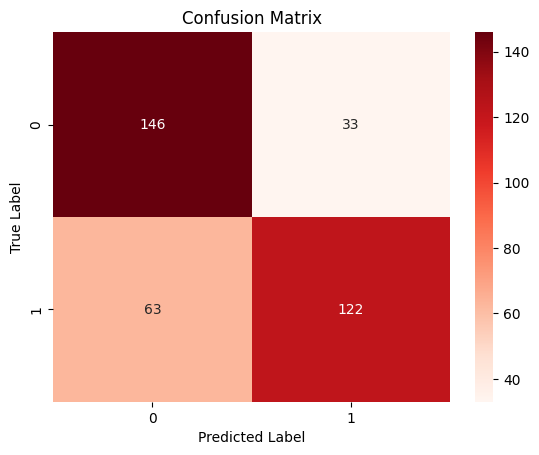

Test Data AUC-ROC Score: 0.8477729125773819


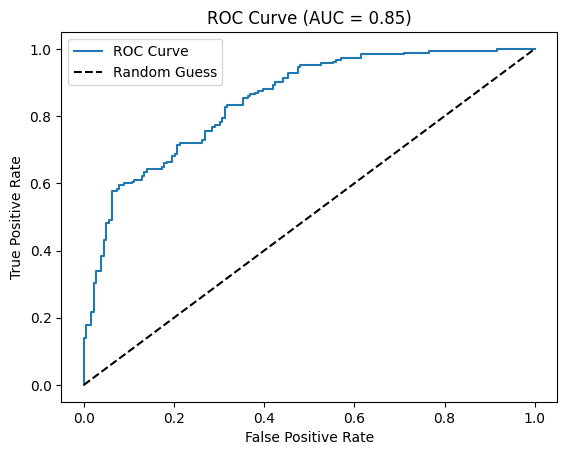

In [131]:
# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate and print AUC-ROC score for test data
y_test_pred_proba = clf1.predict_proba(X_test)[:,1]
print("Test Data AUC-ROC Score:", roc_auc_score(y_test, y_test_pred_proba))

# Calculate AUC-ROC score for test data
auc_roc_lr = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve (AUC = %0.2f)' %auc_roc_lr)
plt.legend()
plt.show()

## GUASSIAN NAIVE BAYIES

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state= 42)

# Train a Naive Bayes classifier
clf2 = GaussianNB()

# Perform 5-fold cross-validation
scores = cross_val_score(clf2, X, y, cv=15)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Fit the model on the entire data
clf2.fit(X, y)

# Make predictions on test set
y_pred = clf2.predict(X_test)

# Calculate accuracy of the model
train_acc = accuracy_score(y, clf2.predict(X))
test_acc2 = accuracy_score(y_test, y_pred)

print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc2)

# Print classification report
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.76       0.72       0.88       0.64       0.70833333 0.83333333
 0.83333333 0.75       0.66666667 0.79166667 0.66666667 0.58333333
 0.95833333 0.70833333 0.79166667]
Mean cross-validation score: 0.7527777777777779
Training accuracy: 0.7747252747252747
Test accuracy: 0.782967032967033
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       179
           1       0.80      0.76      0.78       185

    accuracy                           0.78       364
   macro avg       0.78      0.78      0.78       364
weighted avg       0.78      0.78      0.78       364



[[144  35]
 [ 44 141]]


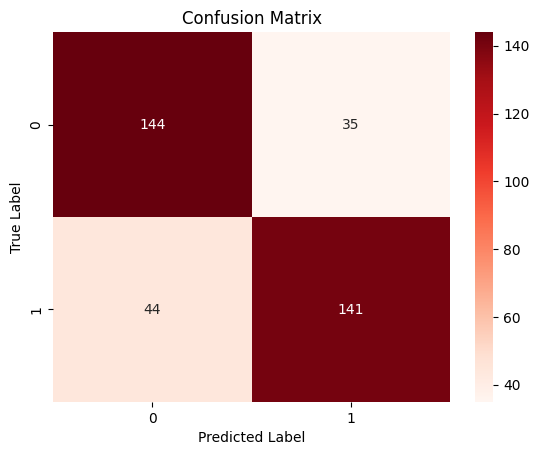

AUC ROC score: 0.7833157179525895


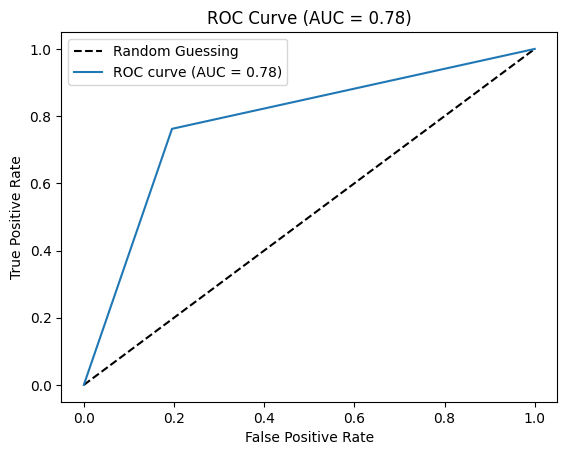

In [133]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate AUC ROC score
auc_roc_gnb = roc_auc_score(y_test, y_pred)
print('AUC ROC score:', auc_roc_gnb)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = %0.2f)' % auc_roc_gnb)
plt.legend()
plt.show()

## DECISION TREE CLASSIFIER

In [134]:
# import Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=47)

# create Decision Tree classifier
clf3 = DecisionTreeClassifier(random_state=47)

# fit classifier on training data
clf3.fit(X_train, y_train)

# make predictions on validation set
y_pred = clf3.predict(X_test)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf3, X, y, cv= 15)
print('Cross-validation scores:', cv_scores)
print('Mean cross-validation score:', np.mean(cv_scores))

# calculate training and test accuracies
train_acc = clf3.score(X_train, y_train)
test_acc3 = clf3.score(X_test, y_test)

print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc3)

# print classification report, accuracy, and other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.75510204 0.85714286 0.7755102  0.59183673 0.73469388 0.6122449
 0.63265306 0.75510204 0.75       0.77083333 0.6875     0.85416667
 0.77083333 0.79166667 0.83333333]
Mean cross-validation score: 0.7448412698412699
Training accuracy: 1.0
Test accuracy: 0.739010989010989
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.74       176
           1       0.76      0.73      0.74       188

    accuracy                           0.74       364
   macro avg       0.74      0.74      0.74       364
weighted avg       0.74      0.74      0.74       364



Confusion Matrix:
[[132  44]
 [ 51 137]]


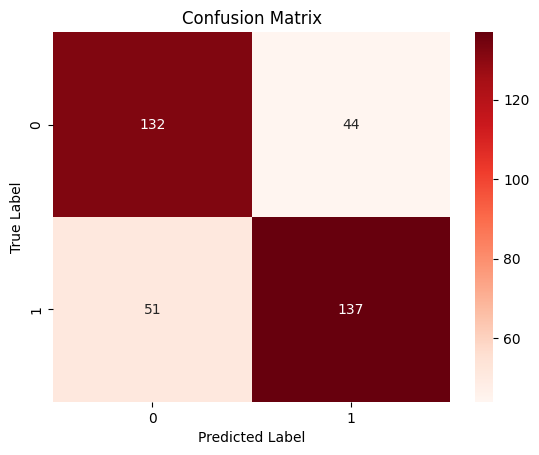

AUC-ROC Score: 0.7393617021276595


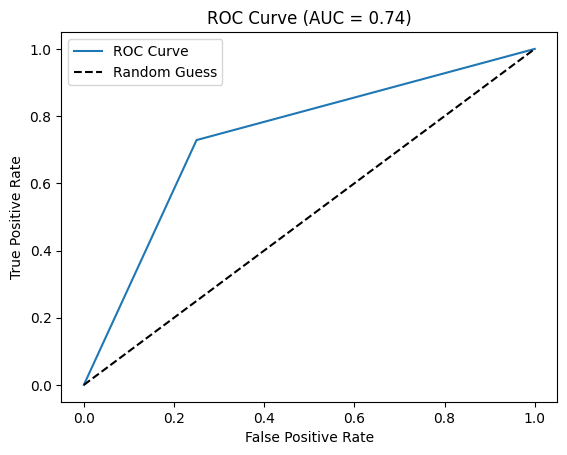

In [135]:
# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# calculate and print AUC-ROC score
y_pred_proba = clf3.predict_proba(X_test)[:,1]
auc_roc_dt = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc_roc_dt)

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve (AUC = %0.2f)' %auc_roc_dt)
plt.legend()
plt.show()

## SUPPORT VECTOR MACHINE 

In [136]:
# import SVM classifier
from sklearn.svm import SVC

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# create SVM classifier
clf4 = SVC(kernel='linear', probability=True, random_state=42)

# fit classifier on training data
clf4.fit(X_train, y_train)

# make predictions on validation set
y_pred = clf4.predict(X_test)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf4, X, y, cv= 15)
print('Cross-validation scores:', cv_scores)
print('Mean cross-validation score:', np.mean(cv_scores))

# calculate training and test accuracies
train_acc = clf4.score(X_train, y_train)
test_acc4 = clf4.score(X_test, y_test)

print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc4)

# print classification report, accuracy, and other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.85714286 0.97959184 0.93877551 0.63265306 0.75510204 0.73469388
 0.44897959 0.73469388 0.66666667 0.77083333 0.60416667 0.72916667
 0.8125     0.60416667 0.625     ]
Mean cross-validation score: 0.7262755102040815
Training accuracy: 0.771978021978022
Test accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       179
           1       0.78      0.70      0.74       185

    accuracy                           0.75       364
   macro avg       0.75      0.75      0.75       364
weighted avg       0.75      0.75      0.75       364



Confusion Matrix:
[[143  36]
 [ 55 130]]


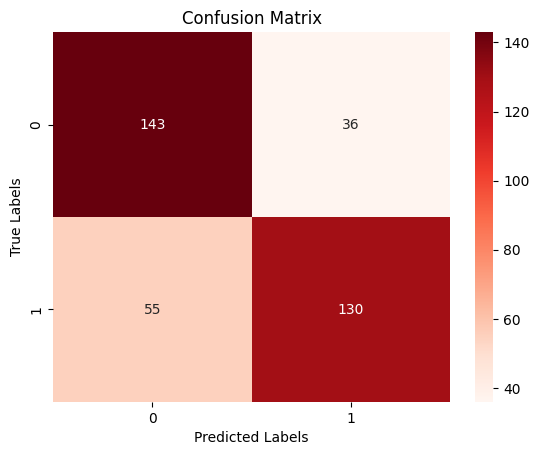

AUC-ROC Score: 0.839830892344859


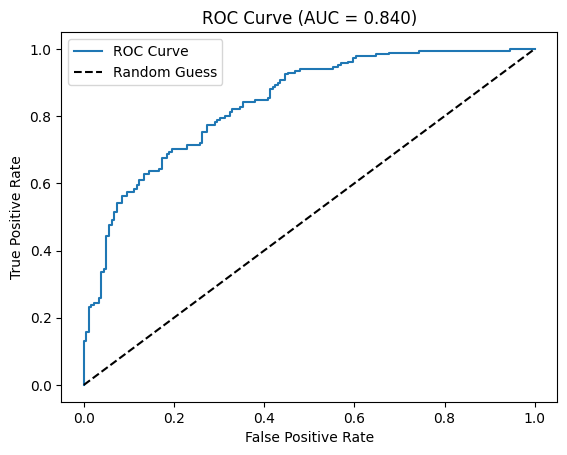

In [137]:
# print confusion matrix
y_pred = clf4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# calculate and print AUC-ROC score
y_pred_proba = clf4.predict_proba(X_test)[:,1]
auc_roc_svm = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve (AUC = %0.3f)' %auc_roc_svm)
plt.legend()
plt.show()

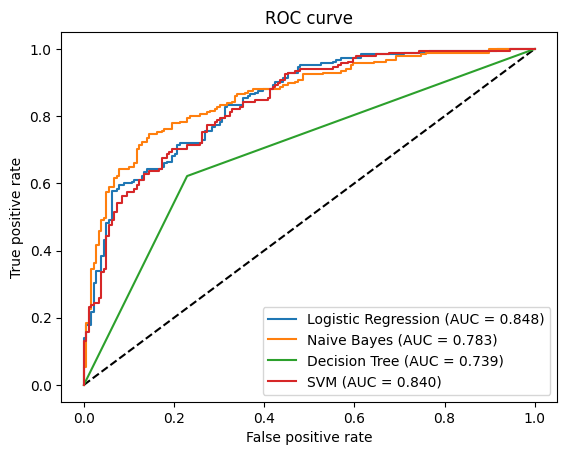

In [138]:
clf1 = LogisticRegression(random_state=42)
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(random_state=47)
clf4 = SVC(kernel='linear', probability=True, random_state=42)

# Fit the model on the entire data
clf1.fit(X_train, y_train)
y_test_pred_lr = clf1.predict_proba(X_test)[:,1]
clf2.fit(X, y)
y_test_pred_nb = clf2.predict_proba(X_test)[:,1]
clf3.fit(X_train, y_train)
y_test_pred_dt = clf3.predict_proba(X_test)[:,1]
clf4.fit(X_train, y_train)
y_test_pred_svm = clf4.predict_proba(X_test)[:,1]

# Calculate AUC-ROC score for each model
lr_auc = auc_roc_lr
nb_auc = auc_roc_gnb
dt_auc = auc_roc_dt
svm_auc = auc_roc_svm

# Plot ROC curves for each model on a single plot
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_pred_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_test_pred_nb)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_pred_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_pred_svm)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.3f)' % lr_auc)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = %0.3f)' % nb_auc)
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.3f)' % dt_auc)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.3f)' % svm_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

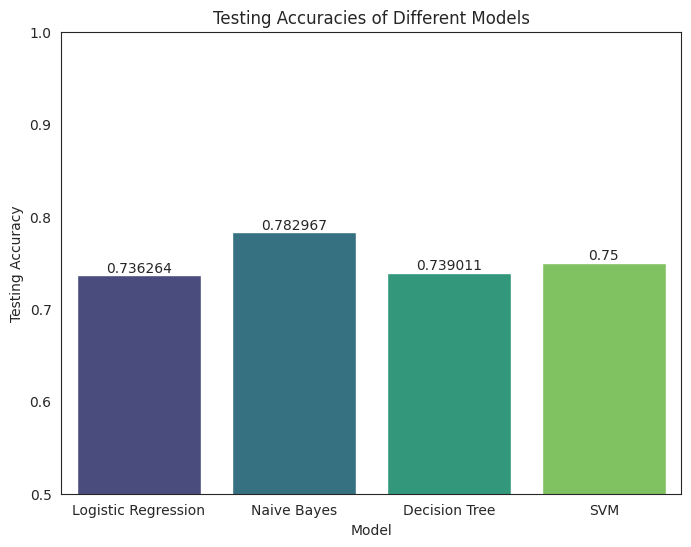

In [139]:
import matplotlib.pyplot as plt

# List of classifiers and their corresponding test accuracies
classifiers = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'SVM']
test_accs = [test_acc1, test_acc2, test_acc3, test_acc4] 

# Plot the bar plot
plt.figure(figsize=(8,6))
sns.set_style("white")
ax = sns.barplot(x=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'SVM'], y=test_accs, palette='viridis')
plt.ylim(0.5,1.0)
plt.title('Testing Accuracies of Different Models')
plt.xlabel('Model')
plt.ylabel('Testing Accuracy')

# Add scores above the bars
for i in ax.containers:
    ax.bar_label(i, label_type="edge", fontsize=10)
plt.show()


## PREDICTION TESTS

In [140]:
prediction_set = {
                  'Age(yrs)': 28,
                  'Weight(kg)': 65,
                  'FSH/LH': 1.2,
                  'Waist:Hip': 0.8,
                  'AMH': 3.5,
                  'Wt_gain(Y/N)': 0,
                  'Cycle(R/I)': 2,
                  'RBS': 90,
                  'Pregnant_status(Y/N)': 0,
                  'Hair_growth(Y/N)': 1,
                  'Skin_darkening(Y/N)': 0,
                  'Hair_loss(Y/N)': 0,
                  'Fast_food(Y/N)': 1,
                  'Avg_F_size(R)(mm)': 18,
                  'Endometrium(mm)': 8}

# Make predictions on new data
prediction = clf4.predict(pd.DataFrame([prediction_set]))
print("Prediction:", prediction)

Prediction: [0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [141]:
prediction_set1 = {
                  'Age(yrs)': 35,
                  'Weight(kg)': 70,
                  'FSH/LH': 2.5,
                  'Waist:Hip': 1.2,
                  'AMH': 10.0,
                  'Wt_gain(Y/N)': 1,
                  'Cycle(R/I)': 4,
                  'RBS': 120,
                  'Pregnant_status(Y/N)': 1,
                  'Hair_growth(Y/N)': 0,
                  'Skin_darkening(Y/N)': 1,
                  'Hair_loss(Y/N)': 1,
                  'Fast_food(Y/N)': 1,
                  'Avg_F_size(R)(mm)': 30,
                  'Endometrium(mm)': 100}

# Make predictions on new data
prediction = clf4.predict(pd.DataFrame([prediction_set1]))
print("Prediction:", prediction)

Prediction: [0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [142]:
prediction_set = {
                  'Age(yrs)': 30,
                  'Weight(kg)': 150,
                  'FSH/LH': 10.5,
                  'Waist:Hip': 10.9,
                  'AMH': 26.2,
                  'Wt_gain(Y/N)': 1,
                  'Cycle(R/I)': 3,
                  'RBS': 180,
                  'Pregnant_status(Y/N)': 0,
                  'Hair_growth(Y/N)': 1,
                  'Skin_darkening(Y/N)': 1,
                  'Hair_loss(Y/N)': 1,
                  'Fast_food(Y/N)': 1,
                  'Avg_F_size(R)(mm)': 40,
                  'Endometrium(mm)': 20}
# Make predictions on new data
prediction = clf2.predict(pd.DataFrame([prediction_set]))
print("Prediction:", prediction)

Prediction: [1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
